In [1]:
# Only for Colab, comment out if not using Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/projects/hlcv/upstream/src/notebooks/

/content/drive/MyDrive/projects/hlcv/upstream/src/notebooks


In [3]:
# Change this line if you're using Colab to something like '/content/drive/MyDrive/TeamX/'
# where TeamX is just the clone of repository on your Google Drive
# and you have mounted the drive at /content/drive  
# See the Tutorial Slides for more detail.

# Works on your local machine but not on Colab!
PROJECT_ROOT = '../../' 

# Fix this path and use this one on Colab
# PROJECT_ROOT = '/content/drive/MyDrive/TeamX' 

In [4]:
import sys
from os.path import join as ospj

sys.path.append(ospj(PROJECT_ROOT, 'src'))

%load_ext autoreload
%autoreload 2

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_logs(logs):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))
    x = np.arange(len(logs))

    ax[0].plot(x, [l["loss"] for l in logs], label="train loss")
    ax[0].plot(x, [l["eval_loss"] for l in logs], label="val loss")
    ax[0].legend()

    ax[1].plot(x, [l["top1"] for l in logs], label="train top1")
    ax[1].plot(x, [l["eval_top1"] for l in logs], label="val top1")
    if "top_5" in logs[0]:
        ax[1].plot(x, [l["top5"] for l in logs], label="train top5")
        ax[1].plot(x, [l["eval_top5"] for l in logs], label="val top5")
    else:
        ax[1].plot(x, [l["top3"] for l in logs], label="train top3")
        ax[1].plot(x, [l["eval_top3"] for l in logs], label="val top3")
    ax[1].legend()
    plt.show()

In Exercise 3, you will implement a convolutional neural network to perform image classification and explore methods to improve the training performance and generalization of these networks.
We will use the CIFAR-10 dataset as a benchmark for our networks, similar to the previous exercise. This dataset consists of 50000 training images of 32x32 resolution with 10 object classes, namely airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The task is to implement a convolutional network to classify these images using the PyTorch library. The four questions are,

- Implementing a convolutional neural network, training it, and visualizing its weights (Question 1).
- Experiment with batch normalization and early stopping (Question 2).
- Data augmentation and dropout to improve generalization (Question 3).
- Implement transfer learning from an ImageNet-pretrained model (Question 4).

### Question 1: Implement Convolutional Network (10 points)

In this question, we will implement a five-layered convolutional neural network architecture as well as the loss function to train it. Refer to the comments in the code to the exact places where you need to fill in the code.

![](../../data/exercise-3/fig1.png)

a) Our architecture is shown in Fig 1. It has five convolution blocks. Each block is consist of convolution, max pooling, and ReLU operation in that order. We will use 3×3 kernels in all convolutional layers. Set the padding and stride of the convolutional layers so that they maintain the spatial dimensions. Max pooling operations are done with 2×2 kernels, with a stride of 2, thereby halving the spatial resolution each time. Finally, stacking these five blocks leads to a 512 × 1 × 1 feature map. Classification is achieved by a fully connected layer. We will train convolutional neural networks on the CIFAR-10 dataset. Implement a class ConvNet to define the model described. The ConvNet takes 32 × 32 color images as inputs and has 5 hidden layers with 128, 512, 512, 512, 512 filters, and produces a 10-class classification. The code to train the model is already provided. Train the above model and report the training and validation accuracies. (5 points)

Please implement the above network (initialization and forward pass) in class `ConvNet` in `models/cnn/model.py`.

b) Implement the method `__str__` in `models/base_model.py`, which should give a string representaiton of the model. The string should show the number of `trainable` parameters for each layer. This gives us a measure of model capacity. Also at the end, the string contains the total number of trainable parameters for the entire model. (2 points)

![](../../data/exercise-3/fig2.png)

c) Implement a function `VisualizeFilter` in `models/cnn/model.py`, which visualizes the filters of the first convolution layer implemented in Q1.a. In other words, you need to show 128 filters with size 3x3 as color images (since each filter has three input channels). Stack these into 3x3 color images into one large image. You can use the `imshow` function from the `matplotlib` library to visualize the weights. See an example in Fig. 2 Compare the filters before and after training. Do you see any patterns? (3 points). Please attach your output images before and after training in a cell with your submission.

In [5]:
from torchvision import transforms

from utils.parse_config import ConfigParser
from trainers.cnn_trainer import CNNTrainer
import data_loaders.data_modules as module_data

from copy import deepcopy
%aimport -ConfigParser # Due to an issue of pickle and auto_reload

In [6]:
config = ConfigParser.wo_args(config='cfgs/exercise-3/cnn_cifar10.json', root_dir=PROJECT_ROOT, run_id="exp_1")

datamodule = config.init_obj('data_module', module_data,
                             root_dir=PROJECT_ROOT #Just add the root_dir to the rest of the arguments defined in config file
                            )

# Based on the heldout_split in the config file, 
# the datamodule will break the dataset into two splits
train_data_loader = datamodule.get_loader()
valid_data_loader = datamodule.get_heldout_loader()

# Test loader is the same as train loader
# except that training=False, shuffle=False, and no splitting is done 
# So we use the exact config from training and just modify these arguments
test_loader_args = deepcopy(config['data_module']['args']) #copy the args
test_loader_args['training']=False
test_loader_args['shuffle']=False
test_loader_args['heldout_split']=0.0

# Now we initialize the test module with the modified config
test_module = getattr(module_data, config['data_module']['type'])(root_dir=PROJECT_ROOT, **test_loader_args)
# And get the loader from it
test_loader = test_module.get_loader()

transformations for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 1}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 1}
transformations for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 1}


NumExpr defaulting to 2 threads.
ConvNet(
  (layers): ModuleList(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Identity()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Dropout(p=0.0, inplace=False)
    (5): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Identity()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Dropout(p=0.0, inplace=False)
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Identity()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): ReLU()
    (14): Dropout(p=0.0, inplace=False)
    (15): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): Identity()
    (17): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (18): ReLU()
    (19): Dropout(p=0.

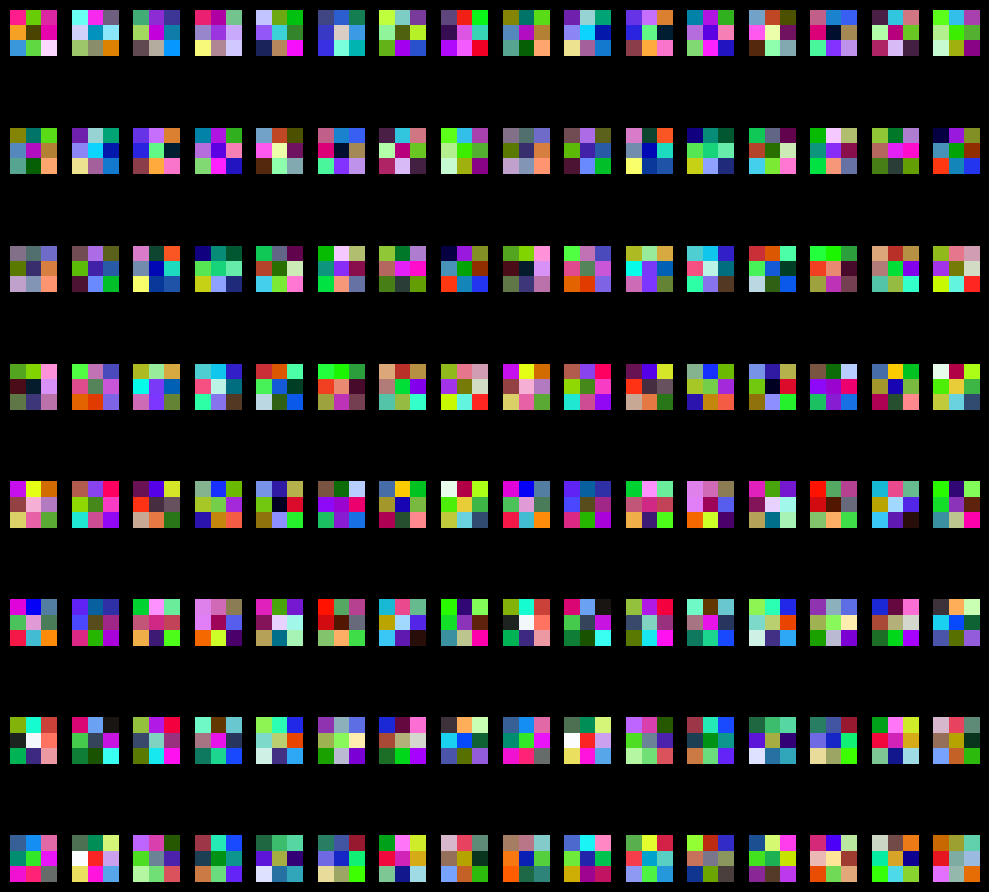

==> Start Training Epoch 1/10, lr=0.002000 


Train Epoch: 1 Loss: 1.349374: : 100% 45000/45000 [00:20<00:00, 2215.58it/s]

==> Finished Epoch 1/10.
++> Evaluate at epoch 1 ...



Eval Loss: 1.351079: : 100% 5000/5000 [00:08<00:00, 608.40it/s]

++> Evaluate epoch 1 Finished.
eval_top1 Metric improved: -inf -> 0.4942. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_1/best_val_model.pth ...


Checkpoint saved.
    epoch          : 1
    loss           : 1.7887321265538534
    top1           : 0.32451111111111103
    top5           : 0.8302444444444446
    eval_loss      : 1.363849515914917
    eval_top1      : 0.4942
    eval_top5      : 0.9434
==> Start Training Epoch 2/10, lr=0.002000 


Train Epoch: 2 Loss: 1.005649: : 100% 45000/45000 [00:23<00:00, 1932.48it/s]

==> Finished Epoch 2/10.
++> Evaluate at epoch 2 ...



Eval Loss: 1.098880: : 100% 5000/5000 [00:06<00:00, 828.55it/s] 

++> Evaluate epoch 2 Finished.
eval_top1 Metric improved: -inf -> 0.6034. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_1/best_val_model.pth ...


Checkpoint saved.
    epoch          : 2
    loss           : 1.241530819469028
    top1           : 0.5497111111111109
    top5           : 0.9474000000000001
    eval_loss      : 1.1161725902557373
    eval_top1      : 0.6034
    eval_top5      : 0.9599999999999999
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_1/E2_model.pth ...
Checkpoint saved.
==> Start Training Epoch 3/10, lr=0.002000 


Train Epoch: 3 Loss: 1.146381: : 100% 45000/45000 [00:19<00:00, 2257.22it/s]

==> Finished Epoch 3/10.
++> Evaluate at epoch 3 ...



Eval Loss: 0.987171: : 100% 5000/5000 [00:07<00:00, 676.47it/s]

++> Evaluate epoch 3 Finished.


eval_top1 Metric improved: -inf -> 0.6688000000000001. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_1/best_val_model.pth ...
Checkpoint saved.
    epoch          : 3
    loss           : 1.0070966521898905
    top1           : 0.6389333333333336
    top5           : 0.9670444444444444
    eval_loss      : 0.9509514999389649
    eval_top1      : 0.6688000000000001
    eval_top5      : 0.971
==> Start Training Epoch 4/10, lr=0.002000 


Train Epoch: 4 Loss: 0.918589: : 100% 45000/45000 [00:22<00:00, 2025.23it/s]

==> Finished Epoch 4/10.
++> Evaluate at epoch 4 ...



Eval Loss: 0.950107: : 100% 5000/5000 [00:07<00:00, 648.80it/s]

++> Evaluate epoch 4 Finished.


eval_top1 Metric improved: -inf -> 0.6920000000000001. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_1/best_val_model.pth ...
Checkpoint saved.
    epoch          : 4
    loss           : 0.882031573454539
    top1           : 0.6879111111111109
    top5           : 0.9755555555555554
    eval_loss      : 0.8923506712913514
    eval_top1      : 0.6920000000000001
    eval_top5      : 0.9751999999999998
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_1/E4_model.pth ...
Checkpoint saved.
==> Start Training Epoch 5/10, lr=0.002000 


Train Epoch: 5 Loss: 0.785131: : 100% 45000/45000 [00:22<00:00, 1966.02it/s]

==> Finished Epoch 5/10.
++> Evaluate at epoch 5 ...



Eval Loss: 0.903702: : 100% 5000/5000 [00:05<00:00, 894.23it/s] 

++> Evaluate epoch 5 Finished.
eval_top1 Metric improved: -inf -> 0.7081999999999999. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_1/best_val_model.pth ...


Checkpoint saved.
    epoch          : 5
    loss           : 0.7787521261639065
    top1           : 0.7265333333333335
    top5           : 0.9818444444444451
    eval_loss      : 0.8402677536010742
    eval_top1      : 0.7081999999999999
    eval_top5      : 0.9769999999999999
==> Start Training Epoch 6/10, lr=0.001600 


Train Epoch: 6 Loss: 0.625848: : 100% 45000/45000 [00:19<00:00, 2323.03it/s]

==> Finished Epoch 6/10.
++> Evaluate at epoch 6 ...



Eval Loss: 0.936877: : 100% 5000/5000 [00:06<00:00, 722.65it/s] 

++> Evaluate epoch 6 Finished.
eval_top1 Metric improved: -inf -> 0.7068000000000001. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_1/best_val_model.pth ...


Checkpoint saved.
    epoch          : 6
    loss           : 0.6545203649997711
    top1           : 0.7689555555555563
    top5           : 0.9872000000000023
    eval_loss      : 0.8626360201835632
    eval_top1      : 0.7068000000000001
    eval_top5      : 0.976
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_1/E6_model.pth ...
Checkpoint saved.
==> Start Training Epoch 7/10, lr=0.001600 


Train Epoch: 7 Loss: 0.630807: : 100% 45000/45000 [00:19<00:00, 2275.17it/s]

==> Finished Epoch 7/10.
++> Evaluate at epoch 7 ...



Eval Loss: 0.721171: : 100% 5000/5000 [00:07<00:00, 712.08it/s]

++> Evaluate epoch 7 Finished.
eval_top1 Metric improved: -inf -> 0.7343999999999999. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_1/best_val_model.pth ...


Checkpoint saved.
    epoch          : 7
    loss           : 0.5669569942686293
    top1           : 0.800577777777778
    top5           : 0.9904666666666694
    eval_loss      : 0.7846389079093933
    eval_top1      : 0.7343999999999999
    eval_top5      : 0.9829999999999999
==> Start Training Epoch 8/10, lr=0.001600 


Train Epoch: 8 Loss: 0.543136: : 100% 45000/45000 [00:19<00:00, 2263.00it/s]

==> Finished Epoch 8/10.
++> Evaluate at epoch 8 ...



Eval Loss: 0.835700: : 100% 5000/5000 [00:06<00:00, 723.21it/s]

++> Evaluate epoch 8 Finished.
eval_top1 Metric improved: -inf -> 0.7405999999999999. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_1/best_val_model.pth ...


Checkpoint saved.
    epoch          : 8
    loss           : 0.4875445760620965
    top1           : 0.8280666666666666
    top5           : 0.9932444444444463
    eval_loss      : 0.7946350860595703
    eval_top1      : 0.7405999999999999
    eval_top5      : 0.9827999999999997
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_1/E8_model.pth ...
Checkpoint saved.
==> Start Training Epoch 9/10, lr=0.001600 


Train Epoch: 9 Loss: 0.336431: : 100% 45000/45000 [00:19<00:00, 2266.54it/s]

==> Finished Epoch 9/10.
++> Evaluate at epoch 9 ...



Eval Loss: 1.002816: : 100% 5000/5000 [00:05<00:00, 907.87it/s]

++> Evaluate epoch 9 Finished.
eval_top1 Metric improved: -inf -> 0.7286000000000001. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_1/best_val_model.pth ...


Checkpoint saved.
    epoch          : 9
    loss           : 0.4198221351040734
    top1           : 0.8520444444444447
    top5           : 0.9952666666666684
    eval_loss      : 0.9013771533966064
    eval_top1      : 0.7286000000000001
    eval_top5      : 0.9818000000000001
==> Start Training Epoch 10/10, lr=0.001600 


Train Epoch: 10 Loss: 0.374563: : 100% 45000/45000 [00:23<00:00, 1930.43it/s]

==> Finished Epoch 10/10.
++> Evaluate at epoch 10 ...



Eval Loss: 0.932225: : 100% 5000/5000 [00:07<00:00, 631.05it/s]

++> Evaluate epoch 10 Finished.
eval_top1 Metric improved: -inf -> 0.7424. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_1/best_val_model.pth ...


Checkpoint saved.
    epoch          : 10
    loss           : 0.3386920307079951
    top1           : 0.8808222222222224
    top5           : 0.9973777777777794
    eval_loss      : 0.8826628232002258
    eval_top1      : 0.7424
    eval_top5      : 0.9791999999999998
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_1/E10_model.pth ...
Checkpoint saved.
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_1/last_model.pth ...
Checkpoint saved.


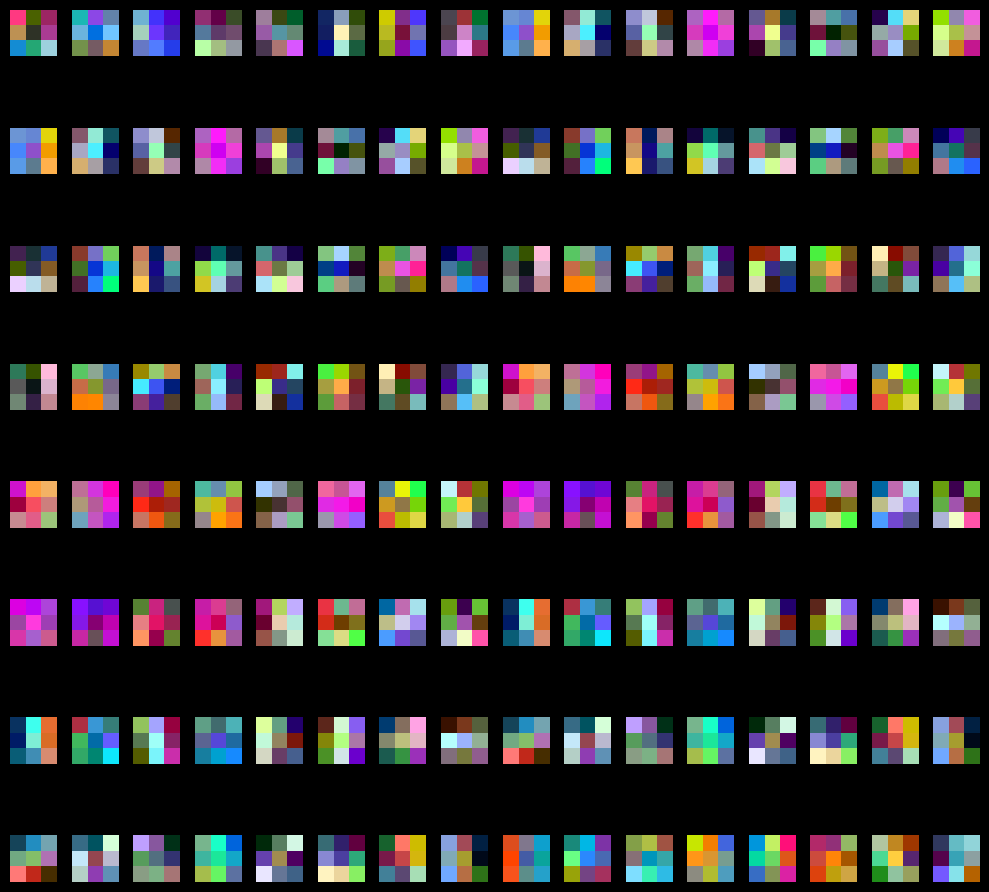

In [7]:
trainer_cnn = CNNTrainer(config=config, train_loader=train_data_loader, eval_loader=valid_data_loader)

trainer_cnn.model.VisualizeFilter()
logs = trainer_cnn.train()
trainer_cnn.model.VisualizeFilter()

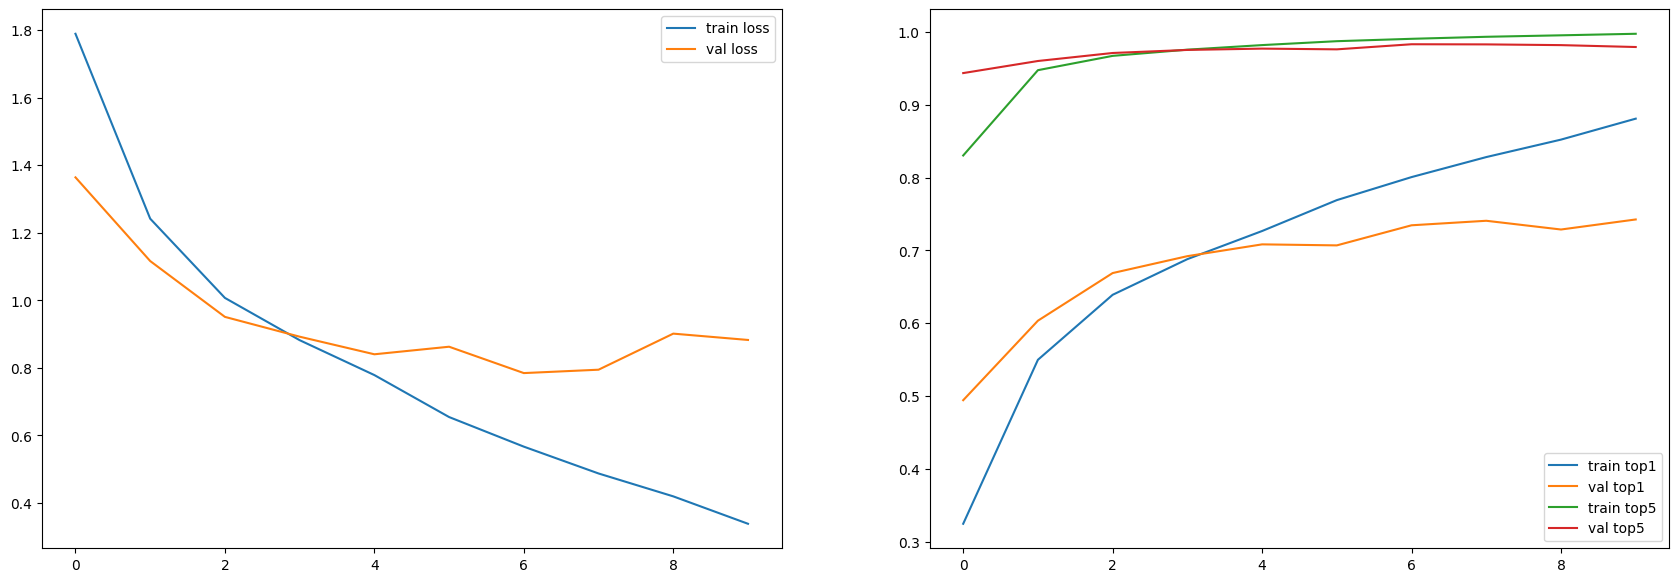

In [19]:
plot_logs(logs)

In [20]:
# Change this to the experiment you want to visualize (format is `MMDD_TIME`)
checkpoint_dir = 'exp_1' 
path = ospj(PROJECT_ROOT, f'saved/models/CIFAR10_CNN/{checkpoint_dir}/last_model.pth')

trainer_cnn.load_model(path=path)

result = trainer_cnn.evaluate(loader=test_loader)

print(result)

Loading checkpoint: ../../saved/models/CIFAR10_CNN/exp_1/last_model.pth ...
Checkpoint loaded.
++> Evaluate at epoch 10 ...


Eval Loss: 0.941427: : 100% 10000/10000 [00:12<00:00, 782.15it/s]

++> Evaluate epoch 10 Finished.
{'loss': 0.9263237297534943, 'top1': 0.7257000000000002, 'top5': 0.9791999999999997}


#### Wirte your report for Q1 in this cell.

1.   **We have implemented the CNN with 5 Convolution+Maxpool blocks with  activations, normalization and dropout layer in between.**
    *   **We have used getattr function in python to allow changing the Activation and Norm layers from config. By dedault Norm layer is** *Identity* **and activation layer is** *ReLu*
    *   **The droput layer has a defualt value of 0 (no dropout)**


2.   **The filters of the first convolution layer change after training but its difficult to interpret what these changes mean i.e. its difficult to identify what these filters are extracting**   

3. **The training loss and validation curves show that the model is overfitting indicating a need for regularization**


### Question 2: Improve training of Convolutional Networks (15 points)

a) Batch normalization is a widely used operation in neural networks, which will increase the speed of convergence and reach higher performance. You can read the paper “Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift” for more theoretical details.
In practice, these operations are implemented in most toolboxes, such as PyTorch and TensorFlow. Add batch normalization in the model of Q1.a (You can use PyTorch's implementation). Please keep other hyperparameters the same, but only add batch normalization. The ConvNet with batch normalization still uses the same class with Q1.a but different arguments. Check the code for details. In each block, the computations are in the order of convolution, batch normalization, pooling, and ReLU. Compare the loss curves and accuracy using batch normalization to its counterpart in Q1.a. (5 points)

NumExpr defaulting to 2 threads.
ConvNet(
  (layers): ModuleList(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Dropout(p=0.0, inplace=False)
    (5): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Dropout(p=0.0, inplace=False)
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): ReLU()
    (14): Dropout(p=0.0, inplace=False)
    (15): Con

Train Epoch: 1 Loss: 1.087999: : 100% 45000/45000 [00:23<00:00, 1895.65it/s]

==> Finished Epoch 1/10.
++> Evaluate at epoch 1 ...



Eval Loss: 1.058794: : 100% 5000/5000 [00:07<00:00, 698.52it/s]

++> Evaluate epoch 1 Finished.
eval_top1 Metric improved: -inf -> 0.6339999999999999. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2a/best_val_model.pth ...


Checkpoint saved.
    epoch          : 1
    loss           : 1.2927271249559191
    top1           : 0.5258888888888889
    top5           : 0.9333333333333337
    eval_loss      : 1.0138876128196717
    eval_top1      : 0.6339999999999999
    eval_top5      : 0.9679999999999999
==> Start Training Epoch 2/10, lr=0.002000 


Train Epoch: 2 Loss: 0.654887: : 100% 45000/45000 [00:27<00:00, 1626.50it/s]

==> Finished Epoch 2/10.
++> Evaluate at epoch 2 ...



Eval Loss: 1.213641: : 100% 5000/5000 [00:05<00:00, 958.34it/s] 

++> Evaluate epoch 2 Finished.
eval_top1 Metric improved: -inf -> 0.5836. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2a/best_val_model.pth ...


Checkpoint saved.
    epoch          : 2
    loss           : 0.8202460757891337
    top1           : 0.7097111111111115
    top5           : 0.9789111111111116
    eval_loss      : 1.1932525110244752
    eval_top1      : 0.5836
    eval_top5      : 0.9685999999999999
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2a/E2_model.pth ...
Checkpoint saved.
==> Start Training Epoch 3/10, lr=0.002000 


Train Epoch: 3 Loss: 0.563667: : 100% 45000/45000 [00:22<00:00, 2007.62it/s]

==> Finished Epoch 3/10.
++> Evaluate at epoch 3 ...



Eval Loss: 0.661071: : 100% 5000/5000 [00:05<00:00, 952.84it/s]

++> Evaluate epoch 3 Finished.
eval_top1 Metric improved: -inf -> 0.7550000000000001. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2a/best_val_model.pth ...


Checkpoint saved.
    epoch          : 3
    loss           : 0.6161950482262506
    top1           : 0.7840222222222225
    top5           : 0.9891333333333348
    eval_loss      : 0.7072495865821838
    eval_top1      : 0.7550000000000001
    eval_top5      : 0.9855999999999999
==> Start Training Epoch 4/10, lr=0.002000 


Train Epoch: 4 Loss: 0.618796: : 100% 45000/45000 [00:22<00:00, 1968.72it/s]

==> Finished Epoch 4/10.


++> Evaluate at epoch 4 ...


Eval Loss: 0.841051: : 100% 5000/5000 [00:05<00:00, 923.28it/s]

++> Evaluate epoch 4 Finished.
eval_top1 Metric improved: -inf -> 0.7330000000000001. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2a/best_val_model.pth ...


Checkpoint saved.
    epoch          : 4
    loss           : 0.47623272326257493
    top1           : 0.8307555555555556
    top5           : 0.993733333333335
    eval_loss      : 0.8530436706542969
    eval_top1      : 0.7330000000000001
    eval_top5      : 0.9793999999999999
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2a/E4_model.pth ...
Checkpoint saved.
==> Start Training Epoch 5/10, lr=0.002000 


Train Epoch: 5 Loss: 0.377817: : 100% 45000/45000 [00:22<00:00, 1983.76it/s]

==> Finished Epoch 5/10.
++> Evaluate at epoch 5 ...



Eval Loss: 0.870698: : 100% 5000/5000 [00:05<00:00, 957.92it/s] 

++> Evaluate epoch 5 Finished.
eval_top1 Metric improved: -inf -> 0.7567999999999999. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2a/best_val_model.pth ...


Checkpoint saved.
    epoch          : 5
    loss           : 0.35229845364888507
    top1           : 0.8783333333333341
    top5           : 0.9963777777777792
    eval_loss      : 0.8487189149856568
    eval_top1      : 0.7567999999999999
    eval_top5      : 0.9802000000000001
==> Start Training Epoch 6/10, lr=0.001600 


Train Epoch: 6 Loss: 0.205734: : 100% 45000/45000 [00:25<00:00, 1738.54it/s]

==> Finished Epoch 6/10.
++> Evaluate at epoch 6 ...



Eval Loss: 0.707417: : 100% 5000/5000 [00:06<00:00, 734.02it/s]

++> Evaluate epoch 6 Finished.
eval_top1 Metric improved: -inf -> 0.7918. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2a/best_val_model.pth ...


Checkpoint saved.
    epoch          : 6
    loss           : 0.20142125540309483
    top1           : 0.9308888888888888
    top5           : 0.9991333333333339
    eval_loss      : 0.773464834690094
    eval_top1      : 0.7918
    eval_top5      : 0.9867999999999998
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2a/E6_model.pth ...
Checkpoint saved.
==> Start Training Epoch 7/10, lr=0.001600 


Train Epoch: 7 Loss: 0.150283: : 100% 45000/45000 [00:21<00:00, 2110.70it/s]

==> Finished Epoch 7/10.
++> Evaluate at epoch 7 ...



Eval Loss: 0.616618: : 100% 5000/5000 [00:06<00:00, 750.14it/s]

++> Evaluate epoch 7 Finished.
eval_top1 Metric improved: -inf -> 0.8064. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2a/best_val_model.pth ...


Checkpoint saved.
    epoch          : 7
    loss           : 0.12788508229785495
    top1           : 0.9561333333333327
    top5           : 0.9997111111111111
    eval_loss      : 0.7238427674770356
    eval_top1      : 0.8064
    eval_top5      : 0.9871999999999999
==> Start Training Epoch 8/10, lr=0.001600 


Train Epoch: 8 Loss: 0.139475: : 100% 45000/45000 [00:22<00:00, 1958.57it/s]

==> Finished Epoch 8/10.
++> Evaluate at epoch 8 ...



Eval Loss: 0.669757: : 100% 5000/5000 [00:06<00:00, 772.79it/s]

++> Evaluate epoch 8 Finished.
eval_top1 Metric improved: -inf -> 0.8034. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2a/best_val_model.pth ...


Checkpoint saved.
    epoch          : 8
    loss           : 0.09808250592814552
    top1           : 0.9656666666666669
    top5           : 0.9999111111111112
    eval_loss      : 0.7460467171669006
    eval_top1      : 0.8034
    eval_top5      : 0.9878
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2a/E8_model.pth ...
Checkpoint saved.
==> Start Training Epoch 9/10, lr=0.001600 


Train Epoch: 9 Loss: 0.069052: : 100% 45000/45000 [00:20<00:00, 2171.26it/s]

==> Finished Epoch 9/10.
++> Evaluate at epoch 9 ...



Eval Loss: 0.756330: : 100% 5000/5000 [00:06<00:00, 809.78it/s]

++> Evaluate epoch 9 Finished.
eval_top1 Metric improved: -inf -> 0.8140000000000001. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2a/best_val_model.pth ...


Checkpoint saved.
    epoch          : 9
    loss           : 0.07502345131503212
    top1           : 0.9740666666666665
    top5           : 0.9999333333333333
    eval_loss      : 0.7488940739631653
    eval_top1      : 0.8140000000000001
    eval_top5      : 0.9897999999999999
==> Start Training Epoch 10/10, lr=0.001600 


Train Epoch: 10 Loss: 0.118212: : 100% 45000/45000 [00:20<00:00, 2145.33it/s]

==> Finished Epoch 10/10.
++> Evaluate at epoch 10 ...



Eval Loss: 0.716275: : 100% 5000/5000 [00:05<00:00, 929.56it/s]

++> Evaluate epoch 10 Finished.
eval_top1 Metric improved: -inf -> 0.7976000000000001. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2a/best_val_model.pth ...
Checkpoint saved.


    epoch          : 10
    loss           : 0.0732420224779182
    top1           : 0.9735111111111117
    top5           : 0.9999555555555556
    eval_loss      : 0.9005709171295166
    eval_top1      : 0.7976000000000001
    eval_top5      : 0.9880000000000001
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2a/E10_model.pth ...
Checkpoint saved.
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2a/last_model.pth ...
Checkpoint saved.
Loading checkpoint: ../../saved/models/CIFAR10_CNN/exp_2a/last_model.pth ...
Checkpoint loaded.
++> Evaluate at epoch 10 ...


Eval Loss: 1.099651: : 100% 10000/10000 [00:11<00:00, 859.03it/s] 

++> Evaluate epoch 10 Finished.


{'loss': 0.9520479309558868, 'top1': 0.7870999999999999, 'top5': 0.9865999999999998}


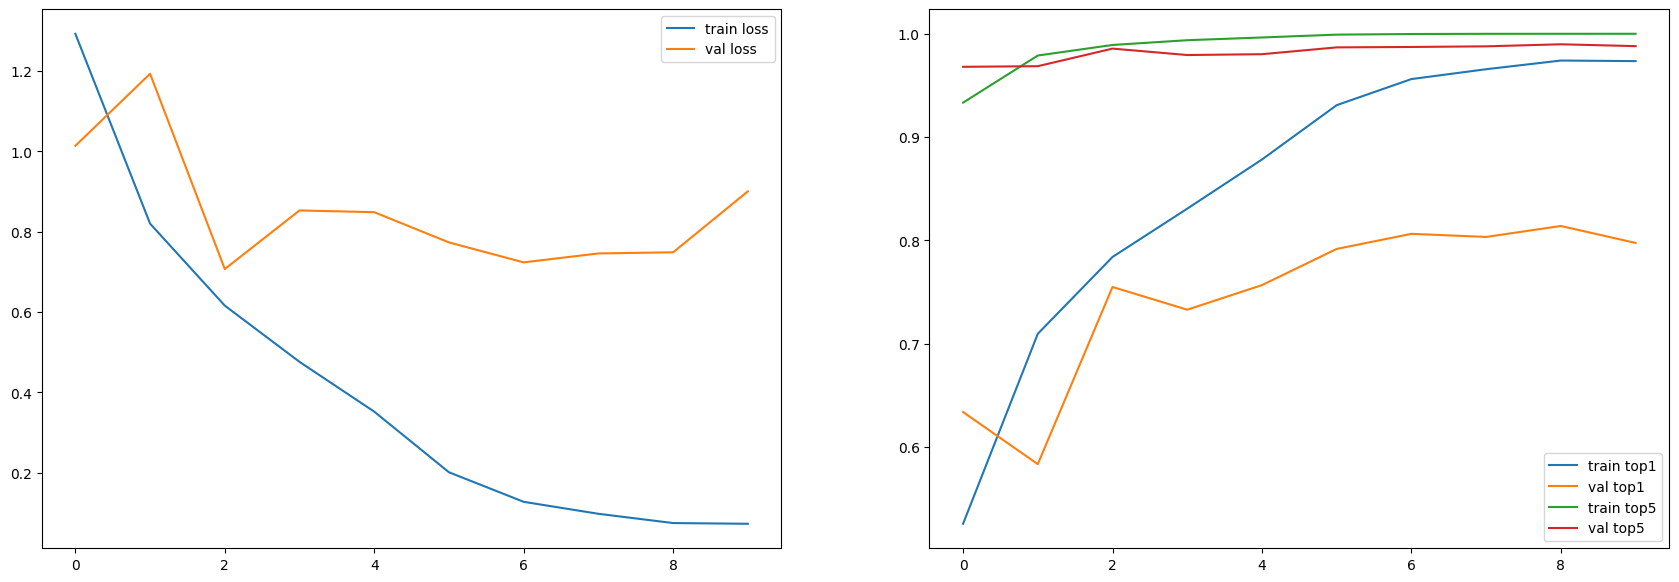

In [8]:
config = ConfigParser.wo_args(config='cfgs/exercise-3/cnn_cifar10.json', root_dir=PROJECT_ROOT, run_id="exp_2a")
config["arch"]["args"]["norm_layer"]["type"] = "BatchNorm2d"

trainer_cnn = CNNTrainer(config=config, train_loader=train_data_loader, eval_loader=valid_data_loader)

#train
logs = trainer_cnn.train()

#evaluate
checkpoint_dir = 'exp_2a' 
path = ospj(PROJECT_ROOT, f'saved/models/CIFAR10_CNN/{checkpoint_dir}/last_model.pth')
trainer_cnn.load_model(path=path)
result = trainer_cnn.evaluate(loader=test_loader)

print(result)
plot_logs(logs)

Wirte your report for Q2.a in this cell. Feel free to add extra code cells

1. **The Batch Normalization speeds up the training significantly. The loss curves show that training loss falls much faster as compared to the run without BatchNormalization. By the end of the 10 epochs it seems that training loss starts to converge to 0.07 where as in the run without BatchNorm training loss was 0.3 after 10 epochs and it did not flatten**.

2. **Batch Norm does not help with regulaization as eval loss shows similar trend : decrease at first then rise**



b) Throughout training, we optimize our parameters on the training set. This does not guarantee that with ever step we also improve on validation and test set as well! Hence, there is no reason for our latest training checkpoint (the last checkpoint after the last epoch) to be the best to keep. One simple idea is to save a checkpoint of the best model for the validation set throughout the training. Meanining that as the training proceeds, we keep checking our accuracy after each epoch (or every N epochs) and save the best model. This can mitigate overfitting, as if the model overfits to training data (and accuracy on validation set drops), we would still have access to the best model checkpoint! Note that you should not do this on the test set, as we are not alowed to optimize **anything** (including the checkpoint selection) on the test set.

For this task, you need add the logic for saving the `best model` during the training. In the `src/trainers/base_trainer`, in method `train()` we have already have the call to `self.evaluate()`. All you need to add is to process the returned result (a dictionary of metric_key -> metric_value) and see if you should save a checkpoint of the model. If yes, then you can save a checkpoint at `self.checkpoint_dir` under `best_val_model.pth` or a similar name, using the `save_model()` method. Feel free to define additional class attributes or methods if needed.
We also recommend adding a few prints, such as the epochs that you save the best model at.

Increase the training epochs to 50 in Q1.a and Q2.a, and compare the **best model** and **latest model** on the **training set** and **validation set**. Due to the randomness, you can train multiple times to verify and observe overfitting and early stopping. (5 points)
Feel free to add any needed train/evaluation code below for this task.

You can also add extra code to `base_trainer.py` so that it returns extra information after the training is finished. For example, in assignment 2's `models/twolayernet/model.py` we had a train method that would return the history of loss values, and then in the notebook the history was plotted. Feel free to make adjustments that let you better understand what's happening. This also applies to next questions. Right now the code only uses tensorboard and wandb for plotting (if enabled in config). 

NumExpr defaulting to 2 threads.
ConvNet(
  (layers): ModuleList(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Dropout(p=0.0, inplace=False)
    (5): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Dropout(p=0.0, inplace=False)
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): ReLU()
    (14): Dropout(p=0.0, inplace=False)
    (15): Con

Train Epoch: 1 Loss: 0.967426: : 100% 45000/45000 [00:22<00:00, 1982.71it/s]

==> Finished Epoch 1/25.
++> Evaluate at epoch 1 ...



Eval Loss: 0.978062: : 100% 5000/5000 [00:05<00:00, 944.97it/s] 

++> Evaluate epoch 1 Finished.
eval_top1 Metric improved: -inf -> 0.6563999999999999. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 1
    loss           : 1.2587159403165182
    top1           : 0.5372888888888889
    top5           : 0.9370888888888896
    eval_loss      : 0.9748018312454224
    eval_top1      : 0.6563999999999999
    eval_top5      : 0.9676
==> Start Training Epoch 2/25, lr=0.002000 


Train Epoch: 2 Loss: 0.669117: : 100% 45000/45000 [00:21<00:00, 2074.56it/s]

==> Finished Epoch 2/25.
++> Evaluate at epoch 2 ...



Eval Loss: 0.954857: : 100% 5000/5000 [00:05<00:00, 945.39it/s]

++> Evaluate epoch 2 Finished.
eval_top1 Metric improved: 0.6563999999999999 -> 0.7086000000000001. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 2
    loss           : 0.78958305199941
    top1           : 0.7211333333333332
    top5           : 0.9815111111111122
    eval_loss      : 0.8557899570465088
    eval_top1      : 0.7086000000000001
    eval_top5      : 0.9782
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/E2_model.pth ...
Checkpoint saved.
==> Start Training Epoch 3/25, lr=0.002000 


Train Epoch: 3 Loss: 0.564647: : 100% 45000/45000 [00:21<00:00, 2065.05it/s]

==> Finished Epoch 3/25.
++> Evaluate at epoch 3 ...



Eval Loss: 0.759332: : 100% 5000/5000 [00:05<00:00, 962.02it/s] 

++> Evaluate epoch 3 Finished.
eval_top1 Metric improved: 0.7086000000000001 -> 0.7391999999999999. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 3
    loss           : 0.6020444357395172
    top1           : 0.7901555555555555
    top5           : 0.9887777777777795
    eval_loss      : 0.8078203344345093
    eval_top1      : 0.7391999999999999
    eval_top5      : 0.9798
==> Start Training Epoch 4/25, lr=0.002000 


Train Epoch: 4 Loss: 0.496520: : 100% 45000/45000 [00:22<00:00, 2032.63it/s]

==> Finished Epoch 4/25.
++> Evaluate at epoch 4 ...



Eval Loss: 0.621737: : 100% 5000/5000 [00:05<00:00, 936.75it/s] 

++> Evaluate epoch 4 Finished.
eval_top1 Metric improved: 0.7391999999999999 -> 0.7800000000000001. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 4
    loss           : 0.46906728201442294
    top1           : 0.8363111111111112
    top5           : 0.99397777777778
    eval_loss      : 0.6699899077415467
    eval_top1      : 0.7800000000000001
    eval_top5      : 0.9874
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/E4_model.pth ...
Checkpoint saved.
==> Start Training Epoch 5/25, lr=0.002000 


Train Epoch: 5 Loss: 0.375304: : 100% 45000/45000 [00:21<00:00, 2047.52it/s]

==> Finished Epoch 5/25.
++> Evaluate at epoch 5 ...



Eval Loss: 0.645347: : 100% 5000/5000 [00:05<00:00, 879.01it/s]

++> Evaluate epoch 5 Finished.
eval_top1 Metric improved: 0.7800000000000001 -> 0.7908. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 5
    loss           : 0.34388582170009613
    top1           : 0.8785999999999999
    top5           : 0.9967111111111125
    eval_loss      : 0.6644347500801087
    eval_top1      : 0.7908
    eval_top5      : 0.9868000000000002
==> Start Training Epoch 6/25, lr=0.001600 


Train Epoch: 6 Loss: 0.229776: : 100% 45000/45000 [00:21<00:00, 2128.93it/s]

==> Finished Epoch 6/25.
++> Evaluate at epoch 6 ...



Eval Loss: 0.586556: : 100% 5000/5000 [00:06<00:00, 799.30it/s]

++> Evaluate epoch 6 Finished.
eval_top1 Metric improved: 0.7908 -> 0.8142000000000001. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 6
    loss           : 0.18619795554214053
    top1           : 0.9361777777777774
    top5           : 0.9990000000000007
    eval_loss      : 0.590965986251831
    eval_top1      : 0.8142000000000001
    eval_top5      : 0.9914000000000001
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/E6_model.pth ...
Checkpoint saved.
==> Start Training Epoch 7/25, lr=0.001600 


Train Epoch: 7 Loss: 0.120040: : 100% 45000/45000 [00:21<00:00, 2118.78it/s]

==> Finished Epoch 7/25.
++> Evaluate at epoch 7 ...



Eval Loss: 0.681222: : 100% 5000/5000 [00:06<00:00, 763.76it/s] 

++> Evaluate epoch 7 Finished.
    epoch          : 7
    loss           : 0.12841702812247807
    top1           : 0.9565555555555555
    top5           : 0.9996222222222224
    eval_loss      : 0.7353850960731506
    eval_top1      : 0.8009999999999999
    eval_top5      : 0.9889999999999999
==> Start Training Epoch 8/25, lr=0.001600 



Train Epoch: 8 Loss: 0.097302: : 100% 45000/45000 [00:20<00:00, 2197.44it/s]

==> Finished Epoch 8/25.
++> Evaluate at epoch 8 ...



Eval Loss: 0.734181: : 100% 5000/5000 [00:07<00:00, 710.55it/s] 

++> Evaluate epoch 8 Finished.
eval_top1 Metric improved: 0.8142000000000001 -> 0.8190000000000001. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 8
    loss           : 0.08957274506489436
    top1           : 0.9686
    top5           : 0.9998666666666668
    eval_loss      : 0.72530024766922
    eval_top1      : 0.8190000000000001
    eval_top5      : 0.9873999999999999
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/E8_model.pth ...
Checkpoint saved.
==> Start Training Epoch 9/25, lr=0.001600 


Train Epoch: 9 Loss: 0.081224: : 100% 45000/45000 [00:20<00:00, 2167.77it/s]

==> Finished Epoch 9/25.
++> Evaluate at epoch 9 ...



Eval Loss: 0.703858: : 100% 5000/5000 [00:07<00:00, 712.28it/s]

++> Evaluate epoch 9 Finished.
    epoch          : 9
    loss           : 0.07449423934850428
    top1           : 0.9746222222222221
    top5           : 0.9999555555555556
    eval_loss      : 0.8588883304595947
    eval_top1      : 0.802
    eval_top5      : 0.987
==> Start Training Epoch 10/25, lr=0.001600 



Train Epoch: 10 Loss: 0.089365: : 100% 45000/45000 [00:21<00:00, 2137.44it/s]

==> Finished Epoch 10/25.
++> Evaluate at epoch 10 ...



Eval Loss: 0.856327: : 100% 5000/5000 [00:07<00:00, 701.79it/s]

++> Evaluate epoch 10 Finished.
    epoch          : 10
    loss           : 0.07001372635364532
    top1           : 0.9747333333333328
    top5           : 0.9999333333333333
    eval_loss      : 0.8413504791259766


    eval_top1      : 0.8064
    eval_top5      : 0.9911999999999999
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/E10_model.pth ...
Checkpoint saved.
==> Start Training Epoch 11/25, lr=0.001280 


Train Epoch: 11 Loss: 0.027088: : 100% 45000/45000 [00:20<00:00, 2150.84it/s]

==> Finished Epoch 11/25.
++> Evaluate at epoch 11 ...



Eval Loss: 0.681087: : 100% 5000/5000 [00:07<00:00, 706.92it/s]

++> Evaluate epoch 11 Finished.
eval_top1 Metric improved: 0.8190000000000001 -> 0.8341999999999998. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 11
    loss           : 0.029435644932091234
    top1           : 0.9903111111111128
    top5           : 1.0
    eval_loss      : 0.750715708732605
    eval_top1      : 0.8341999999999998
    eval_top5      : 0.9886000000000001
==> Start Training Epoch 12/25, lr=0.001280 


Train Epoch: 12 Loss: 0.014309: : 100% 45000/45000 [00:20<00:00, 2156.22it/s]

==> Finished Epoch 12/25.
++> Evaluate at epoch 12 ...



Eval Loss: 0.776733: : 100% 5000/5000 [00:07<00:00, 713.85it/s]

++> Evaluate epoch 12 Finished.
    epoch          : 12
    loss           : 0.018685497066213023
    top1           : 0.9938666666666686
    top5           : 1.0
    eval_loss      : 0.8554280853271484
    eval_top1      : 0.834
    eval_top5      : 0.9899999999999999
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/E12_model.pth ...


Checkpoint saved.
==> Start Training Epoch 13/25, lr=0.001280 


Train Epoch: 13 Loss: 0.030525: : 100% 45000/45000 [00:21<00:00, 2142.66it/s]

==> Finished Epoch 13/25.
++> Evaluate at epoch 13 ...



Eval Loss: 0.915459: : 100% 5000/5000 [00:06<00:00, 750.48it/s]

++> Evaluate epoch 13 Finished.
    epoch          : 13
    loss           : 0.03534160546130604
    top1           : 0.9877555555555574
    top5           : 1.0
    eval_loss      : 0.9268316125869751
    eval_top1      : 0.8089999999999999
    eval_top5      : 0.9897999999999999
==> Start Training Epoch 14/25, lr=0.001280 



Train Epoch: 14 Loss: 0.057601: : 100% 45000/45000 [00:21<00:00, 2090.20it/s]

==> Finished Epoch 14/25.
++> Evaluate at epoch 14 ...



Eval Loss: 0.797073: : 100% 5000/5000 [00:06<00:00, 791.68it/s]

++> Evaluate epoch 14 Finished.
    epoch          : 14
    loss           : 0.04669834720591704
    top1           : 0.9837777777777778


    top5           : 1.0
    eval_loss      : 0.9902914810180664
    eval_top1      : 0.8035999999999999
    eval_top5      : 0.9806000000000001
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/E14_model.pth ...
Checkpoint saved.
==> Start Training Epoch 15/25, lr=0.001280 


Train Epoch: 15 Loss: 0.059081: : 100% 45000/45000 [00:21<00:00, 2102.81it/s]

==> Finished Epoch 15/25.
++> Evaluate at epoch 15 ...



Eval Loss: 0.834022: : 100% 5000/5000 [00:06<00:00, 832.57it/s]

++> Evaluate epoch 15 Finished.
    epoch          : 15
    loss           : 0.045039991678463086
    top1           : 0.9846666666666678
    top5           : 1.0
    eval_loss      : 0.8418622493743897
    eval_top1      : 0.8182
    eval_top5      : 0.9897999999999998
==> Start Training Epoch 16/25, lr=0.001024 



Train Epoch: 16 Loss: 0.003431: : 100% 45000/45000 [00:22<00:00, 2022.17it/s]

==> Finished Epoch 16/25.
++> Evaluate at epoch 16 ...



Eval Loss: 0.621139: : 100% 5000/5000 [00:05<00:00, 841.15it/s]

++> Evaluate epoch 16 Finished.
eval_top1 Metric improved: 0.8341999999999998 -> 0.846. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 16
    loss           : 0.014308795920676656
    top1           : 0.9953111111111126
    top5           : 1.0
    eval_loss      : 0.7781257820129395
    eval_top1      : 0.846
    eval_top5      : 0.9907999999999998
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/E16_model.pth ...
Checkpoint saved.
==> Start Training Epoch 17/25, lr=0.001024 


Train Epoch: 17 Loss: 0.006271: : 100% 45000/45000 [00:22<00:00, 1978.03it/s]

==> Finished Epoch 17/25.


++> Evaluate at epoch 17 ...


Eval Loss: 0.733355: : 100% 5000/5000 [00:05<00:00, 837.85it/s]

++> Evaluate epoch 17 Finished.
eval_top1 Metric improved: 0.846 -> 0.8514. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 17
    loss           : 0.003951183053949434
    top1           : 0.9991111111111114
    top5           : 1.0
    eval_loss      : 0.8235439276695251
    eval_top1      : 0.8514
    eval_top5      : 0.9909999999999998
==> Start Training Epoch 18/25, lr=0.001024 


Train Epoch: 18 Loss: 0.000300: : 100% 45000/45000 [00:21<00:00, 2074.36it/s]

==> Finished Epoch 18/25.
++> Evaluate at epoch 18 ...



Eval Loss: 0.679711: : 100% 5000/5000 [00:05<00:00, 871.43it/s]

++> Evaluate epoch 18 Finished.
eval_top1 Metric improved: 0.8514 -> 0.8567999999999998. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 18
    loss           : 0.0016339443559991195
    top1           : 0.9997111111111111
    top5           : 1.0
    eval_loss      : 0.7959766066074372
    eval_top1      : 0.8567999999999998
    eval_top5      : 0.9910000000000001
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/E18_model.pth ...
Checkpoint saved.
==> Start Training Epoch 19/25, lr=0.001024 


Train Epoch: 19 Loss: 0.000145: : 100% 45000/45000 [00:21<00:00, 2078.32it/s]

==> Finished Epoch 19/25.
++> Evaluate at epoch 19 ...



Eval Loss: 0.644894: : 100% 5000/5000 [00:05<00:00, 887.72it/s]

++> Evaluate epoch 19 Finished.
eval_top1 Metric improved: 0.8567999999999998 -> 0.8585999999999998. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 19
    loss           : 0.00032826457282580023
    top1           : 0.9999777777777777
    top5           : 1.0
    eval_loss      : 0.7958931589126587
    eval_top1      : 0.8585999999999998
    eval_top5      : 0.9914000000000001
==> Start Training Epoch 20/25, lr=0.001024 


Train Epoch: 20 Loss: 0.000240: : 100% 45000/45000 [00:22<00:00, 2030.56it/s]

==> Finished Epoch 20/25.


++> Evaluate at epoch 20 ...


Eval Loss: 0.650096: : 100% 5000/5000 [00:05<00:00, 943.52it/s]

++> Evaluate epoch 20 Finished.
eval_top1 Metric improved: 0.8585999999999998 -> 0.8588000000000001. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/best_val_model.pth ...
Checkpoint saved.


    epoch          : 20
    loss           : 0.00015209244994265545
    top1           : 1.0
    top5           : 1.0
    eval_loss      : 0.7975369477272034
    eval_top1      : 0.8588000000000001
    eval_top5      : 0.992
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/E20_model.pth ...
Checkpoint saved.
==> Start Training Epoch 21/25, lr=0.000819 


Train Epoch: 21 Loss: 0.000103: : 100% 45000/45000 [00:22<00:00, 1961.25it/s]

==> Finished Epoch 21/25.
++> Evaluate at epoch 21 ...



Eval Loss: 0.630836: : 100% 5000/5000 [00:05<00:00, 907.97it/s]

++> Evaluate epoch 21 Finished.
eval_top1 Metric improved: 0.8588000000000001 -> 0.8606. Saving the best model


Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/best_val_model.pth ...
Checkpoint saved.
    epoch          : 21
    loss           : 0.00011428012100319998
    top1           : 1.0
    top5           : 1.0
    eval_loss      : 0.7997455132007599
    eval_top1      : 0.8606
    eval_top5      : 0.9917999999999999
==> Start Training Epoch 22/25, lr=0.000819 


Train Epoch: 22 Loss: 0.000089: : 100% 45000/45000 [00:22<00:00, 1988.57it/s]

==> Finished Epoch 22/25.


++> Evaluate at epoch 22 ...


Eval Loss: 0.636363: : 100% 5000/5000 [00:05<00:00, 909.68it/s]

++> Evaluate epoch 22 Finished.
    epoch          : 22
    loss           : 0.00010653949458274938
    top1           : 1.0
    top5           : 1.0
    eval_loss      : 0.8110486149787903
    eval_top1      : 0.8602
    eval_top5      : 0.9916000000000001
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/E22_model.pth ...


Checkpoint saved.
==> Start Training Epoch 23/25, lr=0.000819 


Train Epoch: 23 Loss: 0.000031: : 100% 45000/45000 [00:23<00:00, 1941.99it/s]

==> Finished Epoch 23/25.
++> Evaluate at epoch 23 ...



Eval Loss: 0.645190: : 100% 5000/5000 [00:05<00:00, 861.81it/s]

++> Evaluate epoch 23 Finished.
    epoch          : 23
    loss           : 9.306311001839478e-05


    top1           : 1.0
    top5           : 1.0
    eval_loss      : 0.8099686002731323
    eval_top1      : 0.8586000000000001
    eval_top5      : 0.9915999999999999
==> Start Training Epoch 24/25, lr=0.000819 


Train Epoch: 24 Loss: 0.000111: : 100% 45000/45000 [00:23<00:00, 1942.99it/s]

==> Finished Epoch 24/25.
++> Evaluate at epoch 24 ...



Eval Loss: 0.634000: : 100% 5000/5000 [00:05<00:00, 905.29it/s]

++> Evaluate epoch 24 Finished.
    epoch          : 24
    loss           : 7.826887960416368e-05
    top1           : 1.0
    top5           : 1.0
    eval_loss      : 0.8138500428199769
    eval_top1      : 0.8594000000000003
    eval_top5      : 0.9915999999999999
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/E24_model.pth ...


Checkpoint saved.
==> Start Training Epoch 25/25, lr=0.000819 


Train Epoch: 25 Loss: 0.000064: : 100% 45000/45000 [00:22<00:00, 1981.47it/s]

==> Finished Epoch 25/25.
++> Evaluate at epoch 25 ...



Eval Loss: 0.616508: : 100% 5000/5000 [00:05<00:00, 913.17it/s]

++> Evaluate epoch 25 Finished.
    epoch          : 25
    loss           : 7.101702269412474e-05
    top1           : 1.0
    top5           : 1.0
    eval_loss      : 0.813901686668396
    eval_top1      : 0.8592
    eval_top5      : 0.992
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/last_model.pth ...


Checkpoint saved.


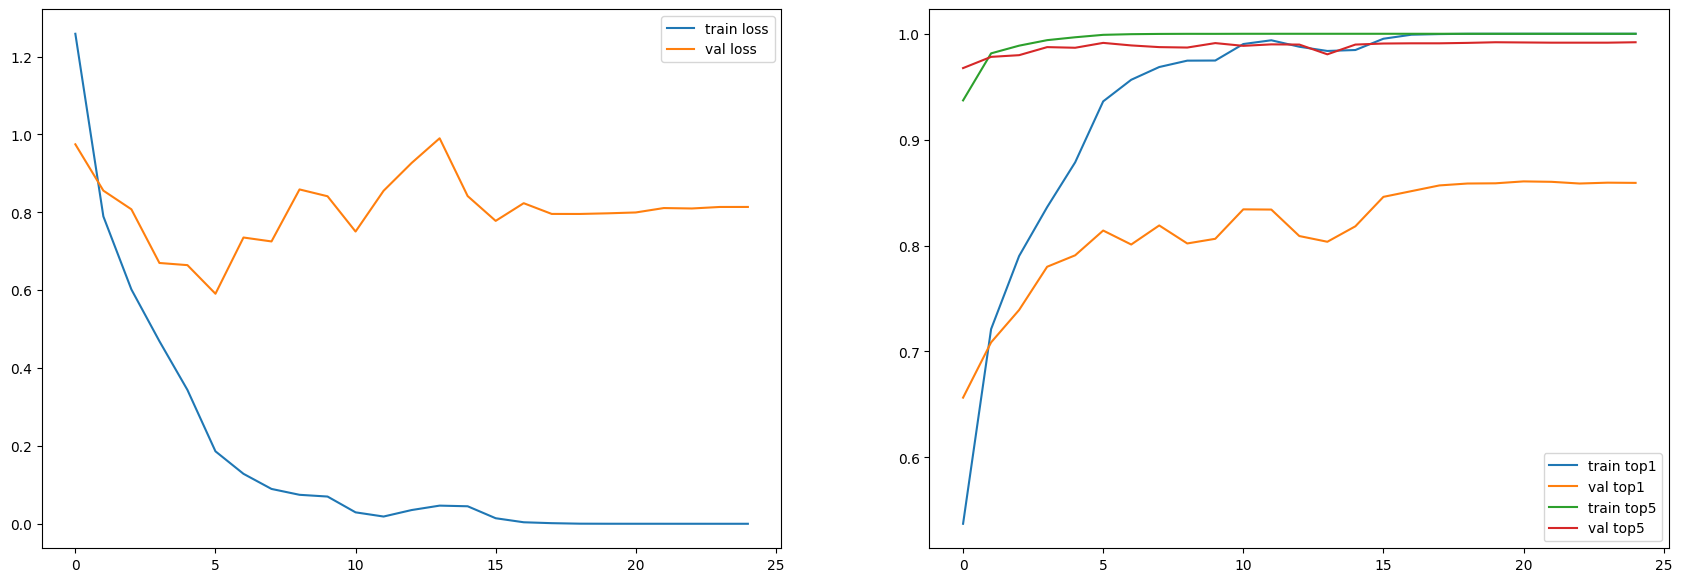

Loading checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/best_val_model.pth ...
Checkpoint loaded.
++> Evaluate at epoch 25 ...


Eval Loss: 0.941994: : 100% 10000/10000 [00:12<00:00, 777.44it/s]

++> Evaluate epoch 25 Finished.
RESULTS FROM RUN 0 fro CHECKPOINT best_val_model:
 {'loss': 0.8508718115091324, 'top1': 0.8505999999999997, 'top5': 0.9908999999999999}
Loading checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/last_model.pth ...


Checkpoint loaded.
++> Evaluate at epoch 25 ...


Eval Loss: 0.974361: : 100% 10000/10000 [00:12<00:00, 772.28it/s]

++> Evaluate epoch 25 Finished.


RESULTS FROM RUN 0 fro CHECKPOINT last_model:
 {'loss': 0.869401046037674, 'top1': 0.8493999999999999, 'top5': 0.9914999999999998}
ConvNet(
  (layers): ModuleList(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Dropout(p=0.0, inplace=False)
    (5): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Dropout(p=0.0, inplace=False)
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, d

Train Epoch: 1 Loss: 0.957554: : 100% 45000/45000 [00:22<00:00, 1965.33it/s]

==> Finished Epoch 1/25.
++> Evaluate at epoch 1 ...



Eval Loss: 1.007391: : 100% 5000/5000 [00:05<00:00, 884.57it/s]

++> Evaluate epoch 1 Finished.
eval_top1 Metric improved: -inf -> 0.6439999999999999. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 1
    loss           : 1.297405027548472
    top1           : 0.523
    top5           : 0.9335555555555556
    eval_loss      : 1.0178628277778625
    eval_top1      : 0.6439999999999999
    eval_top5      : 0.9662000000000001
==> Start Training Epoch 2/25, lr=0.002000 


Train Epoch: 2 Loss: 0.694936: : 100% 45000/45000 [00:24<00:00, 1863.54it/s]

==> Finished Epoch 2/25.
++> Evaluate at epoch 2 ...



Eval Loss: 0.857273: : 100% 5000/5000 [00:05<00:00, 912.59it/s]

++> Evaluate epoch 2 Finished.
eval_top1 Metric improved: 0.6439999999999999 -> 0.7166. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 2
    loss           : 0.8155273424254523
    top1           : 0.7100666666666668
    top5           : 0.9798888888888904
    eval_loss      : 0.8184661817550659
    eval_top1      : 0.7166
    eval_top5      : 0.9798000000000002
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/E2_model.pth ...
Checkpoint saved.
==> Start Training Epoch 3/25, lr=0.002000 


Train Epoch: 3 Loss: 0.722041: : 100% 45000/45000 [00:23<00:00, 1893.81it/s]

==> Finished Epoch 3/25.


++> Evaluate at epoch 3 ...


Eval Loss: 0.822472: : 100% 5000/5000 [00:05<00:00, 888.85it/s]

++> Evaluate epoch 3 Finished.
eval_top1 Metric improved: 0.7166 -> 0.7573999999999999. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 3
    loss           : 0.6220531185468038
    top1           : 0.7832666666666669
    top5           : 0.9878888888888903
    eval_loss      : 0.724284884929657
    eval_top1      : 0.7573999999999999
    eval_top5      : 0.9833999999999999
==> Start Training Epoch 4/25, lr=0.002000 


Train Epoch: 4 Loss: 0.441529: : 100% 45000/45000 [00:23<00:00, 1924.40it/s]

==> Finished Epoch 4/25.
++> Evaluate at epoch 4 ...



Eval Loss: 0.717377: : 100% 5000/5000 [00:05<00:00, 922.05it/s] 

++> Evaluate epoch 4 Finished.


eval_top1 Metric improved: 0.7573999999999999 -> 0.7585999999999999. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/best_val_model.pth ...
Checkpoint saved.
    epoch          : 4
    loss           : 0.4814107384946611
    top1           : 0.8330222222222223
    top5           : 0.9931777777777799
    eval_loss      : 0.7099413990974426
    eval_top1      : 0.7585999999999999
    eval_top5      : 0.9882
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/E4_model.pth ...
Checkpoint saved.
==> Start Training Epoch 5/25, lr=0.002000 


Train Epoch: 5 Loss: 0.322484: : 100% 45000/45000 [00:24<00:00, 1864.20it/s]

==> Finished Epoch 5/25.
++> Evaluate at epoch 5 ...



Eval Loss: 0.662236: : 100% 5000/5000 [00:05<00:00, 909.42it/s]

++> Evaluate epoch 5 Finished.
eval_top1 Metric improved: 0.7585999999999999 -> 0.7774. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 5
    loss           : 0.3620889921320809
    top1           : 0.8742666666666665
    top5           : 0.9959777777777798
    eval_loss      : 0.6732807445526123
    eval_top1      : 0.7774
    eval_top5      : 0.9871999999999997
==> Start Training Epoch 6/25, lr=0.001600 


Train Epoch: 6 Loss: 0.178248: : 100% 45000/45000 [00:22<00:00, 1984.15it/s]

==> Finished Epoch 6/25.
++> Evaluate at epoch 6 ...



Eval Loss: 0.643844: : 100% 5000/5000 [00:05<00:00, 930.20it/s] 

++> Evaluate epoch 6 Finished.
eval_top1 Metric improved: 0.7774 -> 0.8041999999999999. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 6
    loss           : 0.21362842324707243
    top1           : 0.9254888888888886
    top5           : 0.998511111111112
    eval_loss      : 0.6503265345096588
    eval_top1      : 0.8041999999999999
    eval_top5      : 0.9884000000000001
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/E6_model.pth ...
Checkpoint saved.
==> Start Training Epoch 7/25, lr=0.001600 


Train Epoch: 7 Loss: 0.249190: : 100% 45000/45000 [00:22<00:00, 2006.95it/s]

==> Finished Epoch 7/25.
++> Evaluate at epoch 7 ...



Eval Loss: 0.743057: : 100% 5000/5000 [00:05<00:00, 877.63it/s]

++> Evaluate epoch 7 Finished.
eval_top1 Metric improved: 0.8041999999999999 -> 0.8072. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 7
    loss           : 0.14116884330908458
    top1           : 0.9506444444444434
    top5           : 0.9995111111111115
    eval_loss      : 0.6962827944755554
    eval_top1      : 0.8072
    eval_top5      : 0.9896
==> Start Training Epoch 8/25, lr=0.001600 


Train Epoch: 8 Loss: 0.141418: : 100% 45000/45000 [00:22<00:00, 1979.61it/s]

==> Finished Epoch 8/25.
++> Evaluate at epoch 8 ...



Eval Loss: 0.878355: : 100% 5000/5000 [00:05<00:00, 848.83it/s]

++> Evaluate epoch 8 Finished.
    epoch          : 8
    loss           : 0.10044075581762525
    top1           : 0.9654444444444443
    top5           : 0.9998888888888889
    eval_loss      : 0.9468952560424805


    eval_top1      : 0.7818
    eval_top5      : 0.9821999999999999
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/E8_model.pth ...
Checkpoint saved.
==> Start Training Epoch 9/25, lr=0.001600 


Train Epoch: 9 Loss: 0.183994: : 100% 45000/45000 [00:23<00:00, 1943.94it/s]

==> Finished Epoch 9/25.
++> Evaluate at epoch 9 ...



Eval Loss: 0.756990: : 100% 5000/5000 [00:05<00:00, 880.73it/s]

++> Evaluate epoch 9 Finished.
    epoch          : 9
    loss           : 0.08185766977568468
    top1           : 0.9708666666666669
    top5           : 0.9999555555555556
    eval_loss      : 0.8057899856567383
    eval_top1      : 0.805
    eval_top5      : 0.9905999999999999
==> Start Training Epoch 10/25, lr=0.001600 



Train Epoch: 10 Loss: 0.085682: : 100% 45000/45000 [00:22<00:00, 2031.16it/s]

==> Finished Epoch 10/25.
++> Evaluate at epoch 10 ...



Eval Loss: 1.157483: : 100% 5000/5000 [00:06<00:00, 800.06it/s] 

++> Evaluate epoch 10 Finished.
    epoch          : 10
    loss           : 0.07432901448673672
    top1           : 0.9734222222222223
    top5           : 0.9999777777777777
    eval_loss      : 1.1045854210853576
    eval_top1      : 0.7667999999999998
    eval_top5      : 0.9815999999999999


Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/E10_model.pth ...
Checkpoint saved.
==> Start Training Epoch 11/25, lr=0.001280 


Train Epoch: 11 Loss: 0.026404: : 100% 45000/45000 [00:22<00:00, 2036.58it/s]

==> Finished Epoch 11/25.
++> Evaluate at epoch 11 ...



Eval Loss: 0.712556: : 100% 5000/5000 [00:06<00:00, 780.32it/s] 

++> Evaluate epoch 11 Finished.
eval_top1 Metric improved: 0.8072 -> 0.831. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 11
    loss           : 0.032228717704614
    top1           : 0.989066666666669
    top5           : 1.0
    eval_loss      : 0.7707350373268127
    eval_top1      : 0.831
    eval_top5      : 0.9923999999999996
==> Start Training Epoch 12/25, lr=0.001280 


Train Epoch: 12 Loss: 0.016097: : 100% 45000/45000 [00:22<00:00, 2033.16it/s]

==> Finished Epoch 12/25.
++> Evaluate at epoch 12 ...



Eval Loss: 0.809353: : 100% 5000/5000 [00:06<00:00, 745.01it/s]

++> Evaluate epoch 12 Finished.
eval_top1 Metric improved: 0.831 -> 0.8332. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 12
    loss           : 0.015016329679638148
    top1           : 0.9954000000000021
    top5           : 1.0
    eval_loss      : 0.7980011534690857
    eval_top1      : 0.8332
    eval_top5      : 0.9902
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/E12_model.pth ...
Checkpoint saved.
==> Start Training Epoch 13/25, lr=0.001280 


Train Epoch: 13 Loss: 0.125215: : 100% 45000/45000 [00:21<00:00, 2066.99it/s]

==> Finished Epoch 13/25.
++> Evaluate at epoch 13 ...



Eval Loss: 0.852376: : 100% 5000/5000 [00:06<00:00, 733.42it/s]

++> Evaluate epoch 13 Finished.
    epoch          : 13
    loss           : 0.024303657805754077
    top1           : 0.9918000000000016
    top5           : 0.9999777777777777
    eval_loss      : 0.8058747124671936
    eval_top1      : 0.8269999999999998


    eval_top5      : 0.9888000000000001
==> Start Training Epoch 14/25, lr=0.001280 


Train Epoch: 14 Loss: 0.092971: : 100% 45000/45000 [00:21<00:00, 2067.71it/s]

==> Finished Epoch 14/25.
++> Evaluate at epoch 14 ...



Eval Loss: 0.831388: : 100% 5000/5000 [00:06<00:00, 722.46it/s]

++> Evaluate epoch 14 Finished.
    epoch          : 14
    loss           : 0.056334252949390144
    top1           : 0.9808888888888888
    top5           : 1.0
    eval_loss      : 1.0615441250801085


    eval_top1      : 0.7908
    eval_top5      : 0.9853999999999998
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/E14_model.pth ...
Checkpoint saved.
==> Start Training Epoch 15/25, lr=0.001280 


Train Epoch: 15 Loss: 0.033848: : 100% 45000/45000 [00:21<00:00, 2121.56it/s]

==> Finished Epoch 15/25.
++> Evaluate at epoch 15 ...



Eval Loss: 0.778547: : 100% 5000/5000 [00:06<00:00, 730.19it/s]

++> Evaluate epoch 15 Finished.
    epoch          : 15
    loss           : 0.048360539513329664
    top1           : 0.9833555555555564
    top5           : 0.9999555555555556
    eval_loss      : 0.8206711173057556
    eval_top1      : 0.8325999999999999
    eval_top5      : 0.99
==> Start Training Epoch 16/25, lr=0.001024 



Train Epoch: 16 Loss: 0.002655: : 100% 45000/45000 [00:21<00:00, 2100.36it/s]

==> Finished Epoch 16/25.
++> Evaluate at epoch 16 ...



Eval Loss: 0.498569: : 100% 5000/5000 [00:07<00:00, 710.34it/s]

++> Evaluate epoch 16 Finished.
eval_top1 Metric improved: 0.8332 -> 0.8515999999999998. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 16
    loss           : 0.016054659474434123
    top1           : 0.9949555555555568
    top5           : 1.0
    eval_loss      : 0.7791134738922119
    eval_top1      : 0.8515999999999998
    eval_top5      : 0.9932
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/E16_model.pth ...
Checkpoint saved.
==> Start Training Epoch 17/25, lr=0.001024 


Train Epoch: 17 Loss: 0.000645: : 100% 45000/45000 [00:21<00:00, 2089.65it/s]

==> Finished Epoch 17/25.
++> Evaluate at epoch 17 ...



Eval Loss: 0.541182: : 100% 5000/5000 [00:07<00:00, 701.30it/s]

++> Evaluate epoch 17 Finished.
    epoch          : 17
    loss           : 0.0027658296254877415
    top1           : 0.9994888888888891
    top5           : 1.0
    eval_loss      : 0.7782118606567383


    eval_top1      : 0.8497999999999998
    eval_top5      : 0.9929999999999997
==> Start Training Epoch 18/25, lr=0.001024 


Train Epoch: 18 Loss: 0.001007: : 100% 45000/45000 [00:21<00:00, 2121.86it/s]

==> Finished Epoch 18/25.


++> Evaluate at epoch 18 ...


Eval Loss: 0.580755: : 100% 5000/5000 [00:07<00:00, 705.94it/s]

++> Evaluate epoch 18 Finished.
    epoch          : 18
    loss           : 0.0025318615248478534
    top1           : 0.9993777777777783
    top5           : 1.0


    eval_loss      : 0.832732892036438
    eval_top1      : 0.8442000000000002
    eval_top5      : 0.9925999999999998
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/E18_model.pth ...
Checkpoint saved.
==> Start Training Epoch 19/25, lr=0.001024 


Train Epoch: 19 Loss: 0.013882: : 100% 45000/45000 [00:21<00:00, 2065.13it/s]

==> Finished Epoch 19/25.
++> Evaluate at epoch 19 ...



Eval Loss: 1.009815: : 100% 5000/5000 [00:07<00:00, 703.24it/s]

++> Evaluate epoch 19 Finished.
    epoch          : 19
    loss           : 0.0061256989738386535
    top1           : 0.9982888888888902
    top5           : 1.0
    eval_loss      : 0.9889890789985657
    eval_top1      : 0.8188000000000001
    eval_top5      : 0.9900000000000001
==> Start Training Epoch 20/25, lr=0.001024 



Train Epoch: 20 Loss: 0.132301: : 100% 45000/45000 [00:21<00:00, 2108.18it/s]

==> Finished Epoch 20/25.
++> Evaluate at epoch 20 ...



Eval Loss: 1.124691: : 100% 5000/5000 [00:07<00:00, 711.26it/s]

++> Evaluate epoch 20 Finished.
    epoch          : 20
    loss           : 0.06386867861366934
    top1           : 0.9778000000000001
    top5           : 1.0
    eval_loss      : 1.2317203378677368
    eval_top1      : 0.7753999999999999
    eval_top5      : 0.9823999999999998
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/E20_model.pth ...


Checkpoint saved.
==> Start Training Epoch 21/25, lr=0.000819 


Train Epoch: 21 Loss: 0.012249: : 100% 45000/45000 [00:21<00:00, 2109.90it/s]

==> Finished Epoch 21/25.
++> Evaluate at epoch 21 ...



Eval Loss: 0.896579: : 100% 5000/5000 [00:07<00:00, 710.68it/s]

++> Evaluate epoch 21 Finished.
    epoch          : 21


    loss           : 0.027235744091578657
    top1           : 0.9908000000000025
    top5           : 1.0
    eval_loss      : 0.882376856803894
    eval_top1      : 0.8353999999999998
    eval_top5      : 0.9895999999999999
==> Start Training Epoch 22/25, lr=0.000819 


Train Epoch: 22 Loss: 0.001289: : 100% 45000/45000 [00:21<00:00, 2084.48it/s]

==> Finished Epoch 22/25.
++> Evaluate at epoch 22 ...



Eval Loss: 0.717597: : 100% 5000/5000 [00:07<00:00, 701.82it/s]

++> Evaluate epoch 22 Finished.
    epoch          : 22
    loss           : 0.006405258587716768
    top1           : 0.9982888888888897
    top5           : 1.0
    eval_loss      : 0.8163175702095031
    eval_top1      : 0.8442000000000001
    eval_top5      : 0.9914000000000001
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/E22_model.pth ...


Checkpoint saved.
==> Start Training Epoch 23/25, lr=0.000819 


Train Epoch: 23 Loss: 0.001028: : 100% 45000/45000 [00:21<00:00, 2099.37it/s]

==> Finished Epoch 23/25.


++> Evaluate at epoch 23 ...


Eval Loss: 0.672874: : 100% 5000/5000 [00:07<00:00, 707.48it/s]

++> Evaluate epoch 23 Finished.
eval_top1 Metric improved: 0.8515999999999998 -> 0.8541999999999997. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 23
    loss           : 0.0015660392815091957
    top1           : 0.9997555555555555
    top5           : 1.0
    eval_loss      : 0.7977768135070801
    eval_top1      : 0.8541999999999997
    eval_top5      : 0.9921999999999999
==> Start Training Epoch 24/25, lr=0.000819 


Train Epoch: 24 Loss: 0.000290: : 100% 45000/45000 [00:21<00:00, 2061.32it/s]

==> Finished Epoch 24/25.
++> Evaluate at epoch 24 ...



Eval Loss: 0.719715: : 100% 5000/5000 [00:07<00:00, 695.78it/s]

++> Evaluate epoch 24 Finished.
eval_top1 Metric improved: 0.8541999999999997 -> 0.8555999999999999. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 24
    loss           : 0.00034621099967302546
    top1           : 1.0
    top5           : 1.0
    eval_loss      : 0.8053175401687622
    eval_top1      : 0.8555999999999999
    eval_top5      : 0.9908000000000001
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/E24_model.pth ...
Checkpoint saved.
==> Start Training Epoch 25/25, lr=0.000819 


Train Epoch: 25 Loss: 0.000117: : 100% 45000/45000 [00:21<00:00, 2056.20it/s]

==> Finished Epoch 25/25.
++> Evaluate at epoch 25 ...



Eval Loss: 0.713778: : 100% 5000/5000 [00:07<00:00, 703.50it/s]

++> Evaluate epoch 25 Finished.
    epoch          : 25
    loss           : 0.00021919793289271183


    top1           : 1.0
    top5           : 1.0
    eval_loss      : 0.8158643984794617
    eval_top1      : 0.8548
    eval_top5      : 0.9917999999999999
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/last_model.pth ...
Checkpoint saved.


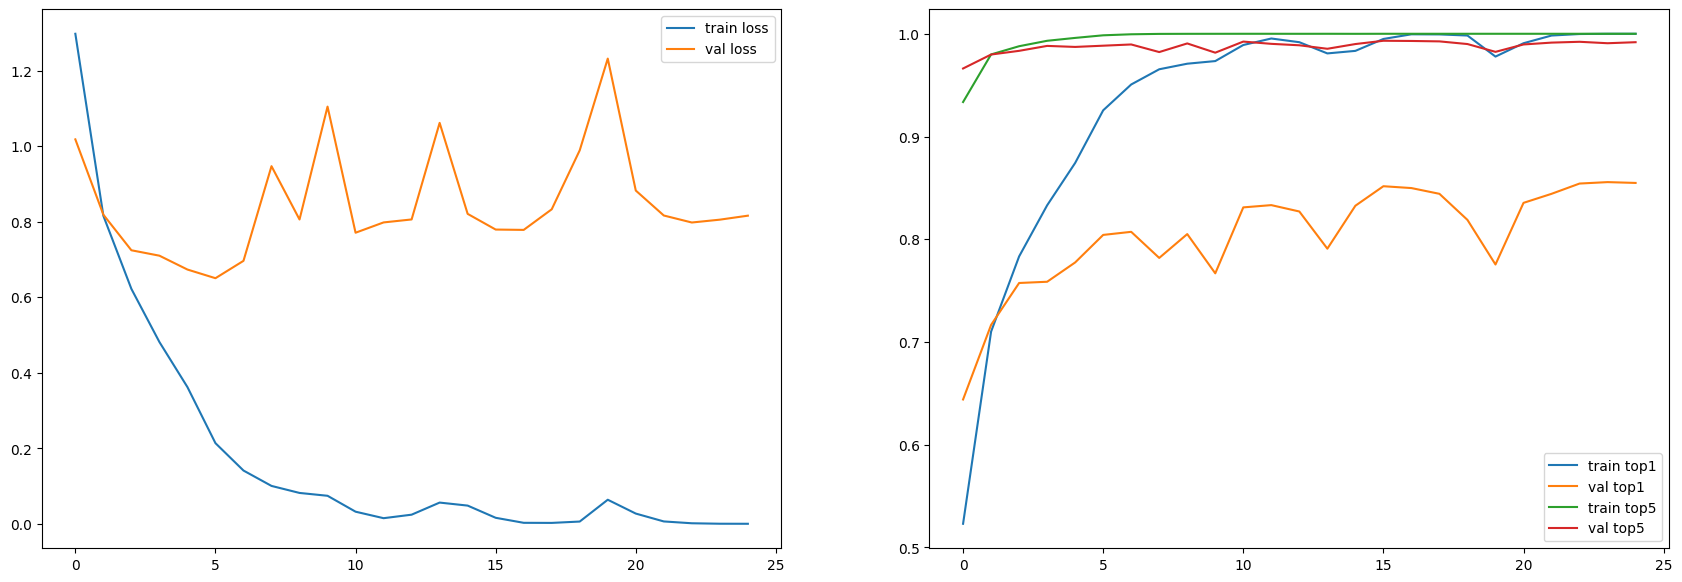

Loading checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/best_val_model.pth ...
Checkpoint loaded.
++> Evaluate at epoch 25 ...


Eval Loss: 0.927019: : 100% 10000/10000 [00:12<00:00, 783.38it/s]

++> Evaluate epoch 25 Finished.
RESULTS FROM RUN 1 fro CHECKPOINT best_val_model:
 {'loss': 0.8667220705747605, 'top1': 0.845, 'top5': 0.9904999999999999}
Loading checkpoint: ../../saved/models/CIFAR10_CNN/exp_2b/last_model.pth ...


Checkpoint loaded.
++> Evaluate at epoch 25 ...


Eval Loss: 0.925901: : 100% 10000/10000 [00:12<00:00, 796.98it/s]

++> Evaluate epoch 25 Finished.


RESULTS FROM RUN 1 fro CHECKPOINT last_model:
 {'loss': 0.873816260099411, 'top1': 0.8459999999999996, 'top5': 0.9910999999999999}


In [7]:
run_id = 'exp_2b' 
config = ConfigParser.wo_args(config='cfgs/exercise-3/cnn_cifar10.json', root_dir=PROJECT_ROOT, run_id=run_id)
config["trainer"]["epochs"] = 25
config["arch"]["args"]["norm_layer"]["type"] = "BatchNorm2d"

for run in range(2):
    trainer_cnn = CNNTrainer(config=config, train_loader=train_data_loader, eval_loader=valid_data_loader)

    #train
    logs = trainer_cnn.train()

    plot_logs(logs)
    #evaluate
    for checkpoint_name in ["best_val_model", "last_model"]:
        path = ospj(PROJECT_ROOT, f'saved/models/CIFAR10_CNN/{run_id}/{checkpoint_name}.pth')
        trainer_cnn.load_model(path=path)
        result = trainer_cnn.evaluate(loader=test_loader)

        print(f"RESULTS FROM RUN {run} fro CHECKPOINT {checkpoint_name}:\n", result)

Wirte your report for Q2.b in this cell. Feel free to add extra code cells

*   **We did 2 independent runs to see if the performance of the best model is better than the performance of the last model saved. The best model is saved based on the highest val_top1 score.** 
    1. **In the first run the test loss of the best model was 0.85 while the test loss of the last model was 0.86 indicating that the last model is more overfitted as compared to the best model**  
    2.   **Similarly in the second run the test loss for best model was 0.86 while the loss for the last model was 0.87**
*   **The both runs the best model has 10% lower loss as compared to last model indicating that saving best model based on top1_accuracy score helps with reducing overfitting.**







c) While in part `b` we save the best model, we still do as many epochs as indicated in the config file. This is not convenient as the overfitting steps are wasting time and compute and also wouldn't affect the best model. Hence, Early Stopping can be helpful, where we **stop** the training after a few non-improving steps! Early stopping logic should be considered after every training epoch is finished, to see if we should do more epochs or not. Therefore, the logic should should be implemented in `train` method in `base_trainer.py` (which takes care of running multiple epochs). You need to implement it at the end of the loop over epochs.

Once implemented, you need to change the config file to enable early stopping. You can either modify `cfgs/exercise-3/cnn_cifar10.json` directly or simply create a copy at the same place under a different name and parse that config instead. Within the config file, modify the following "trainer" configs:
```JSON
{
    ...
    "trainer":{
        ...
        "monitor": "max eval_top1",
        "early_stop": 0 -> change to 4
    }
}
```
This will enable the early stopping to be considered for `eval_top1` metric and the maximum number of non-improving steps will be set to 4.

Re-run one of the experiments from part `b` that the best epoch was way lower than the total number of epochs, and see if early stopping can prevent unnecessary training epochs.

NumExpr defaulting to 2 threads.
ConvNet(
  (layers): ModuleList(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Dropout(p=0.0, inplace=False)
    (5): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Dropout(p=0.0, inplace=False)
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): ReLU()
    (14): Dropout(p=0.0, inplace=False)
    (15): Con

Train Epoch: 1 Loss: 0.840555: : 100% 45000/45000 [00:23<00:00, 1877.66it/s]

==> Finished Epoch 1/50.
++> Evaluate at epoch 1 ...



Eval Loss: 0.993526: : 100% 5000/5000 [00:06<00:00, 785.63it/s]

++> Evaluate epoch 1 Finished.
eval_top1 Metric improved: -inf -> 0.6192000000000001. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2c/best_val_model.pth ...


Checkpoint saved.
    epoch          : 1
    loss           : 1.2927769743071662
    top1           : 0.5223111111111114
    top5           : 0.9342000000000004
    eval_loss      : 1.0640526342391967
    eval_top1      : 0.6192000000000001
    eval_top5      : 0.9605999999999998
==> Start Training Epoch 2/50, lr=0.002000 


Train Epoch: 2 Loss: 0.797437: : 100% 45000/45000 [00:23<00:00, 1928.49it/s]

==> Finished Epoch 2/50.
++> Evaluate at epoch 2 ...



Eval Loss: 0.661185: : 100% 5000/5000 [00:07<00:00, 698.49it/s]

++> Evaluate epoch 2 Finished.
eval_top1 Metric improved: 0.6192000000000001 -> 0.7358000000000001. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2c/best_val_model.pth ...


Checkpoint saved.
    epoch          : 2
    loss           : 0.8204408982064989
    top1           : 0.7085333333333332
    top5           : 0.9794444444444455
    eval_loss      : 0.7702157998085022
    eval_top1      : 0.7358000000000001
    eval_top5      : 0.9803999999999998
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2c/E2_model.pth ...
Checkpoint saved.
==> Start Training Epoch 3/50, lr=0.002000 


Train Epoch: 3 Loss: 0.504440: : 100% 45000/45000 [00:23<00:00, 1908.60it/s]

==> Finished Epoch 3/50.
++> Evaluate at epoch 3 ...



Eval Loss: 0.711436: : 100% 5000/5000 [00:07<00:00, 662.98it/s]

++> Evaluate epoch 3 Finished.
eval_top1 Metric improved: 0.7358000000000001 -> 0.7569999999999999. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2c/best_val_model.pth ...


Checkpoint saved.
    epoch          : 3
    loss           : 0.6221271203623877
    top1           : 0.7819777777777777
    top5           : 0.9881333333333351
    eval_loss      : 0.7286638069152832
    eval_top1      : 0.7569999999999999
    eval_top5      : 0.9832
==> Start Training Epoch 4/50, lr=0.002000 


Train Epoch: 4 Loss: 0.541423: : 100% 45000/45000 [00:22<00:00, 2030.21it/s]

==> Finished Epoch 4/50.
++> Evaluate at epoch 4 ...



Eval Loss: 0.547538: : 100% 5000/5000 [00:07<00:00, 676.11it/s]

++> Evaluate epoch 4 Finished.
eval_top1 Metric improved: 0.7569999999999999 -> 0.7879999999999999. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2c/best_val_model.pth ...


Checkpoint saved.
    epoch          : 4
    loss           : 0.4766852111286587
    top1           : 0.8351999999999996
    top5           : 0.9928666666666683
    eval_loss      : 0.6439196503162384
    eval_top1      : 0.7879999999999999
    eval_top5      : 0.9892
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2c/E4_model.pth ...
Checkpoint saved.
==> Start Training Epoch 5/50, lr=0.002000 


Train Epoch: 5 Loss: 0.327449: : 100% 45000/45000 [00:21<00:00, 2102.20it/s]

==> Finished Epoch 5/50.
++> Evaluate at epoch 5 ...



Eval Loss: 0.670528: : 100% 5000/5000 [00:07<00:00, 699.39it/s]

++> Evaluate epoch 5 Finished.
    epoch          : 5
    loss           : 0.36311409215132395
    top1           : 0.8727555555555558
    top5           : 0.996133333333335
    eval_loss      : 0.7142416119575501
    eval_top1      : 0.7664000000000002
    eval_top5      : 0.9887999999999999
==> Start Training Epoch 6/50, lr=0.001600 



Train Epoch: 6 Loss: 0.172607: : 100% 45000/45000 [00:21<00:00, 2099.85it/s]

==> Finished Epoch 6/50.


++> Evaluate at epoch 6 ...


Eval Loss: 0.697048: : 100% 5000/5000 [00:07<00:00, 685.11it/s]

++> Evaluate epoch 6 Finished.
eval_top1 Metric improved: 0.7879999999999999 -> 0.8107999999999999. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2c/best_val_model.pth ...


Checkpoint saved.
    epoch          : 6
    loss           : 0.21193389299843046
    top1           : 0.926711111111111
    top5           : 0.9987777777777787
    eval_loss      : 0.6418073153495789
    eval_top1      : 0.8107999999999999
    eval_top5      : 0.9924000000000001
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2c/E6_model.pth ...
Checkpoint saved.
==> Start Training Epoch 7/50, lr=0.001600 


Train Epoch: 7 Loss: 0.193679: : 100% 45000/45000 [00:21<00:00, 2078.56it/s]

==> Finished Epoch 7/50.
++> Evaluate at epoch 7 ...



Eval Loss: 0.712667: : 100% 5000/5000 [00:07<00:00, 702.60it/s]

++> Evaluate epoch 7 Finished.
    epoch          : 7
    loss           : 0.138787735518482
    top1           : 0.9530222222222223
    top5           : 0.9996666666666669
    eval_loss      : 0.6741650915145874
    eval_top1      : 0.8082
    eval_top5      : 0.9904
==> Start Training Epoch 8/50, lr=0.001600 



Train Epoch: 8 Loss: 0.156725: : 100% 45000/45000 [00:21<00:00, 2134.71it/s]


==> Finished Epoch 8/50.
++> Evaluate at epoch 8 ...


Eval Loss: 0.743258: : 100% 5000/5000 [00:07<00:00, 701.58it/s]

++> Evaluate epoch 8 Finished.
eval_top1 Metric improved: 0.8107999999999999 -> 0.8124000000000001. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2c/best_val_model.pth ...


Checkpoint saved.
    epoch          : 8
    loss           : 0.1029187035229471
    top1           : 0.9643777777777774
    top5           : 0.9998222222222224
    eval_loss      : 0.7219787287712097
    eval_top1      : 0.8124000000000001
    eval_top5      : 0.9873999999999996
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2c/E8_model.pth ...
Checkpoint saved.
==> Start Training Epoch 9/50, lr=0.001600 


Train Epoch: 9 Loss: 0.132580: : 100% 45000/45000 [00:21<00:00, 2135.18it/s]

==> Finished Epoch 9/50.
++> Evaluate at epoch 9 ...



Eval Loss: 0.746221: : 100% 5000/5000 [00:07<00:00, 700.80it/s]

++> Evaluate epoch 9 Finished.
    epoch          : 9
    loss           : 0.08101532486577828
    top1           : 0.9727777777777779
    top5           : 0.9999333333333333
    eval_loss      : 0.8065731739997863
    eval_top1      : 0.8036
    eval_top5      : 0.9878
==> Start Training Epoch 10/50, lr=0.001600 



Train Epoch: 10 Loss: 0.103174: : 100% 45000/45000 [00:20<00:00, 2167.89it/s]


==> Finished Epoch 10/50.
++> Evaluate at epoch 10 ...


Eval Loss: 0.796866: : 100% 5000/5000 [00:06<00:00, 728.85it/s]

++> Evaluate epoch 10 Finished.
    epoch          : 10
    loss           : 0.07324528141154184
    top1           : 0.9744666666666666
    top5           : 0.9999777777777777
    eval_loss      : 1.0106059956550597
    eval_top1      : 0.7916
    eval_top5      : 0.9880000000000001
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2c/E10_model.pth ...


Checkpoint saved.
==> Start Training Epoch 11/50, lr=0.001280 


Train Epoch: 11 Loss: 0.037360: : 100% 45000/45000 [00:21<00:00, 2132.92it/s]

==> Finished Epoch 11/50.


++> Evaluate at epoch 11 ...


Eval Loss: 0.549290: : 100% 5000/5000 [00:06<00:00, 800.87it/s]

++> Evaluate epoch 11 Finished.
eval_top1 Metric improved: 0.8124000000000001 -> 0.8375999999999999. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2c/best_val_model.pth ...


Checkpoint saved.
    epoch          : 11
    loss           : 0.030726199574354622
    top1           : 0.9898666666666686
    top5           : 0.9999777777777777
    eval_loss      : 0.7420374083518982
    eval_top1      : 0.8375999999999999
    eval_top5      : 0.9934000000000002
==> Start Training Epoch 12/50, lr=0.001280 


Train Epoch: 12 Loss: 0.002978: : 100% 45000/45000 [00:21<00:00, 2077.81it/s]

==> Finished Epoch 12/50.
++> Evaluate at epoch 12 ...



Eval Loss: 0.501808: : 100% 5000/5000 [00:05<00:00, 835.95it/s]

++> Evaluate epoch 12 Finished.
eval_top1 Metric improved: 0.8375999999999999 -> 0.8416. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2c/best_val_model.pth ...


Checkpoint saved.
    epoch          : 12
    loss           : 0.012235692733277877
    top1           : 0.9964888888888904
    top5           : 1.0
    eval_loss      : 0.7323362112045289
    eval_top1      : 0.8416
    eval_top5      : 0.991
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2c/E12_model.pth ...
Checkpoint saved.
==> Start Training Epoch 13/50, lr=0.001280 


Train Epoch: 13 Loss: 0.031572: : 100% 45000/45000 [00:21<00:00, 2085.37it/s]

==> Finished Epoch 13/50.
++> Evaluate at epoch 13 ...



Eval Loss: 0.955133: : 100% 5000/5000 [00:05<00:00, 923.76it/s]

++> Evaluate epoch 13 Finished.
    epoch          : 13
    loss           : 0.02146397558765279
    top1           : 0.993288888888891
    top5           : 1.0
    eval_loss      : 0.9379901504516601
    eval_top1      : 0.8138
    eval_top5      : 0.9885999999999998
==> Start Training Epoch 14/50, lr=0.001280 



Train Epoch: 14 Loss: 0.059204: : 100% 45000/45000 [00:22<00:00, 1967.28it/s]

==> Finished Epoch 14/50.
++> Evaluate at epoch 14 ...



Eval Loss: 0.846071: : 100% 5000/5000 [00:05<00:00, 914.88it/s]

++> Evaluate epoch 14 Finished.
    epoch          : 14
    loss           : 0.06182983166227738
    top1           : 0.9783777777777785
    top5           : 0.9999333333333333
    eval_loss      : 0.8848001456260681
    eval_top1      : 0.8173999999999999
    eval_top5      : 0.9873999999999999
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2c/E14_model.pth ...


Checkpoint saved.
==> Start Training Epoch 15/50, lr=0.001280 


Train Epoch: 15 Loss: 0.047106: : 100% 45000/45000 [00:22<00:00, 2024.78it/s]

==> Finished Epoch 15/50.
++> Evaluate at epoch 15 ...



Eval Loss: 0.850485: : 100% 5000/5000 [00:05<00:00, 926.25it/s]

++> Evaluate epoch 15 Finished.
    epoch          : 15
    loss           : 0.04391254706929127
    top1           : 0.9849555555555567
    top5           : 1.0
    eval_loss      : 0.9189373421669006
    eval_top1      : 0.8198000000000002
    eval_top5      : 0.9883999999999997
==> Start Training Epoch 16/50, lr=0.001024 



Train Epoch: 16 Loss: 0.013001: : 100% 45000/45000 [00:22<00:00, 2015.04it/s]

==> Finished Epoch 16/50.
++> Evaluate at epoch 16 ...



Eval Loss: 0.826516: : 100% 5000/5000 [00:05<00:00, 934.01it/s]

++> Evaluate epoch 16 Finished.
eval_top1 Metric did not improve for 4 steps. Best value was 0.8416. Terminating training at epoch 16
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_2c/last_model.pth ...


Checkpoint saved.
Loading checkpoint: ../../saved/models/CIFAR10_CNN/exp_2c/best_val_model.pth ...
Checkpoint loaded.
++> Evaluate at epoch 16 ...


Eval Loss: 0.909781: : 100% 10000/10000 [00:12<00:00, 784.42it/s]

++> Evaluate epoch 16 Finished.


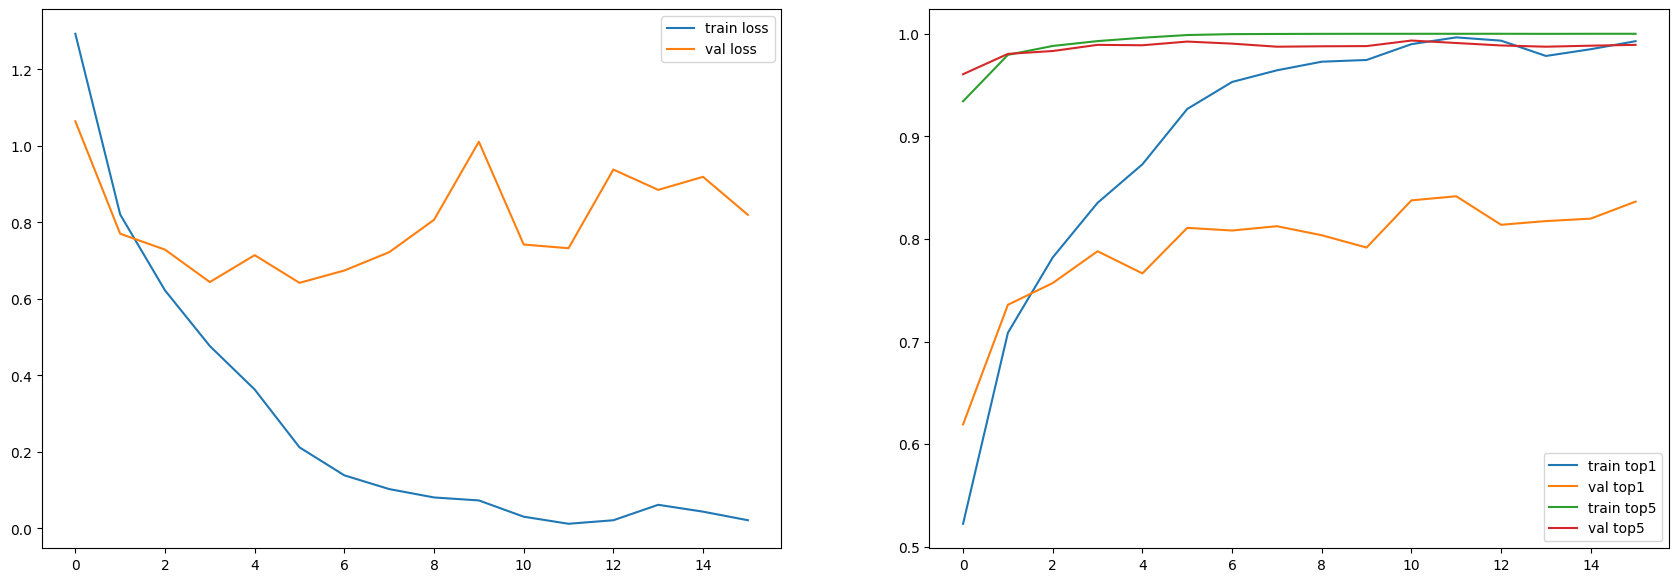

{'loss': 0.8004420202970505, 'top1': 0.8331000000000001, 'top5': 0.9888999999999999}


In [7]:
run_id = 'exp_2c' 

config = ConfigParser.wo_args(config='cfgs/exercise-3/cnn_cifar10.json', root_dir=PROJECT_ROOT, run_id=run_id)
config["trainer"]["epochs"] = 50
config["arch"]["args"]["norm_layer"]["type"] = "BatchNorm2d"
config["trainer"]["early_stop"] = 4

trainer_cnn = CNNTrainer(config=config, train_loader=train_data_loader, eval_loader=valid_data_loader)

#train
logs = trainer_cnn.train()

#evaluate
path = ospj(PROJECT_ROOT, f'saved/models/CIFAR10_CNN/{run_id}/best_val_model.pth')
trainer_cnn.load_model(path=path)
result = trainer_cnn.evaluate(loader=test_loader)

plot_logs(logs)
print(result)

Wirte your report for Q2.c in this cell. Feel free to add extra code cells

**Using early stopping based on top1_accuracy score with a tolerance of 4 epochs terminates the training after 16 epochs. This saves computation cost as we don't have to do 50 full epochs. Also we get similar validation accuarcy as the run which did 50 full epochs.**

### Question 3: Improve generalization of Convolutional Networks (10 points)

We saw in Q2 that the model can start over-fitting to the training set if we continue training for long. To prevent over-fitting, there are two main paradigms we can focus on. The first is to get more training data. This might be a difficult and expensive process involving significant. However, it is generally the most effective way to learn more general models. A cheaper alternative is to perform data augmentation. The second approach is to regularize the model. In the following sub-questions, we will experiment with each of these paradigms and measure the effect on the model generalization. We recommend disabling Early Stopping from previous question (simply removing it from config file) so that it does not interrupt your experiments with data augmentations and you maintain full control over number of epochs.

a) Data augmentation is the process of creating more training data by applying certain transformations to the training set images. Usually, the underlying assumption is that the label of the image does not change under the applied transformations. This includes geometric transformations like translation, rotation, scaling, flipping, random cropping, and color transformations like greyscale, colorjitter. For every image in the training batch, a random transformation is sampled from the possible ones (e.g., a random number of pixels to translate the image by) and is applied to the image. While designing the data input pipeline, we must choose the hyper-parameters for these transformations (e.g., limits of translation or rotation) based on things we expect to see in the test-set/real world. Your task in this question is to implement the data augmentation for the CIFAR-10 classification task. Many of these transformations are implemented in the `torchvision.transforms` package. Familiarize yourself with the APIs of these transforms, and functions to compose multiple transforms or randomly sample them. Next, implement geometric and color space data augmentations for the CIFAR-10 dataset, by choosing the right functions and order of application. Tune the hyper-parameters of these data augmentations to improve the validation performance. You will need to train the model a bit longer (20-30 epochs) with data augmentation, as the training data is effectively larger now. Discuss which augmentations work well for you in the report. (6 points)

In [14]:
run_id = "exp_3a"
config = ConfigParser.wo_args(config='cfgs/exercise-3/cnn_cifar10.json', root_dir=PROJECT_ROOT, run_id=run_id)
config["data_module"]["args"]["preset_name"] = "CIFAR10_AUTOAUGMENT"
config["arch"]["args"]["norm_layer"]["type"] = "BatchNorm2d"
config["trainer"]["epochs"] = 30

datamodule = config.init_obj('data_module', module_data,root_dir=PROJECT_ROOT)

train_data_loader = datamodule.get_loader()
valid_data_loader = datamodule.get_heldout_loader()

test_loader_args = deepcopy(config['data_module']['args']) #copy the args
test_loader_args['training']=False
test_loader_args['shuffle']=False
test_loader_args['heldout_split']=0.0

test_module = getattr(module_data, config['data_module']['type'])(root_dir=PROJECT_ROOT, **test_loader_args)
test_loader = test_module.get_loader()

transformations for split train are Compose(
    RandomHorizontalFlip(p=0.5)
    RandomCrop(size=(32, 32), padding=4)
    AutoAugment(policy=AutoAugmentPolicy.CIFAR10, fill=None)
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 1}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 1}
transformations for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 1}


ConvNet(
  (layers): ModuleList(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Dropout(p=0.0, inplace=False)
    (5): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Dropout(p=0.0, inplace=False)
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): ReLU()
    (14): Dropout(p=0.0, inplace=False)
    (15): Conv2d(512, 512, kernel_size=(3, 3),

Train Epoch: 1 Loss: 1.641782: : 100% 45000/45000 [00:47<00:00, 946.38it/s]

==> Finished Epoch 1/30.
++> Evaluate at epoch 1 ...



Eval Loss: 1.438625: : 100% 5000/5000 [00:07<00:00, 708.55it/s]

++> Evaluate epoch 1 Finished.
eval_top1 Metric improved: -inf -> 0.45360000000000006. Saving the best model


Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/best_val_model.pth ...
Checkpoint saved.
    epoch          : 1
    loss           : 1.7148652129703097
    top1           : 0.3684222222222223
    top5           : 0.8467999999999993
    eval_loss      : 1.4912551164627075
    eval_top1      : 0.45360000000000006
    eval_top5      : 0.8936
==> Start Training Epoch 2/30, lr=0.002000 


Train Epoch: 2 Loss: 1.230564: : 100% 45000/45000 [00:45<00:00, 980.73it/s]

==> Finished Epoch 2/30.
++> Evaluate at epoch 2 ...



Eval Loss: 1.285719: : 100% 5000/5000 [00:07<00:00, 627.43it/s]

++> Evaluate epoch 2 Finished.
eval_top1 Metric improved: 0.45360000000000006 -> 0.5580000000000002. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/best_val_model.pth ...


Checkpoint saved.
    epoch          : 2
    loss           : 1.2823689328299628
    top1           : 0.537622222222222
    top5           : 0.9270222222222222
    eval_loss      : 1.2338707637786865
    eval_top1      : 0.5580000000000002
    eval_top5      : 0.9384000000000001
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/E2_model.pth ...
Checkpoint saved.
==> Start Training Epoch 3/30, lr=0.002000 


Train Epoch: 3 Loss: 1.040489: : 100% 45000/45000 [00:46<00:00, 970.45it/s] 

==> Finished Epoch 3/30.
++> Evaluate at epoch 3 ...



Eval Loss: 0.952576: : 100% 5000/5000 [00:08<00:00, 598.33it/s]

++> Evaluate epoch 3 Finished.
eval_top1 Metric improved: 0.5580000000000002 -> 0.6346. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/best_val_model.pth ...


Checkpoint saved.
    epoch          : 3
    loss           : 1.0856644611888462
    top1           : 0.6144444444444447
    top5           : 0.9475333333333336
    eval_loss      : 1.0315690898895264
    eval_top1      : 0.6346
    eval_top5      : 0.9494000000000001
==> Start Training Epoch 4/30, lr=0.002000 


Train Epoch: 4 Loss: 0.866665: : 100% 45000/45000 [00:45<00:00, 987.73it/s] 

==> Finished Epoch 4/30.


++> Evaluate at epoch 4 ...


Eval Loss: 1.245902: : 100% 5000/5000 [00:08<00:00, 593.47it/s]

++> Evaluate epoch 4 Finished.
    epoch          : 4
    loss           : 0.9579967901441786
    top1           : 0.6622222222222218
    top5           : 0.9570444444444447
    eval_loss      : 1.1802291798591613
    eval_top1      : 0.6142000000000001
    eval_top5      : 0.9348000000000002
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/E4_model.pth ...


Checkpoint saved.
==> Start Training Epoch 5/30, lr=0.002000 


Train Epoch: 5 Loss: 0.779004: : 100% 45000/45000 [00:45<00:00, 990.20it/s] 

==> Finished Epoch 5/30.
++> Evaluate at epoch 5 ...



Eval Loss: 0.707127: : 100% 5000/5000 [00:06<00:00, 773.20it/s]

++> Evaluate epoch 5 Finished.
eval_top1 Metric improved: 0.6346 -> 0.6940000000000001. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/best_val_model.pth ...


Checkpoint saved.
    epoch          : 5
    loss           : 0.8881380841467116
    top1           : 0.6862666666666668
    top5           : 0.961844444444444
    eval_loss      : 0.8629655003547668
    eval_top1      : 0.6940000000000001
    eval_top5      : 0.9647999999999999
==> Start Training Epoch 6/30, lr=0.001600 


Train Epoch: 6 Loss: 0.818013: : 100% 45000/45000 [00:46<00:00, 957.88it/s] 

==> Finished Epoch 6/30.
++> Evaluate at epoch 6 ...



Eval Loss: 0.939954: : 100% 5000/5000 [00:06<00:00, 799.07it/s]

++> Evaluate epoch 6 Finished.
eval_top1 Metric improved: 0.6940000000000001 -> 0.6988. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/best_val_model.pth ...


Checkpoint saved.
    epoch          : 6
    loss           : 0.7951096489694384
    top1           : 0.7214444444444442
    top5           : 0.9695333333333332
    eval_loss      : 0.8627589201927185
    eval_top1      : 0.6988
    eval_top5      : 0.9577999999999999
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/E6_model.pth ...
Checkpoint saved.
==> Start Training Epoch 7/30, lr=0.001600 


Train Epoch: 7 Loss: 0.758054: : 100% 45000/45000 [00:46<00:00, 977.91it/s]

==> Finished Epoch 7/30.
++> Evaluate at epoch 7 ...



Eval Loss: 0.754891: : 100% 5000/5000 [00:07<00:00, 690.85it/s]

++> Evaluate epoch 7 Finished.
eval_top1 Metric improved: 0.6988 -> 0.7358. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/best_val_model.pth ...


Checkpoint saved.
    epoch          : 7
    loss           : 0.7527334960301717
    top1           : 0.7365333333333329
    top5           : 0.9712222222222232
    eval_loss      : 0.7793088912963867
    eval_top1      : 0.7358
    eval_top5      : 0.9718000000000002
==> Start Training Epoch 8/30, lr=0.001600 


Train Epoch: 8 Loss: 0.811753: : 100% 45000/45000 [00:45<00:00, 994.77it/s] 

==> Finished Epoch 8/30.


++> Evaluate at epoch 8 ...


Eval Loss: 0.736392: : 100% 5000/5000 [00:08<00:00, 604.65it/s]

++> Evaluate epoch 8 Finished.
eval_top1 Metric improved: 0.7358 -> 0.7408. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/best_val_model.pth ...


Checkpoint saved.
    epoch          : 8
    loss           : 0.711018893983629
    top1           : 0.7526444444444444
    top5           : 0.9742222222222221
    eval_loss      : 0.7444239282608032
    eval_top1      : 0.7408
    eval_top5      : 0.9747999999999999
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/E8_model.pth ...
Checkpoint saved.
==> Start Training Epoch 9/30, lr=0.001600 


Train Epoch: 9 Loss: 0.833793: : 100% 45000/45000 [00:45<00:00, 994.62it/s] 

==> Finished Epoch 9/30.
++> Evaluate at epoch 9 ...



Eval Loss: 0.656106: : 100% 5000/5000 [00:08<00:00, 619.16it/s]

++> Evaluate epoch 9 Finished.
eval_top1 Metric improved: 0.7408 -> 0.7582. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/best_val_model.pth ...


Checkpoint saved.
    epoch          : 9
    loss           : 0.68851384917895
    top1           : 0.7609999999999996
    top5           : 0.9746666666666663
    eval_loss      : 0.6862070727348327
    eval_top1      : 0.7582
    eval_top5      : 0.9760000000000001
==> Start Training Epoch 10/30, lr=0.001600 


Train Epoch: 10 Loss: 0.723817: : 100% 45000/45000 [00:44<00:00, 1009.36it/s]

==> Finished Epoch 10/30.
++> Evaluate at epoch 10 ...



Eval Loss: 0.736598: : 100% 5000/5000 [00:06<00:00, 773.00it/s]

++> Evaluate epoch 10 Finished.
    epoch          : 10
    loss           : 0.6454857317606608
    top1           : 0.7762444444444443
    top5           : 0.9769555555555561
    eval_loss      : 0.7725200176239013
    eval_top1      : 0.7273999999999999
    eval_top5      : 0.9708
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/E10_model.pth ...


Checkpoint saved.
==> Start Training Epoch 11/30, lr=0.001280 


Train Epoch: 11 Loss: 0.579098: : 100% 45000/45000 [00:47<00:00, 950.26it/s]

==> Finished Epoch 11/30.


++> Evaluate at epoch 11 ...


Eval Loss: 0.727387: : 100% 5000/5000 [00:06<00:00, 780.44it/s]

++> Evaluate epoch 11 Finished.
    epoch          : 11
    loss           : 0.6106691585646735
    top1           : 0.7876666666666674
    top5           : 0.9789777777777776
    eval_loss      : 0.6975368428230285
    eval_top1      : 0.7536000000000002
    eval_top5      : 0.9756000000000001
==> Start Training Epoch 12/30, lr=0.001280 



Train Epoch: 12 Loss: 0.631619: : 100% 45000/45000 [00:44<00:00, 1003.93it/s]

==> Finished Epoch 12/30.


++> Evaluate at epoch 12 ...


Eval Loss: 0.637467: : 100% 5000/5000 [00:08<00:00, 599.74it/s]

++> Evaluate epoch 12 Finished.
eval_top1 Metric improved: 0.7582 -> 0.7863999999999999. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/best_val_model.pth ...


Checkpoint saved.
    epoch          : 12
    loss           : 0.5765188618501027
    top1           : 0.7995555555555554
    top5           : 0.9815111111111118
    eval_loss      : 0.6210120952129364
    eval_top1      : 0.7863999999999999
    eval_top5      : 0.9784
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/E12_model.pth ...
Checkpoint saved.
==> Start Training Epoch 13/30, lr=0.001280 


Train Epoch: 13 Loss: 0.491103: : 100% 45000/45000 [00:45<00:00, 987.45it/s] 

==> Finished Epoch 13/30.
++> Evaluate at epoch 13 ...



Eval Loss: 0.642863: : 100% 5000/5000 [00:08<00:00, 604.81it/s]

++> Evaluate epoch 13 Finished.
    epoch          : 13
    loss           : 0.548493452337053
    top1           : 0.8096666666666664
    top5           : 0.9831333333333343
    eval_loss      : 0.650830420255661
    eval_top1      : 0.7741999999999999
    eval_top5      : 0.9773999999999997
==> Start Training Epoch 14/30, lr=0.001280 



Train Epoch: 14 Loss: 0.526772: : 100% 45000/45000 [00:45<00:00, 998.55it/s] 

==> Finished Epoch 14/30.
++> Evaluate at epoch 14 ...



Eval Loss: 0.590023: : 100% 5000/5000 [00:06<00:00, 729.70it/s]

++> Evaluate epoch 14 Finished.
    epoch          : 14
    loss           : 0.5393548075358073
    top1           : 0.8131111111111116
    top5           : 0.9824000000000007
    eval_loss      : 0.6529186058044434
    eval_top1      : 0.7722
    eval_top5      : 0.9805999999999997
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/E14_model.pth ...


Checkpoint saved.
==> Start Training Epoch 15/30, lr=0.001280 


Train Epoch: 15 Loss: 0.572491: : 100% 45000/45000 [00:47<00:00, 938.67it/s] 

==> Finished Epoch 15/30.
++> Evaluate at epoch 15 ...



Eval Loss: 0.558024: : 100% 5000/5000 [00:06<00:00, 776.28it/s]

++> Evaluate epoch 15 Finished.
eval_top1 Metric improved: 0.7863999999999999 -> 0.7929999999999999. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/best_val_model.pth ...


Checkpoint saved.
    epoch          : 15
    loss           : 0.5228904167811076
    top1           : 0.8177777777777782
    top5           : 0.9835777777777802
    eval_loss      : 0.5868516945838929
    eval_top1      : 0.7929999999999999
    eval_top5      : 0.9797999999999999
==> Start Training Epoch 16/30, lr=0.001024 


Train Epoch: 16 Loss: 0.548136: : 100% 45000/45000 [00:46<00:00, 963.98it/s]

==> Finished Epoch 16/30.
++> Evaluate at epoch 16 ...



Eval Loss: 0.443084: : 100% 5000/5000 [00:06<00:00, 759.52it/s]

++> Evaluate epoch 16 Finished.
eval_top1 Metric improved: 0.7929999999999999 -> 0.8054000000000002. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/best_val_model.pth ...


Checkpoint saved.
    epoch          : 16
    loss           : 0.4872986606756846
    top1           : 0.8307555555555551
    top5           : 0.9861555555555575
    eval_loss      : 0.564448356628418
    eval_top1      : 0.8054000000000002
    eval_top5      : 0.9783999999999999
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/E16_model.pth ...
Checkpoint saved.
==> Start Training Epoch 17/30, lr=0.001024 


Train Epoch: 17 Loss: 0.492731: : 100% 45000/45000 [00:45<00:00, 987.07it/s] 

==> Finished Epoch 17/30.
++> Evaluate at epoch 17 ...



Eval Loss: 0.540206: : 100% 5000/5000 [00:08<00:00, 603.05it/s]

++> Evaluate epoch 17 Finished.
    epoch          : 17
    loss           : 0.4734738030698564
    top1           : 0.8351777777777782
    top5           : 0.9859555555555576
    eval_loss      : 0.5861391294002533
    eval_top1      : 0.7996000000000001
    eval_top5      : 0.9792000000000001
==> Start Training Epoch 18/30, lr=0.001024 



Train Epoch: 18 Loss: 0.342499: : 100% 45000/45000 [00:45<00:00, 978.67it/s] 

==> Finished Epoch 18/30.
++> Evaluate at epoch 18 ...



Eval Loss: 0.470434: : 100% 5000/5000 [00:08<00:00, 597.48it/s]

++> Evaluate epoch 18 Finished.
eval_top1 Metric improved: 0.8054000000000002 -> 0.8068000000000001. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/best_val_model.pth ...


Checkpoint saved.
    epoch          : 18
    loss           : 0.4516428187158373
    top1           : 0.8416222222222225
    top5           : 0.9877333333333344
    eval_loss      : 0.573008621931076
    eval_top1      : 0.8068000000000001
    eval_top5      : 0.9839999999999999
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/E18_model.pth ...
Checkpoint saved.
==> Start Training Epoch 19/30, lr=0.001024 


Train Epoch: 19 Loss: 0.522186: : 100% 45000/45000 [00:45<00:00, 982.06it/s] 

==> Finished Epoch 19/30.
++> Evaluate at epoch 19 ...



Eval Loss: 0.587709: : 100% 5000/5000 [00:08<00:00, 582.35it/s]

++> Evaluate epoch 19 Finished.
eval_top1 Metric improved: 0.8068000000000001 -> 0.8085999999999999. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/best_val_model.pth ...
Checkpoint saved.


    epoch          : 19
    loss           : 0.4432566955354479
    top1           : 0.846288888888889
    top5           : 0.9869111111111126
    eval_loss      : 0.5587070906162261
    eval_top1      : 0.8085999999999999
    eval_top5      : 0.9837999999999997
==> Start Training Epoch 20/30, lr=0.001024 


Train Epoch: 20 Loss: 0.384307: : 100% 45000/45000 [00:46<00:00, 960.03it/s] 

==> Finished Epoch 20/30.
++> Evaluate at epoch 20 ...



Eval Loss: 0.507840: : 100% 5000/5000 [00:07<00:00, 707.86it/s]

++> Evaluate epoch 20 Finished.
eval_top1 Metric improved: 0.8085999999999999 -> 0.812. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/best_val_model.pth ...


Checkpoint saved.
    epoch          : 20
    loss           : 0.44107081174850465
    top1           : 0.848266666666667
    top5           : 0.9869555555555574
    eval_loss      : 0.5502201199531556
    eval_top1      : 0.812
    eval_top5      : 0.9819999999999999
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/E20_model.pth ...
Checkpoint saved.
==> Start Training Epoch 21/30, lr=0.000819 


Train Epoch: 21 Loss: 0.410024: : 100% 45000/45000 [00:46<00:00, 962.63it/s] 

==> Finished Epoch 21/30.
++> Evaluate at epoch 21 ...



Eval Loss: 0.479565: : 100% 5000/5000 [00:06<00:00, 770.57it/s]

++> Evaluate epoch 21 Finished.
eval_top1 Metric improved: 0.812 -> 0.8326. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/best_val_model.pth ...


Checkpoint saved.
    epoch          : 21
    loss           : 0.40054094572861987
    top1           : 0.8611333333333336
    top5           : 0.9885777777777798
    eval_loss      : 0.4927608048915863
    eval_top1      : 0.8326
    eval_top5      : 0.9850000000000001
==> Start Training Epoch 22/30, lr=0.000819 


Train Epoch: 22 Loss: 0.494139: : 100% 45000/45000 [00:47<00:00, 951.98it/s]

==> Finished Epoch 22/30.
++> Evaluate at epoch 22 ...



Eval Loss: 0.490460: : 100% 5000/5000 [00:06<00:00, 780.56it/s]

++> Evaluate epoch 22 Finished.
    epoch          : 22
    loss           : 0.3965505558914608
    top1           : 0.862688888888889
    top5           : 0.9894666666666692
    eval_loss      : 0.5368075811862946
    eval_top1      : 0.8200000000000003
    eval_top5      : 0.9876
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/E22_model.pth ...


Checkpoint saved.
==> Start Training Epoch 23/30, lr=0.000819 


Train Epoch: 23 Loss: 0.369708: : 100% 45000/45000 [00:46<00:00, 974.65it/s]

==> Finished Epoch 23/30.
++> Evaluate at epoch 23 ...



Eval Loss: 0.434116: : 100% 5000/5000 [00:07<00:00, 637.23it/s]

++> Evaluate epoch 23 Finished.
    epoch          : 23
    loss           : 0.3845451480812497
    top1           : 0.8652888888888891
    top5           : 0.9890000000000019
    eval_loss      : 0.5087701678276062
    eval_top1      : 0.8244
    eval_top5      : 0.9869999999999999
==> Start Training Epoch 24/30, lr=0.000819 



Train Epoch: 24 Loss: 0.342982: : 100% 45000/45000 [00:46<00:00, 972.02it/s] 

==> Finished Epoch 24/30.
++> Evaluate at epoch 24 ...



Eval Loss: 0.530746: : 100% 5000/5000 [00:08<00:00, 601.48it/s]

++> Evaluate epoch 24 Finished.
    epoch          : 24
    loss           : 0.37435983498891195
    top1           : 0.870488888888889
    top5           : 0.9900666666666684
    eval_loss      : 0.4991810142993927
    eval_top1      : 0.8326
    eval_top5      : 0.9857999999999998
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/E24_model.pth ...


Checkpoint saved.
==> Start Training Epoch 25/30, lr=0.000819 


Train Epoch: 25 Loss: 0.353928: : 100% 45000/45000 [00:45<00:00, 983.23it/s] 

==> Finished Epoch 25/30.
++> Evaluate at epoch 25 ...



Eval Loss: 0.466050: : 100% 5000/5000 [00:08<00:00, 610.80it/s]

++> Evaluate epoch 25 Finished.
eval_top1 Metric improved: 0.8326 -> 0.8328. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/best_val_model.pth ...


Checkpoint saved.
    epoch          : 25
    loss           : 0.3746031657854716
    top1           : 0.8695777777777776
    top5           : 0.9903555555555575
    eval_loss      : 0.4724475932121277
    eval_top1      : 0.8328
    eval_top5      : 0.9886
==> Start Training Epoch 26/30, lr=0.000655 


Train Epoch: 26 Loss: 0.355285: : 100% 45000/45000 [00:45<00:00, 983.93it/s] 

==> Finished Epoch 26/30.
++> Evaluate at epoch 26 ...



Eval Loss: 0.540172: : 100% 5000/5000 [00:06<00:00, 767.32it/s]

++> Evaluate epoch 26 Finished.
eval_top1 Metric improved: 0.8328 -> 0.8354. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/best_val_model.pth ...


Checkpoint saved.
    epoch          : 26
    loss           : 0.344660996860928
    top1           : 0.8797555555555556
    top5           : 0.9908666666666681
    eval_loss      : 0.4798064315319061
    eval_top1      : 0.8354
    eval_top5      : 0.9884
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/E26_model.pth ...
Checkpoint saved.
==> Start Training Epoch 27/30, lr=0.000655 


Train Epoch: 27 Loss: 0.239175: : 100% 45000/45000 [00:47<00:00, 956.63it/s] 

==> Finished Epoch 27/30.


++> Evaluate at epoch 27 ...


Eval Loss: 0.438680: : 100% 5000/5000 [00:06<00:00, 771.21it/s]

++> Evaluate epoch 27 Finished.
eval_top1 Metric improved: 0.8354 -> 0.8416000000000002. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/best_val_model.pth ...


Checkpoint saved.
    epoch          : 27
    loss           : 0.3364355025688807
    top1           : 0.8834666666666666
    top5           : 0.9915111111111135
    eval_loss      : 0.47236367702484133
    eval_top1      : 0.8416000000000002
    eval_top5      : 0.9855999999999997
==> Start Training Epoch 28/30, lr=0.000655 


Train Epoch: 28 Loss: 0.276107: : 100% 45000/45000 [00:47<00:00, 955.23it/s]

==> Finished Epoch 28/30.
++> Evaluate at epoch 28 ...



Eval Loss: 0.545633: : 100% 5000/5000 [00:06<00:00, 758.37it/s]

++> Evaluate epoch 28 Finished.
    epoch          : 28
    loss           : 0.3312737746371163
    top1           : 0.8834666666666666
    top5           : 0.9911777777777793
    eval_loss      : 0.48501678705215456
    eval_top1      : 0.8341999999999998
    eval_top5      : 0.9872
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/E28_model.pth ...


Checkpoint saved.
==> Start Training Epoch 29/30, lr=0.000655 


Train Epoch: 29 Loss: 0.304818: : 100% 45000/45000 [00:46<00:00, 971.92it/s]

==> Finished Epoch 29/30.
++> Evaluate at epoch 29 ...



Eval Loss: 0.462698: : 100% 5000/5000 [00:07<00:00, 630.68it/s]

++> Evaluate epoch 29 Finished.
    epoch          : 29
    loss           : 0.32081877834267086
    top1           : 0.8884222222222218
    top5           : 0.9916444444444461
    eval_loss      : 0.5208415293693542
    eval_top1      : 0.8244
    eval_top5      : 0.9858
==> Start Training Epoch 30/30, lr=0.000655 



Train Epoch: 30 Loss: 0.292333: : 100% 45000/45000 [00:46<00:00, 977.93it/s] 

==> Finished Epoch 30/30.
++> Evaluate at epoch 30 ...



Eval Loss: 0.416561: : 100% 5000/5000 [00:08<00:00, 599.46it/s]

++> Evaluate epoch 30 Finished.
    epoch          : 30
    loss           : 0.31365569525294834
    top1           : 0.8913555555555552
    top5           : 0.9919333333333352
    eval_loss      : 0.49164398908615115
    eval_top1      : 0.8398
    eval_top5      : 0.9872
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/E30_model.pth ...


Checkpoint saved.
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/last_model.pth ...
Checkpoint saved.
Loading checkpoint: ../../saved/models/CIFAR10_CNN/exp_3a/best_val_model.pth ...
Checkpoint loaded.
++> Evaluate at epoch 30 ...


Eval Loss: 0.337234: : 100% 10000/10000 [00:12<00:00, 802.25it/s]

++> Evaluate epoch 30 Finished.


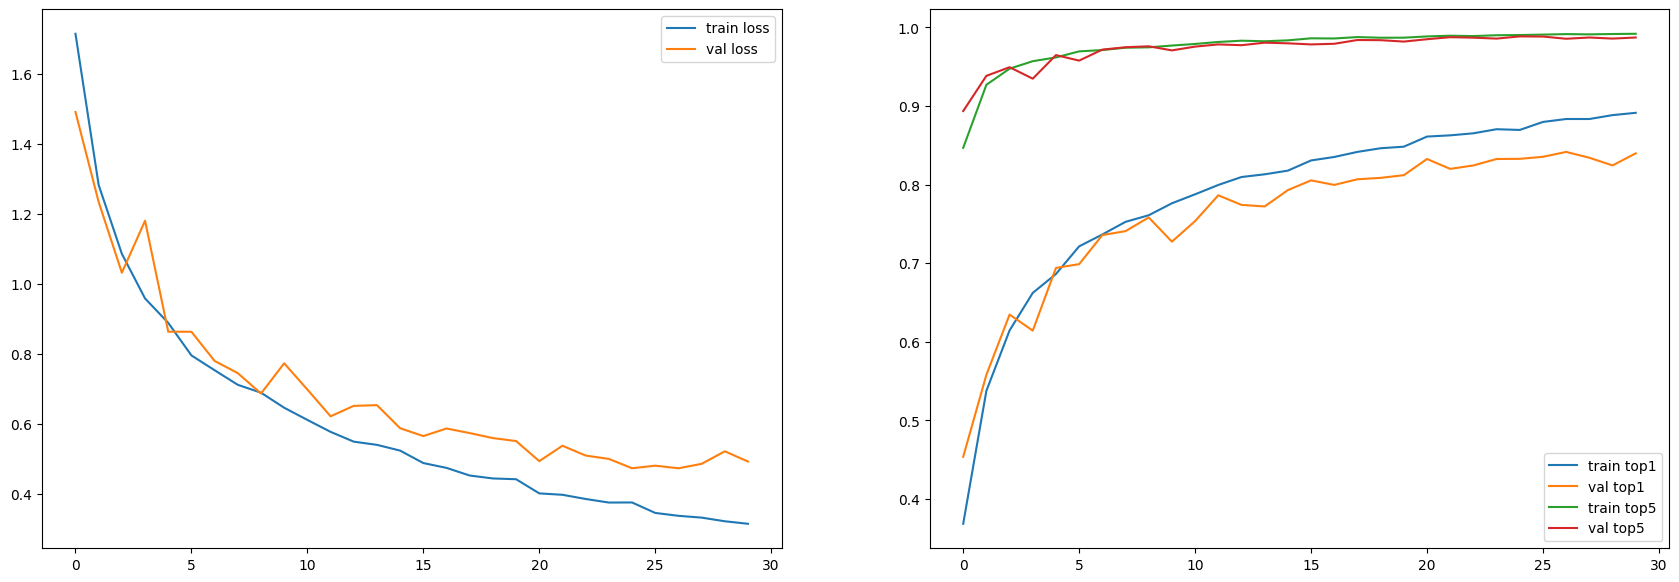

{'loss': 0.31714690834283826, 'top1': 0.8946999999999999, 'top5': 0.9963999999999998}


In [9]:
trainer_cnn = CNNTrainer(config=config, train_loader=train_data_loader, eval_loader=valid_data_loader)

#train
logs = trainer_cnn.train()

#evaluate
path = ospj(PROJECT_ROOT, f'saved/models/CIFAR10_CNN/{run_id}/best_val_model.pth')
trainer_cnn.load_model(path=path)
result = trainer_cnn.evaluate(loader=test_loader)

plot_logs(logs)
print(result)


b) Dropout is a popular scheme to regularize the model to improve generalization. The dropout layer works by setting the input activations randomly to zero at the output. You can implement Dropout by adding the `torch.nn.Dropout` layer between the conv blocks in your model. The layer has a single hyper-parameter $p$, which is the probability of dropping the input activations. High values of $p$ regularize the model heavily and decrease model capacity, but with low values, the model might overfit. Find the right hyper-parameter for $p$ by training the model for different values of $p$ and comparing training validation and validation accuracies. You can use the same parameter $p$ for all layers. You can also disable the data augmentation from the previous step while running this experiment, to clearly see the benefit of dropout. Show the plot of training and validation accuracies for different values of dropout (0.1 - 0.9) in the report. (4 points)

In [7]:
run_id = "exp_3b"
config = ConfigParser.wo_args(config='cfgs/exercise-3/cnn_cifar10.json', root_dir=PROJECT_ROOT, run_id=run_id)
config["arch"]["args"]["norm_layer"]["type"] = "BatchNorm2d"

datamodule = config.init_obj('data_module', module_data,root_dir=PROJECT_ROOT)

train_data_loader = datamodule.get_loader()
valid_data_loader = datamodule.get_heldout_loader()

test_loader_args = deepcopy(config['data_module']['args']) #copy the args
test_loader_args['training']=False
test_loader_args['shuffle']=False
test_loader_args['heldout_split']=0.0

test_module = getattr(module_data, config['data_module']['type'])(root_dir=PROJECT_ROOT, **test_loader_args)
test_loader = test_module.get_loader()

transformations for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 1}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 1}
transformations for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 1}


NumExpr defaulting to 2 threads.
ConvNet(
  (layers): ModuleList(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Dropout(p=0.1, inplace=False)
    (5): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Dropout(p=0.1, inplace=False)
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): ReLU()
    (14): Dropout(p=0.1, inplace=False)
    (15): Con

Train Epoch: 1 Loss: 0.883036: : 100% 45000/45000 [00:22<00:00, 2033.72it/s]

==> Finished Epoch 1/10.
++> Evaluate at epoch 1 ...



Eval Loss: 1.176354: : 100% 5000/5000 [00:07<00:00, 658.32it/s]

++> Evaluate epoch 1 Finished.
eval_top1 Metric improved: -inf -> 0.6164000000000001. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 1
    loss           : 1.2790514087677003
    top1           : 0.5314888888888889
    top5           : 0.9365111111111114
    eval_loss      : 1.0993268060684205
    eval_top1      : 0.6164000000000001
    eval_top5      : 0.964
==> Start Training Epoch 2/10, lr=0.002000 


Train Epoch: 2 Loss: 0.777622: : 100% 45000/45000 [00:22<00:00, 2037.67it/s]

==> Finished Epoch 2/10.
++> Evaluate at epoch 2 ...



Eval Loss: 0.778764: : 100% 5000/5000 [00:05<00:00, 938.85it/s] 

++> Evaluate epoch 2 Finished.
eval_top1 Metric improved: 0.6164000000000001 -> 0.7285999999999998. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 2
    loss           : 0.8339539164967007
    top1           : 0.7062444444444446
    top5           : 0.9784888888888896
    eval_loss      : 0.777521550655365
    eval_top1      : 0.7285999999999998
    eval_top5      : 0.9842
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/E2_model.pth ...
Checkpoint saved.
==> Start Training Epoch 3/10, lr=0.002000 


Train Epoch: 3 Loss: 0.593650: : 100% 45000/45000 [00:22<00:00, 2006.56it/s]

==> Finished Epoch 3/10.
++> Evaluate at epoch 3 ...



Eval Loss: 0.678354: : 100% 5000/5000 [00:05<00:00, 918.48it/s]

++> Evaluate epoch 3 Finished.
eval_top1 Metric improved: 0.7285999999999998 -> 0.7565999999999999. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 3
    loss           : 0.6566251443492042
    top1           : 0.7706666666666663
    top5           : 0.9874000000000018
    eval_loss      : 0.6973757076263428
    eval_top1      : 0.7565999999999999
    eval_top5      : 0.9855999999999999
==> Start Training Epoch 4/10, lr=0.002000 


Train Epoch: 4 Loss: 0.511315: : 100% 45000/45000 [00:21<00:00, 2050.89it/s]

==> Finished Epoch 4/10.
++> Evaluate at epoch 4 ...



Eval Loss: 0.559473: : 100% 5000/5000 [00:05<00:00, 879.95it/s]

++> Evaluate epoch 4 Finished.
eval_top1 Metric improved: 0.7565999999999999 -> 0.7981999999999999. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 4
    loss           : 0.5296589740117391
    top1           : 0.8148222222222218
    top5           : 0.9921555555555573
    eval_loss      : 0.5940871524810791
    eval_top1      : 0.7981999999999999
    eval_top5      : 0.9882
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/E4_model.pth ...
Checkpoint saved.
==> Start Training Epoch 5/10, lr=0.002000 


Train Epoch: 5 Loss: 0.342861: : 100% 45000/45000 [00:22<00:00, 2008.52it/s]

==> Finished Epoch 5/10.
++> Evaluate at epoch 5 ...



Eval Loss: 0.521395: : 100% 5000/5000 [00:05<00:00, 942.11it/s]

++> Evaluate epoch 5 Finished.
eval_top1 Metric improved: 0.7981999999999999 -> 0.8003999999999999. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 5
    loss           : 0.429049145910475
    top1           : 0.8507555555555557
    top5           : 0.99417777777778
    eval_loss      : 0.5909638154506683
    eval_top1      : 0.8003999999999999
    eval_top5      : 0.9895999999999998
==> Start Training Epoch 6/10, lr=0.001600 


Train Epoch: 6 Loss: 0.356350: : 100% 45000/45000 [00:22<00:00, 2000.64it/s]

==> Finished Epoch 6/10.
++> Evaluate at epoch 6 ...



Eval Loss: 0.506886: : 100% 5000/5000 [00:05<00:00, 949.94it/s] 

++> Evaluate epoch 6 Finished.
eval_top1 Metric improved: 0.8003999999999999 -> 0.8175999999999998. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 6
    loss           : 0.2984377527236938
    top1           : 0.8950222222222215
    top5           : 0.9975777777777792
    eval_loss      : 0.5861402249336243
    eval_top1      : 0.8175999999999998
    eval_top5      : 0.9913999999999998
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/E6_model.pth ...
Checkpoint saved.
==> Start Training Epoch 7/10, lr=0.001600 


Train Epoch: 7 Loss: 0.236409: : 100% 45000/45000 [00:21<00:00, 2051.39it/s]

==> Finished Epoch 7/10.
++> Evaluate at epoch 7 ...



Eval Loss: 0.645596: : 100% 5000/5000 [00:05<00:00, 953.78it/s]

++> Evaluate epoch 7 Finished.
    epoch          : 7
    loss           : 0.226601668993632
    top1           : 0.9205999999999999
    top5           : 0.9990222222222228
    eval_loss      : 0.7467758703231812
    eval_top1      : 0.7894
    eval_top5      : 0.9877999999999999
==> Start Training Epoch 8/10, lr=0.001600 



Train Epoch: 8 Loss: 0.209643: : 100% 45000/45000 [00:21<00:00, 2049.73it/s]

==> Finished Epoch 8/10.
++> Evaluate at epoch 8 ...



Eval Loss: 0.452992: : 100% 5000/5000 [00:05<00:00, 959.02it/s] 

++> Evaluate epoch 8 Finished.
    epoch          : 8
    loss           : 0.18014019211133322
    top1           : 0.9375777777777777
    top5           : 0.9994222222222227
    eval_loss      : 0.6564618360996246
    eval_top1      : 0.8158000000000001
    eval_top5      : 0.9882
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/E8_model.pth ...


Checkpoint saved.
==> Start Training Epoch 9/10, lr=0.001600 


Train Epoch: 9 Loss: 0.256233: : 100% 45000/45000 [00:21<00:00, 2107.25it/s]

==> Finished Epoch 9/10.
++> Evaluate at epoch 9 ...



Eval Loss: 0.489315: : 100% 5000/5000 [00:05<00:00, 874.45it/s] 

++> Evaluate epoch 9 Finished.
eval_top1 Metric improved: 0.8175999999999998 -> 0.8306. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 9
    loss           : 0.13482481489578882
    top1           : 0.9523333333333336
    top5           : 0.9998222222222224
    eval_loss      : 0.6052018904685974
    eval_top1      : 0.8306
    eval_top5      : 0.9908
==> Start Training Epoch 10/10, lr=0.001600 


Train Epoch: 10 Loss: 0.082184: : 100% 45000/45000 [00:21<00:00, 2127.63it/s]

==> Finished Epoch 10/10.
++> Evaluate at epoch 10 ...



Eval Loss: 0.403192: : 100% 5000/5000 [00:06<00:00, 773.76it/s]

++> Evaluate epoch 10 Finished.
    epoch          : 10
    loss           : 0.11653788179159165
    top1           : 0.958955555555555
    top5           : 0.9999111111111112
    eval_loss      : 0.6347288382053375
    eval_top1      : 0.8276


    eval_top5      : 0.9900000000000001
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/E10_model.pth ...
Checkpoint saved.
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/last_model.pth ...
Checkpoint saved.
Loading checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...
Checkpoint loaded.
++> Evaluate at epoch 10 ...


Eval Loss: 0.754332: : 100% 10000/10000 [00:12<00:00, 811.12it/s]

++> Evaluate epoch 10 Finished.


Results for p = 1


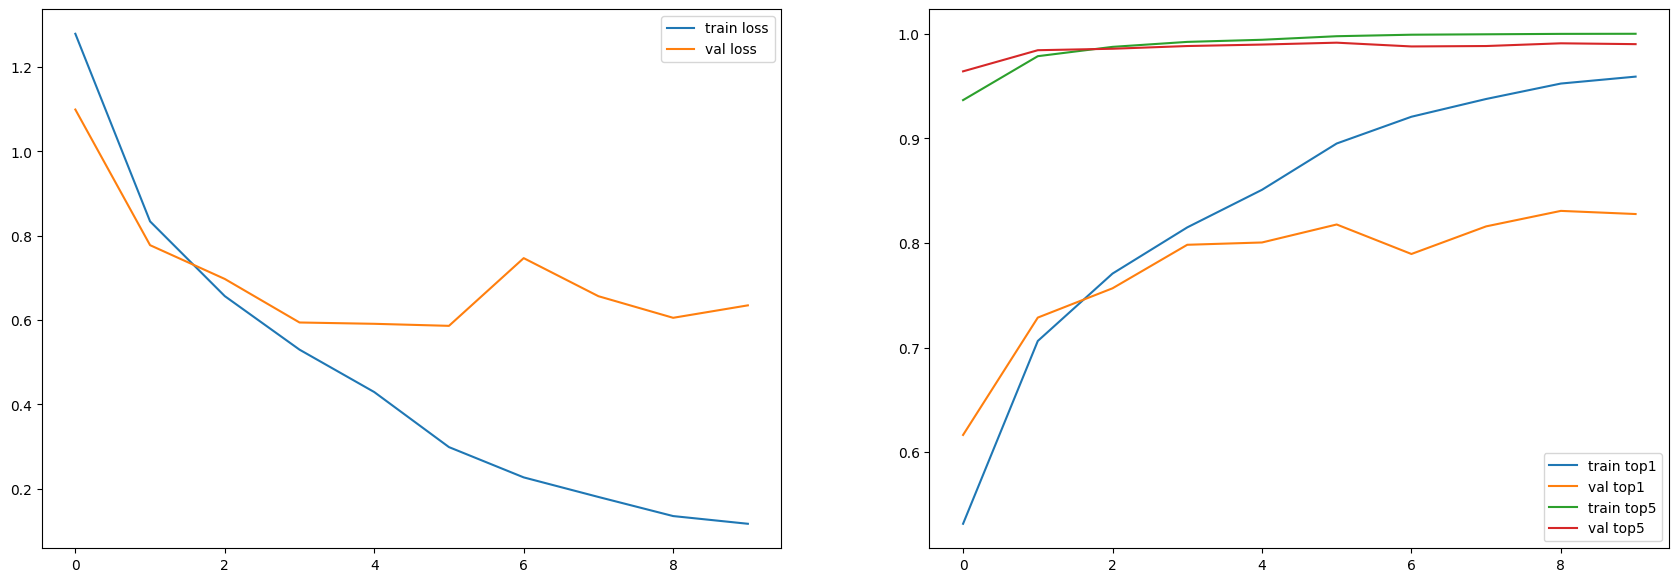

{'loss': 0.646573222875595, 'top1': 0.8144999999999999, 'top5': 0.9886}
ConvNet(
  (layers): ModuleList(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Dropout(p=0.3, inplace=False)
    (5): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): ReLU()
    (14): Drop

Train Epoch: 1 Loss: 1.057160: : 100% 45000/45000 [00:20<00:00, 2159.60it/s]

==> Finished Epoch 1/10.
++> Evaluate at epoch 1 ...



Eval Loss: 1.102766: : 100% 5000/5000 [00:06<00:00, 735.19it/s]

++> Evaluate epoch 1 Finished.
eval_top1 Metric improved: -inf -> 0.5928000000000001. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 1
    loss           : 1.3527211917771234
    top1           : 0.49728888888888884
    top5           : 0.9297777777777776
    eval_loss      : 1.135475389957428
    eval_top1      : 0.5928000000000001
    eval_top5      : 0.9641999999999998
==> Start Training Epoch 2/10, lr=0.002000 


Train Epoch: 2 Loss: 0.823471: : 100% 45000/45000 [00:21<00:00, 2083.37it/s]

==> Finished Epoch 2/10.
++> Evaluate at epoch 2 ...



Eval Loss: 0.911347: : 100% 5000/5000 [00:06<00:00, 735.01it/s]

++> Evaluate epoch 2 Finished.
eval_top1 Metric improved: 0.5928000000000001 -> 0.6668. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 2
    loss           : 0.9387950695885552
    top1           : 0.6648444444444446
    top5           : 0.9723555555555559
    eval_loss      : 0.9254940247535706
    eval_top1      : 0.6668
    eval_top5      : 0.9739999999999998
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/E2_model.pth ...
Checkpoint saved.
==> Start Training Epoch 3/10, lr=0.002000 


Train Epoch: 3 Loss: 0.749244: : 100% 45000/45000 [00:21<00:00, 2067.04it/s]

==> Finished Epoch 3/10.


++> Evaluate at epoch 3 ...


Eval Loss: 0.738151: : 100% 5000/5000 [00:07<00:00, 710.73it/s]

++> Evaluate epoch 3 Finished.
eval_top1 Metric improved: 0.6668 -> 0.7424000000000001. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 3
    loss           : 0.7735115210215251
    top1           : 0.7262888888888884
    top5           : 0.9818444444444454
    eval_loss      : 0.7422437191009521
    eval_top1      : 0.7424000000000001
    eval_top5      : 0.9839999999999999
==> Start Training Epoch 4/10, lr=0.002000 


Train Epoch: 4 Loss: 0.702643: : 100% 45000/45000 [00:22<00:00, 1981.77it/s]

==> Finished Epoch 4/10.
++> Evaluate at epoch 4 ...



Eval Loss: 0.675078: : 100% 5000/5000 [00:07<00:00, 681.09it/s]

++> Evaluate epoch 4 Finished.
eval_top1 Metric improved: 0.7424000000000001 -> 0.7668000000000003. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 4
    loss           : 0.6788543472025129
    top1           : 0.7609333333333335
    top5           : 0.9865333333333348
    eval_loss      : 0.6623154401779174
    eval_top1      : 0.7668000000000003
    eval_top5      : 0.9869999999999999
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/E4_model.pth ...
Checkpoint saved.
==> Start Training Epoch 5/10, lr=0.002000 


Train Epoch: 5 Loss: 0.631411: : 100% 45000/45000 [00:21<00:00, 2061.34it/s]

==> Finished Epoch 5/10.
++> Evaluate at epoch 5 ...



Eval Loss: 0.582528: : 100% 5000/5000 [00:06<00:00, 764.98it/s] 

++> Evaluate epoch 5 Finished.
eval_top1 Metric improved: 0.7668000000000003 -> 0.8047999999999997. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 5
    loss           : 0.5866756497489082
    top1           : 0.7957777777777777
    top5           : 0.9903555555555582
    eval_loss      : 0.5617096149921417
    eval_top1      : 0.8047999999999997
    eval_top5      : 0.9896
==> Start Training Epoch 6/10, lr=0.001600 


Train Epoch: 6 Loss: 0.701229: : 100% 45000/45000 [00:21<00:00, 2075.64it/s]

==> Finished Epoch 6/10.
++> Evaluate at epoch 6 ...



Eval Loss: 0.569831: : 100% 5000/5000 [00:06<00:00, 747.33it/s]

++> Evaluate epoch 6 Finished.
eval_top1 Metric improved: 0.8047999999999997 -> 0.8170000000000001. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 6
    loss           : 0.4919029113981459
    top1           : 0.8276888888888891
    top5           : 0.9932666666666686
    eval_loss      : 0.5450069737434388
    eval_top1      : 0.8170000000000001
    eval_top5      : 0.9894
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/E6_model.pth ...
Checkpoint saved.
==> Start Training Epoch 7/10, lr=0.001600 


Train Epoch: 7 Loss: 0.503728: : 100% 45000/45000 [00:21<00:00, 2086.25it/s]

==> Finished Epoch 7/10.
++> Evaluate at epoch 7 ...



Eval Loss: 0.547825: : 100% 5000/5000 [00:06<00:00, 750.02it/s]

++> Evaluate epoch 7 Finished.
eval_top1 Metric improved: 0.8170000000000001 -> 0.821. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 7
    loss           : 0.43851683259010316
    top1           : 0.846266666666667
    top5           : 0.9952000000000019
    eval_loss      : 0.5502408695220947
    eval_top1      : 0.821
    eval_top5      : 0.9919999999999999
==> Start Training Epoch 8/10, lr=0.001600 


Train Epoch: 8 Loss: 0.450327: : 100% 45000/45000 [00:22<00:00, 1992.01it/s]

==> Finished Epoch 8/10.
++> Evaluate at epoch 8 ...



Eval Loss: 0.565164: : 100% 5000/5000 [00:06<00:00, 734.54it/s]

++> Evaluate epoch 8 Finished.
    epoch          : 8
    loss           : 0.39576520952913496
    top1           : 0.8605333333333338
    top5           : 0.996222222222224
    eval_loss      : 0.5413354659080505
    eval_top1      : 0.8156


    eval_top5      : 0.9928000000000001
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/E8_model.pth ...
Checkpoint saved.
==> Start Training Epoch 9/10, lr=0.001600 


Train Epoch: 9 Loss: 0.402768: : 100% 45000/45000 [00:23<00:00, 1896.09it/s]

==> Finished Epoch 9/10.
++> Evaluate at epoch 9 ...



Eval Loss: 0.440327: : 100% 5000/5000 [00:06<00:00, 791.28it/s]

++> Evaluate epoch 9 Finished.
eval_top1 Metric improved: 0.821 -> 0.826. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 9
    loss           : 0.34624877174695334
    top1           : 0.8771999999999996
    top5           : 0.9974444444444455
    eval_loss      : 0.527909060716629
    eval_top1      : 0.826
    eval_top5      : 0.9902000000000002
==> Start Training Epoch 10/10, lr=0.001600 


Train Epoch: 10 Loss: 0.326063: : 100% 45000/45000 [00:23<00:00, 1950.84it/s]

==> Finished Epoch 10/10.
++> Evaluate at epoch 10 ...



Eval Loss: 0.457309: : 100% 5000/5000 [00:05<00:00, 854.97it/s]

++> Evaluate epoch 10 Finished.
eval_top1 Metric improved: 0.826 -> 0.8383999999999997. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 10
    loss           : 0.3151182567410999
    top1           : 0.8887333333333338
    top5           : 0.9981777777777789
    eval_loss      : 0.5009523272514343
    eval_top1      : 0.8383999999999997
    eval_top5      : 0.9943999999999998
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/E10_model.pth ...
Checkpoint saved.
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/last_model.pth ...
Checkpoint saved.
Loading checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...
Checkpoint loaded.
++> Evaluate at epoch 10 ...


Eval Loss: 0.660928: : 100% 10000/10000 [00:13<00:00, 735.13it/s]

++> Evaluate epoch 10 Finished.


Results for p = 3


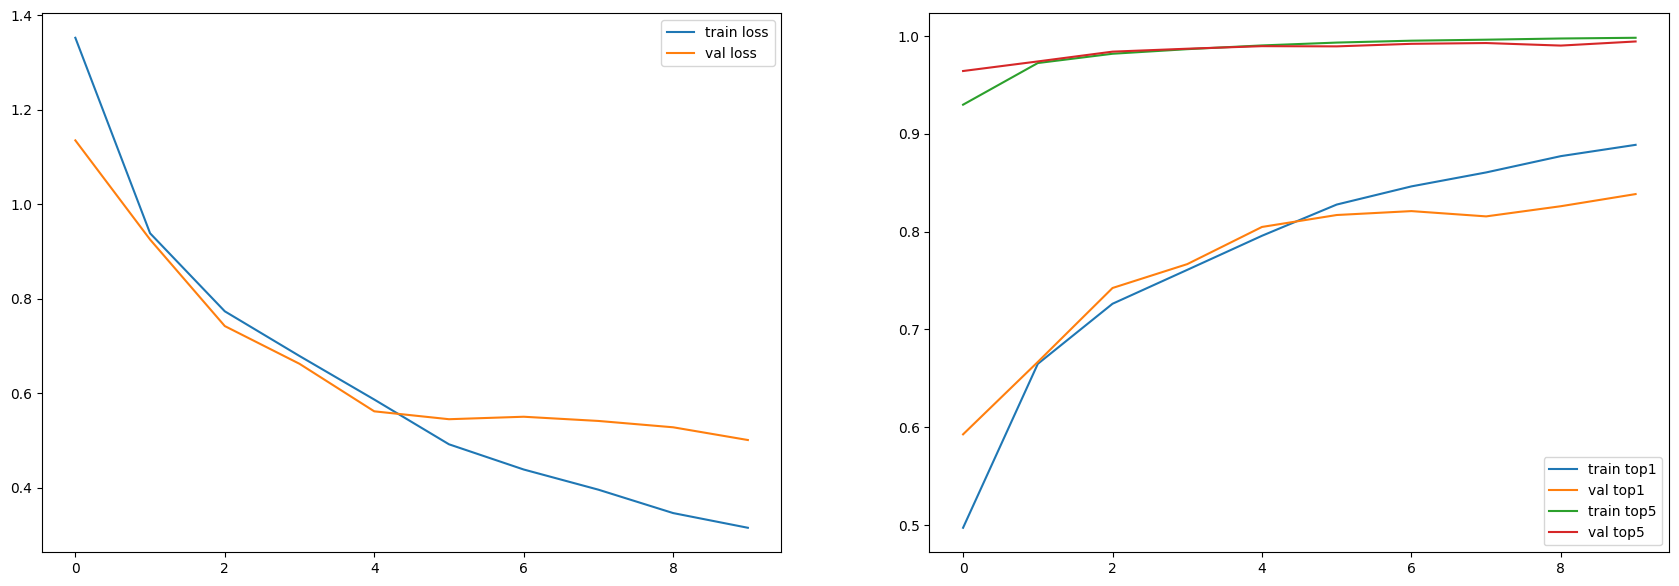

{'loss': 0.5412306290864944, 'top1': 0.8317000000000001, 'top5': 0.9922000000000001}
ConvNet(
  (layers): ModuleList(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): ReLU()
 

Train Epoch: 1 Loss: 1.248827: : 100% 45000/45000 [00:24<00:00, 1842.65it/s]

==> Finished Epoch 1/10.
++> Evaluate at epoch 1 ...



Eval Loss: 1.253666: : 100% 5000/5000 [00:05<00:00, 876.45it/s]

++> Evaluate epoch 1 Finished.
eval_top1 Metric improved: -inf -> 0.5546. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 1
    loss           : 1.5296514537599353
    top1           : 0.43244444444444463
    top5           : 0.9044000000000002
    eval_loss      : 1.2242996025085449
    eval_top1      : 0.5546
    eval_top5      : 0.9486000000000001
==> Start Training Epoch 2/10, lr=0.002000 


Train Epoch: 2 Loss: 0.935644: : 100% 45000/45000 [00:24<00:00, 1815.76it/s]

==> Finished Epoch 2/10.
++> Evaluate at epoch 2 ...



Eval Loss: 0.962813: : 100% 5000/5000 [00:05<00:00, 842.51it/s]

++> Evaluate epoch 2 Finished.
eval_top1 Metric improved: 0.5546 -> 0.6609999999999999. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 2
    loss           : 1.1391535841094123
    top1           : 0.5876444444444447
    top5           : 0.957733333333334
    eval_loss      : 0.9575369238853455
    eval_top1      : 0.6609999999999999
    eval_top5      : 0.9718000000000001
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/E2_model.pth ...
Checkpoint saved.
==> Start Training Epoch 3/10, lr=0.002000 


Train Epoch: 3 Loss: 0.980162: : 100% 45000/45000 [00:24<00:00, 1809.08it/s]

==> Finished Epoch 3/10.
++> Evaluate at epoch 3 ...



Eval Loss: 0.860642: : 100% 5000/5000 [00:05<00:00, 874.89it/s]

++> Evaluate epoch 3 Finished.
eval_top1 Metric improved: 0.6609999999999999 -> 0.7066. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 3
    loss           : 0.983559566338857
    top1           : 0.6472222222222226
    top5           : 0.9698000000000003
    eval_loss      : 0.8292233204841614
    eval_top1      : 0.7066
    eval_top5      : 0.9802
==> Start Training Epoch 4/10, lr=0.002000 


Train Epoch: 4 Loss: 0.810919: : 100% 45000/45000 [00:25<00:00, 1769.20it/s]

==> Finished Epoch 4/10.
++> Evaluate at epoch 4 ...



Eval Loss: 0.780743: : 100% 5000/5000 [00:06<00:00, 810.99it/s]

++> Evaluate epoch 4 Finished.
eval_top1 Metric improved: 0.7066 -> 0.7208000000000002. Saving the best model


Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...
Checkpoint saved.
    epoch          : 4
    loss           : 0.8829640038808186
    top1           : 0.6858444444444445
    top5           : 0.9763555555555561
    eval_loss      : 0.7949288439750671
    eval_top1      : 0.7208000000000002
    eval_top5      : 0.9825999999999998
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/E4_model.pth ...
Checkpoint saved.
==> Start Training Epoch 5/10, lr=0.002000 


Train Epoch: 5 Loss: 0.785193: : 100% 45000/45000 [00:25<00:00, 1792.44it/s]

==> Finished Epoch 5/10.
++> Evaluate at epoch 5 ...



Eval Loss: 0.800771: : 100% 5000/5000 [00:06<00:00, 818.19it/s]

++> Evaluate epoch 5 Finished.
    epoch          : 5
    loss           : 0.8092399809095595
    top1           : 0.7137999999999999
    top5           : 0.9811555555555568
    eval_loss      : 0.8533664608001709
    eval_top1      : 0.7050000000000002


    eval_top5      : 0.9752000000000001
==> Start Training Epoch 6/10, lr=0.001600 


Train Epoch: 6 Loss: 0.704043: : 100% 45000/45000 [00:24<00:00, 1816.56it/s]

==> Finished Epoch 6/10.
++> Evaluate at epoch 6 ...



Eval Loss: 0.641504: : 100% 5000/5000 [00:06<00:00, 784.85it/s]

++> Evaluate epoch 6 Finished.
eval_top1 Metric improved: 0.7208000000000002 -> 0.7785999999999998. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 6
    loss           : 0.7347818459404839
    top1           : 0.7419111111111107
    top5           : 0.9852888888888905
    eval_loss      : 0.6378554844856262
    eval_top1      : 0.7785999999999998
    eval_top5      : 0.9877999999999999
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/E6_model.pth ...
Checkpoint saved.
==> Start Training Epoch 7/10, lr=0.001600 


Train Epoch: 7 Loss: 0.656332: : 100% 45000/45000 [00:24<00:00, 1835.49it/s]

==> Finished Epoch 7/10.
++> Evaluate at epoch 7 ...



Eval Loss: 0.583383: : 100% 5000/5000 [00:07<00:00, 663.21it/s]

++> Evaluate epoch 7 Finished.
eval_top1 Metric improved: 0.7785999999999998 -> 0.7959999999999999. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 7
    loss           : 0.6795416439904107
    top1           : 0.7600888888888889
    top5           : 0.9875333333333352
    eval_loss      : 0.5979799377918243
    eval_top1      : 0.7959999999999999
    eval_top5      : 0.9906
==> Start Training Epoch 8/10, lr=0.001600 


Train Epoch: 8 Loss: 0.759909: : 100% 45000/45000 [00:23<00:00, 1894.07it/s]

==> Finished Epoch 8/10.
++> Evaluate at epoch 8 ...



Eval Loss: 0.589314: : 100% 5000/5000 [00:07<00:00, 664.81it/s]

++> Evaluate epoch 8 Finished.
    epoch          : 8
    loss           : 0.6401939529842801
    top1           : 0.7764444444444446


    top5           : 0.9883555555555572
    eval_loss      : 0.6358101272583008
    eval_top1      : 0.7816000000000001
    eval_top5      : 0.9884
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/E8_model.pth ...
Checkpoint saved.
==> Start Training Epoch 9/10, lr=0.001600 


Train Epoch: 9 Loss: 0.594393: : 100% 45000/45000 [00:22<00:00, 1980.85it/s]

==> Finished Epoch 9/10.
++> Evaluate at epoch 9 ...



Eval Loss: 0.551633: : 100% 5000/5000 [00:07<00:00, 679.63it/s]

++> Evaluate epoch 9 Finished.
eval_top1 Metric improved: 0.7959999999999999 -> 0.8003999999999999. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 9
    loss           : 0.609512771235572
    top1           : 0.7853777777777782
    top5           : 0.9892888888888912
    eval_loss      : 0.5698109579086303
    eval_top1      : 0.8003999999999999
    eval_top5      : 0.9897999999999999
==> Start Training Epoch 10/10, lr=0.001600 


Train Epoch: 10 Loss: 0.697766: : 100% 45000/45000 [00:21<00:00, 2053.05it/s]

==> Finished Epoch 10/10.
++> Evaluate at epoch 10 ...



Eval Loss: 0.522562: : 100% 5000/5000 [00:07<00:00, 695.48it/s]

++> Evaluate epoch 10 Finished.
eval_top1 Metric improved: 0.8003999999999999 -> 0.8012. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 10
    loss           : 0.5782070393032498
    top1           : 0.7981333333333335
    top5           : 0.9908000000000023
    eval_loss      : 0.5678950881958008
    eval_top1      : 0.8012
    eval_top5      : 0.99
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/E10_model.pth ...
Checkpoint saved.
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/last_model.pth ...
Checkpoint saved.
Loading checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...
Checkpoint loaded.
++> Evaluate at epoch 10 ...


Eval Loss: 0.618754: : 100% 10000/10000 [00:12<00:00, 789.81it/s]

++> Evaluate epoch 10 Finished.


Results for p = 5


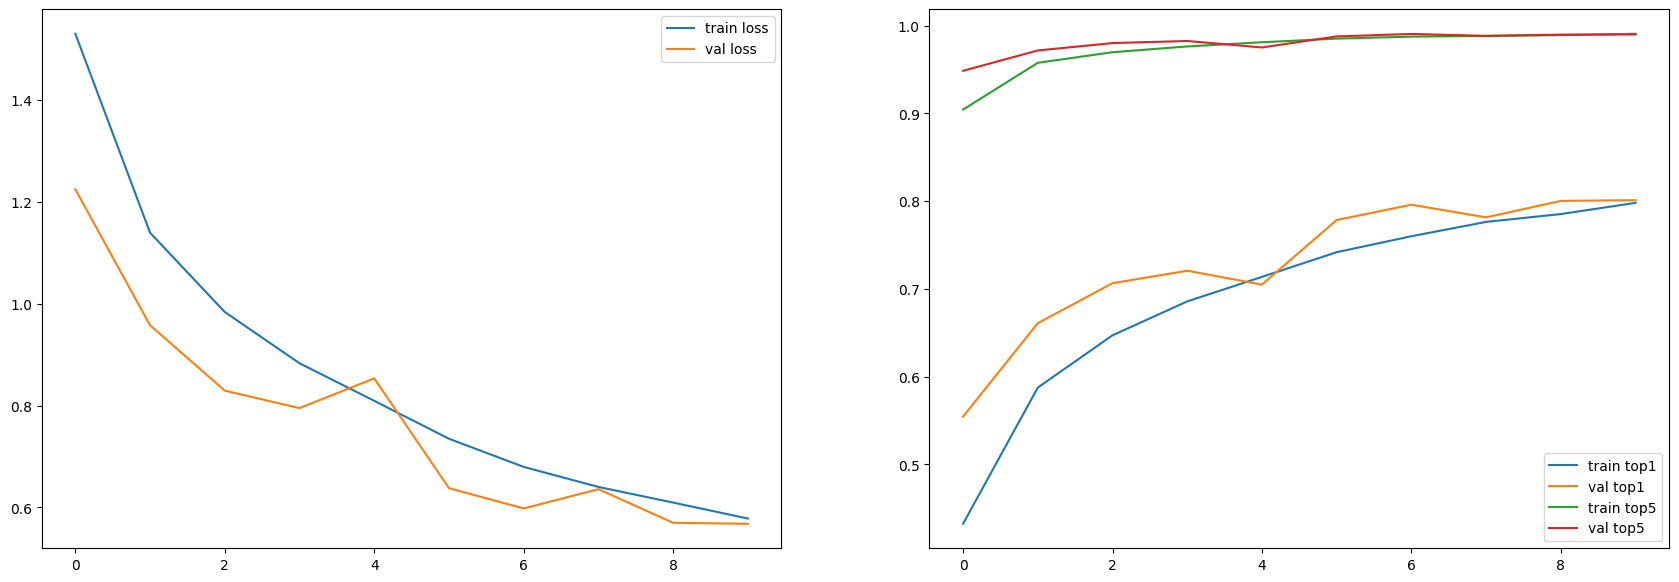

{'loss': 0.6002210211753846, 'top1': 0.7921999999999998, 'top5': 0.9871999999999997}
ConvNet(
  (layers): ModuleList(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Dropout(p=0.7, inplace=False)
    (5): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Dropout(p=0.7, inplace=False)
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): ReLU()
 

Train Epoch: 1 Loss: 1.581745: : 100% 45000/45000 [00:22<00:00, 2008.01it/s]

==> Finished Epoch 1/10.
++> Evaluate at epoch 1 ...



Eval Loss: 1.749074: : 100% 5000/5000 [00:07<00:00, 688.29it/s]

++> Evaluate epoch 1 Finished.
eval_top1 Metric improved: -inf -> 0.38079999999999997. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 1
    loss           : 1.7808263783984715
    top1           : 0.32720000000000005
    top5           : 0.8550666666666661
    eval_loss      : 1.7303916120529175
    eval_top1      : 0.38079999999999997
    eval_top5      : 0.8692
==> Start Training Epoch 2/10, lr=0.002000 


Train Epoch: 2 Loss: 1.304287: : 100% 45000/45000 [00:22<00:00, 1968.53it/s]

==> Finished Epoch 2/10.
++> Evaluate at epoch 2 ...



Eval Loss: 1.580977: : 100% 5000/5000 [00:07<00:00, 688.47it/s]

++> Evaluate epoch 2 Finished.
eval_top1 Metric improved: 0.38079999999999997 -> 0.40879999999999994. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 2
    loss           : 1.4504348876741198
    top1           : 0.46211111111111103
    top5           : 0.9282888888888885
    eval_loss      : 1.6490027046203612
    eval_top1      : 0.40879999999999994
    eval_top5      : 0.8984000000000002
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/E2_model.pth ...
Checkpoint saved.
==> Start Training Epoch 3/10, lr=0.002000 


Train Epoch: 3 Loss: 1.237578: : 100% 45000/45000 [00:23<00:00, 1901.66it/s]

==> Finished Epoch 3/10.
++> Evaluate at epoch 3 ...



Eval Loss: 1.314908: : 100% 5000/5000 [00:06<00:00, 760.34it/s]

++> Evaluate epoch 3 Finished.
eval_top1 Metric improved: 0.40879999999999994 -> 0.4947999999999999. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 3
    loss           : 1.3065208546320597
    top1           : 0.524822222222222
    top5           : 0.9430888888888883
    eval_loss      : 1.3826986932754517
    eval_top1      : 0.4947999999999999
    eval_top5      : 0.9281999999999999
==> Start Training Epoch 4/10, lr=0.002000 


Train Epoch: 4 Loss: 1.136630: : 100% 45000/45000 [00:23<00:00, 1915.87it/s]

==> Finished Epoch 4/10.
++> Evaluate at epoch 4 ...



Eval Loss: 1.376404: : 100% 5000/5000 [00:06<00:00, 816.07it/s]

++> Evaluate epoch 4 Finished.
    epoch          : 4
    loss           : 1.218633959558275
    top1           : 0.5598666666666665
    top5           : 0.9503999999999998
    eval_loss      : 1.5170186901092528
    eval_top1      : 0.48800000000000004
    eval_top5      : 0.9172000000000001
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/E4_model.pth ...


Checkpoint saved.
==> Start Training Epoch 5/10, lr=0.002000 


Train Epoch: 5 Loss: 1.025458: : 100% 45000/45000 [00:23<00:00, 1922.20it/s]

==> Finished Epoch 5/10.
++> Evaluate at epoch 5 ...



Eval Loss: 1.127704: : 100% 5000/5000 [00:05<00:00, 846.55it/s]

++> Evaluate epoch 5 Finished.
eval_top1 Metric improved: 0.4947999999999999 -> 0.5792. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 5
    loss           : 1.1513544495900472
    top1           : 0.5859111111111109
    top5           : 0.9574666666666676
    eval_loss      : 1.2043435621261596
    eval_top1      : 0.5792
    eval_top5      : 0.9492
==> Start Training Epoch 6/10, lr=0.001600 


Train Epoch: 6 Loss: 1.133683: : 100% 45000/45000 [00:24<00:00, 1836.01it/s]

==> Finished Epoch 6/10.
++> Evaluate at epoch 6 ...



Eval Loss: 1.109317: : 100% 5000/5000 [00:05<00:00, 833.96it/s]

++> Evaluate epoch 6 Finished.
eval_top1 Metric improved: 0.5792 -> 0.5892000000000001. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...


Checkpoint saved.
    epoch          : 6
    loss           : 1.0856729812092252
    top1           : 0.6107333333333331
    top5           : 0.9618666666666669
    eval_loss      : 1.1650175428390503
    eval_top1      : 0.5892000000000001
    eval_top5      : 0.9486000000000001
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/E6_model.pth ...
Checkpoint saved.
==> Start Training Epoch 7/10, lr=0.001600 


Train Epoch: 7 Loss: 1.117357: : 100% 45000/45000 [00:25<00:00, 1761.32it/s]

==> Finished Epoch 7/10.
++> Evaluate at epoch 7 ...



Eval Loss: 1.234011: : 100% 5000/5000 [00:05<00:00, 849.98it/s]

++> Evaluate epoch 7 Finished.
    epoch          : 7
    loss           : 1.046820871035258
    top1           : 0.6258222222222224
    top5           : 0.9661999999999994
    eval_loss      : 1.3307136106491089
    eval_top1      : 0.5478
    eval_top5      : 0.9452000000000002
==> Start Training Epoch 8/10, lr=0.001600 



Train Epoch: 8 Loss: 0.948327: : 100% 45000/45000 [00:25<00:00, 1794.24it/s]

==> Finished Epoch 8/10.
++> Evaluate at epoch 8 ...



Eval Loss: 1.169888: : 100% 5000/5000 [00:06<00:00, 830.13it/s]

++> Evaluate epoch 8 Finished.
    epoch          : 8
    loss           : 1.0130683318773905
    top1           : 0.6411333333333337
    top5           : 0.9679333333333333


    eval_loss      : 1.22191162109375
    eval_top1      : 0.5824
    eval_top5      : 0.9468000000000001
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/E8_model.pth ...
Checkpoint saved.
==> Start Training Epoch 9/10, lr=0.001600 


Train Epoch: 9 Loss: 1.093663: : 100% 45000/45000 [00:25<00:00, 1787.46it/s]

==> Finished Epoch 9/10.
++> Evaluate at epoch 9 ...



Eval Loss: 1.004809: : 100% 5000/5000 [00:05<00:00, 842.06it/s]

++> Evaluate epoch 9 Finished.
eval_top1 Metric improved: 0.5892000000000001 -> 0.6302. Saving the best model


Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...
Checkpoint saved.
    epoch          : 9
    loss           : 0.9825969158278571
    top1           : 0.6489555555555553
    top5           : 0.9704666666666664
    eval_loss      : 1.0633812737464905
    eval_top1      : 0.6302
    eval_top5      : 0.9608000000000001
==> Start Training Epoch 10/10, lr=0.001600 


Train Epoch: 10 Loss: 0.891198: : 100% 45000/45000 [00:25<00:00, 1788.31it/s]

==> Finished Epoch 10/10.
++> Evaluate at epoch 10 ...



Eval Loss: 0.971281: : 100% 5000/5000 [00:05<00:00, 834.83it/s]

++> Evaluate epoch 10 Finished.
eval_top1 Metric improved: 0.6302 -> 0.6447999999999999. Saving the best model


Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...
Checkpoint saved.
    epoch          : 10
    loss           : 0.9523972437116834
    top1           : 0.6612222222222224
    top5           : 0.9726444444444446
    eval_loss      : 1.0368681073188781
    eval_top1      : 0.6447999999999999
    eval_top5      : 0.9607999999999999
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/E10_model.pth ...
Checkpoint saved.
Saving checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/last_model.pth ...
Checkpoint saved.
Loading checkpoint: ../../saved/models/CIFAR10_CNN/exp_3b/best_val_model.pth ...
Checkpoint loaded.
++> Evaluate at epoch 10 ...


Eval Loss: 1.160491: : 100% 10000/10000 [00:13<00:00, 725.06it/s]

++> Evaluate epoch 10 Finished.


Results for p = 7


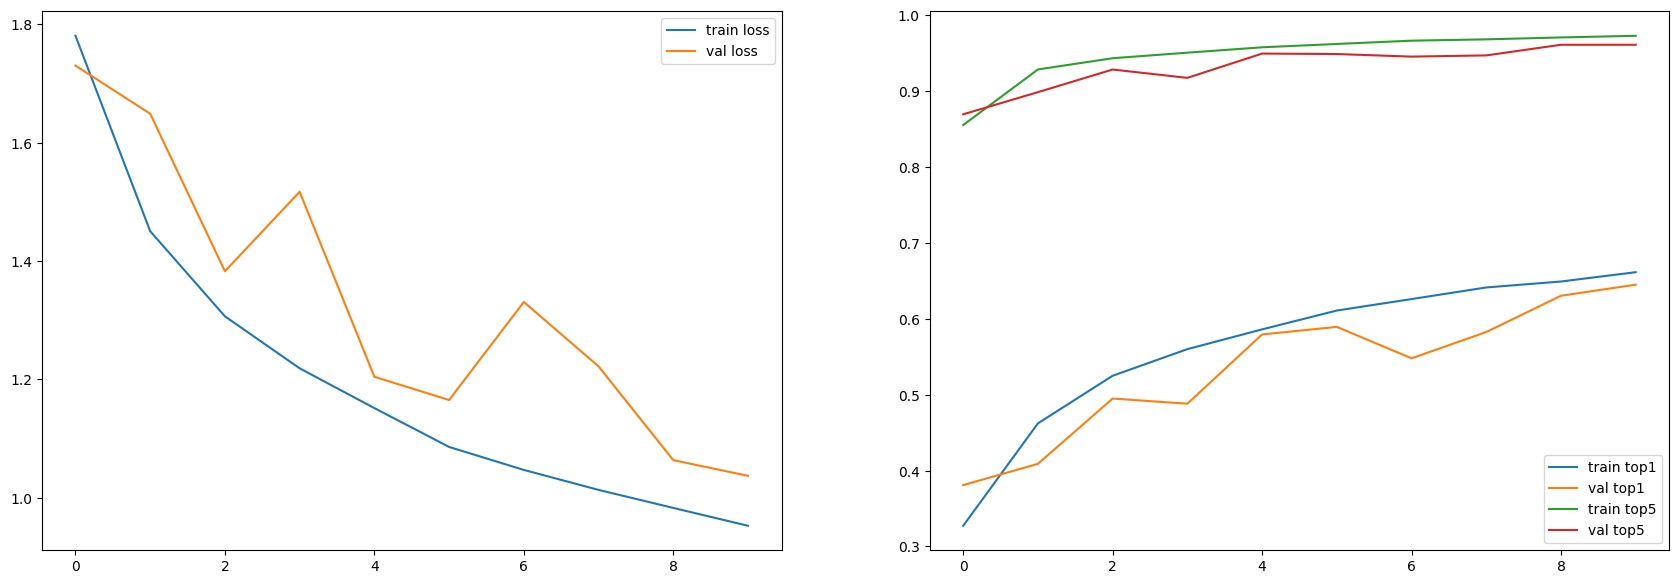

{'loss': 1.07067351102829, 'top1': 0.6267999999999999, 'top5': 0.9595}


In [8]:
for p in range(1, 9, 2):
    config["arch"]["args"]["drop_prob"] = p/10.0
    trainer_cnn = CNNTrainer(config=config, train_loader=train_data_loader, eval_loader=valid_data_loader)

    #train
    logs = trainer_cnn.train()

    #evaluate
    path = ospj(PROJECT_ROOT, f'saved/models/CIFAR10_CNN/{run_id}/best_val_model.pth')
    trainer_cnn.load_model(path=path)
    result = trainer_cnn.evaluate(loader=test_loader)

    print(f"Results for p = {p}")
    plot_logs(logs)
    print(result)

Wirte your report for Q3 in this cell. Feel free to add extra code cells

**3a. Using Image Augmentations** <br>
The torchvision library provides auto augemnt module which implements specific augemntations for different datasets includng CIFAR 10. The transforms include the following trasnforms:  
```
(("Invert", 0.1, None), ("Contrast", 0.2, 6)),
(("Rotate", 0.7, 2), ("TranslateX", 0.3, 9)),
(("Sharpness", 0.8, 1), ("Sharpness", 0.9, 3)),
(("ShearY", 0.5, 8), ("TranslateY", 0.7, 9)),
(("AutoContrast", 0.5, None), ("Equalize", 0.9, None)),
(("ShearY", 0.2, 7), ("Posterize", 0.3, 7)),
(("Color", 0.4, 3), ("Brightness", 0.6, 7)),
(("Sharpness", 0.3, 9), ("Brightness", 0.7, 9)),
(("Equalize", 0.6, None), ("Equalize", 0.5, None)),
(("Contrast", 0.6, 7), ("Sharpness", 0.6, 5)),
(("Color", 0.7, 7), ("TranslateX", 0.5, 8)),
(("Equalize", 0.3, None), ("AutoContrast", 0.4, None)),
(("TranslateY", 0.4, 3), ("Sharpness", 0.2, 6)),
(("Brightness", 0.9, 6), ("Color", 0.2, 8)),
(("Solarize", 0.5, 2), ("Invert", 0.0, None)),
(("Equalize", 0.2, None), ("AutoContrast", 0.6, None)),
(("Equalize", 0.2, None), ("Equalize", 0.6, None)),
(("Color", 0.9, 9), ("Equalize", 0.6, None)),
(("AutoContrast", 0.8, None), ("Solarize", 0.2, 8)),
(("Brightness", 0.1, 3), ("Color", 0.7, 0)),
(("Solarize", 0.4, 5), ("AutoContrast", 0.9, None)),
(("TranslateY", 0.9, 9), ("TranslateY", 0.7, 9)),
(("AutoContrast", 0.9, None), ("Solarize", 0.8, 3)),
(("Equalize", 0.8, None), ("Invert", 0.1, None)),
(("TranslateY", 0.7, 9), ("AutoContrast", 0.9, None)),
```
source: https://pytorch.org/vision/stable/_modules/torchvision/transforms/autoaugment.html#AutoAugmentPolicy

Training the model with image augmentations proved to significantly improved the model performance on the test set (top1: 0.83 -> 0.89). The graphs of the training and eval loss show that the eval loss closely follows the train error and indicating that the model is not overfitting.

**3b. Using Dropout** <br>
We experimented with diffeent dropout values 0.1, 0.3, 0.5, 0.7. The training curves for each run show that there is a decrease in overfitting.



1.   Dropout with prob 0.1 did not impact the overfitting much. The model still overfits
2.   Dropout values 0.3, 0.5, 0.7 reduced the overfitting. The 
3.   Dropout value of 0.7 adn 0.5 also caused slight underfitting. The training curve did not flatten at the end of 10 epochs indicating that the model can benefit from more epochs of training 

Overall the dropout was helpful in reducing overfitting. 



### Question 4: Use pretrained networks (10 points)

It has become standard practice in computer vision tasks related to images to use a convolutional network pre-trained as the backbone feature extraction network and train new layers on top for the target task. In this question, we will implement such a model. We will use the `VGG_11_bn` network from the `torchvision.models` library as our backbone network. This model has been trained on ImageNet, achieving a top-5 error rate of 10.19%. It consists of 8 convolutional layers followed by adaptive average pooling and fully-connected layers to perform the classification. We will get rid of the average pooling and fully-connected layers from the `VGG_11_bn` model and attach our own fully connected layers to perform the CIFAR-10 classification.

In [9]:
from trainers.vgg_trainer import VGGTrainer

 By default WandB is enabled in config file for vgg_cifar10.json. You can set it to false if you don't want to use it.

a) Instantiate a pretrained version of the `VGG_11_bn` model with ImageNet pre-trained weights. Add two fully connected layers on top, with Batch Norm and ReLU layers in between them, to build the CIFAR-10 10-class classifier. Note that you will need to set the correct mean and variance in the data-loader, to match the mean and variance the data was normalized with when the `VGG_11_bn` was trained. Train only the newly added layers while disabling gradients for the rest of the network. Each parameter in PyTorch has a required grad flag, which can be turned off to disable gradient computation for it. Get familiar with this gradient control mechanism in PyTorch and train the above model. As a reference point, you will see validation accuracies in the range (61-65%) if implemented correctly. (6 points)


In [18]:
run_id="4a"
config = ConfigParser.wo_args(config='cfgs/exercise-3/vgg_cifar10.json', root_dir=PROJECT_ROOT, run_id=run_id)

wandb_enabled = False
if wandb_enabled:
    import wandb

datamodule = config.init_obj('data_module', module_data,
                             root_dir=PROJECT_ROOT #Just add the root_dir to the rest of the arguments defined in config file
                            )

# Based on the heldout_split in the config file, 
# the datamodule will break the dataset into two splits
train_data_loader = datamodule.get_loader()
valid_data_loader = datamodule.get_heldout_loader()

if wandb_enabled:
    # change entity to your wandb username/group name. Also feel free to rename project and run names.
    run = wandb.init(project="hlcv-exercise-3", name="vgg_cifar10", config=config, entity="malouda-triangle", dir=PROJECT_ROOT)
    run.name = run.name + f'-{run.id}'
    assert run is wandb.run

trainer_vgg = VGGTrainer(config=config, train_loader=train_data_loader, eval_loader=valid_data_loader)

# Test loader is the same as train loader
# except that training=False, shuffle=False, and no splitting is done 
# So we use the exact config from training and just modify these arguments
test_loader_args = deepcopy(config['data_module']['args']) #copy the args
test_loader_args['training']=False
test_loader_args['shuffle']=False
test_loader_args['heldout_split']=0.0

# Now we initialize the test module with the modified config
test_module = getattr(module_data, config['data_module']['type'])(root_dir=PROJECT_ROOT, **test_loader_args)
# And get the loader from it
test_loader = test_module.get_loader()

transformations for split train are Compose(
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can als

transformations for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}


==> Start Training Epoch 1/10, lr=0.001000 


Train Epoch: 1 Loss: 1.114198: : 100% 45000/45000 [00:23<00:00, 1876.32it/s]

==> Finished Epoch 1/10.
++> Evaluate at epoch 1 ...



Eval Loss: 1.248757: : 100% 5000/5000 [00:04<00:00, 1187.11it/s]

++> Evaluate epoch 1 Finished.
eval_top1 Metric improved: -inf -> 0.6077999999999999. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_VGG/4a/best_val_model.pth ...


Checkpoint saved.
    epoch          : 1
    loss           : 1.27400366836124
    top1           : 0.5657777777777775
    top3           : 0.8527555555555559
    eval_loss      : 1.1220418643951415
    eval_top1      : 0.6077999999999999
    eval_top3      : 0.8764000000000002
==> Start Training Epoch 2/10, lr=0.000990 


Train Epoch: 2 Loss: 1.133195: : 100% 45000/45000 [00:26<00:00, 1721.69it/s]

==> Finished Epoch 2/10.
++> Evaluate at epoch 2 ...



Eval Loss: 1.311421: : 100% 5000/5000 [00:03<00:00, 1263.76it/s]

++> Evaluate epoch 2 Finished.
eval_top1 Metric improved: 0.6077999999999999 -> 0.6204. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_VGG/4a/best_val_model.pth ...


Checkpoint saved.
    epoch          : 2
    loss           : 1.0534053360091316
    top1           : 0.6275999999999999
    top3           : 0.8952666666666665
    eval_loss      : 1.0978842043876649
    eval_top1      : 0.6204
    eval_top3      : 0.8792000000000002
==> Start Training Epoch 3/10, lr=0.000980 


Train Epoch: 3 Loss: 1.031559: : 100% 45000/45000 [00:25<00:00, 1767.52it/s]

==> Finished Epoch 3/10.
++> Evaluate at epoch 3 ...



Eval Loss: 1.332999: : 100% 5000/5000 [00:03<00:00, 1327.54it/s]

++> Evaluate epoch 3 Finished.
    epoch          : 3
    loss           : 0.9462572593159145
    top1           : 0.6661111111111117
    top3           : 0.9125999999999999
    eval_loss      : 1.1250680589675903


    eval_top1      : 0.6175999999999999
    eval_top3      : 0.8864
==> Start Training Epoch 4/10, lr=0.000970 


Train Epoch: 4 Loss: 0.976850: : 100% 45000/45000 [00:23<00:00, 1936.79it/s]

==> Finished Epoch 4/10.
++> Evaluate at epoch 4 ...



Eval Loss: 1.246953: : 100% 5000/5000 [00:04<00:00, 1049.61it/s]

++> Evaluate epoch 4 Finished.


eval_top1 Metric improved: 0.6204 -> 0.6364. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_VGG/4a/best_val_model.pth ...
Checkpoint saved.
    epoch          : 4
    loss           : 0.8439096532927619
    top1           : 0.6996222222222219
    top3           : 0.9309333333333334
    eval_loss      : 1.0966014051437378
    eval_top1      : 0.6364
    eval_top3      : 0.8896
==> Start Training Epoch 5/10, lr=0.000961 


Train Epoch: 5 Loss: 0.800058: : 100% 45000/45000 [00:25<00:00, 1759.75it/s]

==> Finished Epoch 5/10.
++> Evaluate at epoch 5 ...



Eval Loss: 1.314360: : 100% 5000/5000 [00:02<00:00, 1999.40it/s]

++> Evaluate epoch 5 Finished.
    epoch          : 5
    loss           : 0.7535518479347229
    top1           : 0.731866666666667
    top3           : 0.9436444444444448
    eval_loss      : 1.170555396080017
    eval_top1      : 0.6256000000000002
    eval_top3      : 0.8808
==> Start Training Epoch 6/10, lr=0.000951 



Train Epoch: 6 Loss: 0.588003: : 100% 45000/45000 [00:21<00:00, 2079.35it/s]

==> Finished Epoch 6/10.
++> Evaluate at epoch 6 ...



Eval Loss: 1.402088: : 100% 5000/5000 [00:02<00:00, 2477.17it/s]

++> Evaluate epoch 6 Finished.
    epoch          : 6
    loss           : 0.663645370139016


    top1           : 0.7689999999999999
    top3           : 0.9543555555555555
    eval_loss      : 1.1914532089233398
    eval_top1      : 0.6296
    eval_top3      : 0.8776
==> Start Training Epoch 7/10, lr=0.000941 


Train Epoch: 7 Loss: 0.814522: : 100% 45000/45000 [00:22<00:00, 1959.12it/s]

==> Finished Epoch 7/10.
++> Evaluate at epoch 7 ...



Eval Loss: 1.397561: : 100% 5000/5000 [00:02<00:00, 2449.88it/s]

++> Evaluate epoch 7 Finished.
    epoch          : 7
    loss           : 0.5893076242340936
    top1           : 0.7936222222222218


    top3           : 0.9632888888888888
    eval_loss      : 1.213524146080017
    eval_top1      : 0.627
    eval_top3      : 0.8894
==> Start Training Epoch 8/10, lr=0.000932 


Train Epoch: 8 Loss: 0.524317: : 100% 45000/45000 [00:21<00:00, 2073.44it/s]

==> Finished Epoch 8/10.
++> Evaluate at epoch 8 ...



Eval Loss: 1.513931: : 100% 5000/5000 [00:02<00:00, 1790.54it/s]

++> Evaluate epoch 8 Finished.


eval_top1 Metric did not improve for 4 steps. Best value was 0.6364. Terminating training at epoch 8
Saving checkpoint: ../../saved/models/CIFAR10_VGG/4a/last_model.pth ...
Checkpoint saved.
Loading checkpoint: ../../saved/models/CIFAR10_VGG/4a/best_val_model.pth ...
Checkpoint loaded.
++> Evaluate at epoch 8 ...


Eval Loss: 1.210059: : 100% 10000/10000 [00:03<00:00, 2704.79it/s]

++> Evaluate epoch 8 Finished.


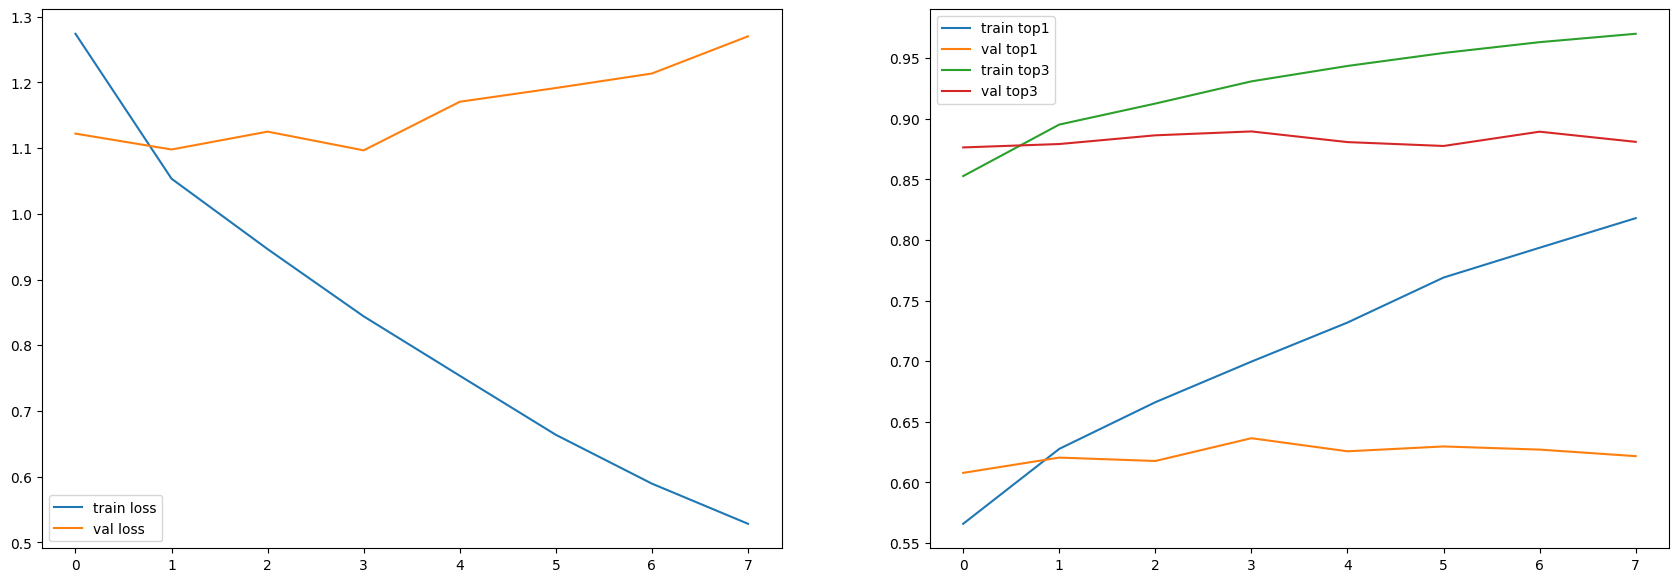

{'loss': 1.1313824045658112, 'top1': 0.6211999999999999, 'top3': 0.8843999999999997}


In [20]:
logs = trainer_vgg.train()

# Change this to the experiment you want to visualize (format is `MMDD_TIME`)
path = ospj(PROJECT_ROOT, f'saved/models/CIFAR10_VGG/{run_id}/best_val_model.pth')

trainer_vgg.load_model(path=path)

result = trainer_vgg.evaluate(loader=test_loader)

plot_logs(logs)
print(result)

if wandb_enabled:
    for metrics, values in result.items():
        wandb.run.summary[f"test_{metrics}"] = values

    # Change the title and message as you wish. Would only work if you have enabled push notifications for your email/slack in wandb account settings.
    wandb.alert(title="Training Finished", text=f'VGG Training has finished. Test results: {result}', level=wandb.AlertLevel.INFO)

    run.finish()

b) We can see that while the ImageNet features are useful, just learning the new layers does not yield better performance than training our own network from scratch. This is due to the domain-shift between the ImageNet dataset (224x224 resolution images) and the CIFAR-10 dataset (32x32 images). To improve the performance we can fine-tune the whole network on the CIFAR-10 dataset, starting from the ImageNet initialization (set `"fine_tune"` to `true` in `vgg_cifar10.json`). To do this, enable gradient computation to the rest of the network, and update all the model parameters. Additionally train a baseline model where the same entire network is trained from scratch, without loading the ImageNet weights (set `"pretrained"` to `false` in `vgg_cifar10.json`). Compare the two models' training curves, validation, and testing performance in the report. (4 points)

==> Start Training Epoch 1/10, lr=0.001000 


Train Epoch: 1 Loss: 0.630458: : 100% 45000/45000 [00:31<00:00, 1418.55it/s]

==> Finished Epoch 1/10.
++> Evaluate at epoch 1 ...



Eval Loss: 0.546333: : 100% 5000/5000 [00:03<00:00, 1324.16it/s]

++> Evaluate epoch 1 Finished.


eval_top1 Metric improved: -inf -> 0.8178. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_VGG/4b-1/best_val_model.pth ...
Checkpoint saved.
    epoch          : 1
    loss           : 0.7061673401461708
    top1           : 0.7654888888888891
    top3           : 0.9435111111111109
    eval_loss      : 0.5899898564815521
    eval_top1      : 0.8178
    eval_top3      : 0.9620000000000002
==> Start Training Epoch 2/10, lr=0.000990 


Train Epoch: 2 Loss: 0.341414: : 100% 45000/45000 [00:31<00:00, 1437.03it/s]

==> Finished Epoch 2/10.
++> Evaluate at epoch 2 ...



Eval Loss: 0.587639: : 100% 5000/5000 [00:02<00:00, 2288.95it/s]

++> Evaluate epoch 2 Finished.
eval_top1 Metric improved: 0.8178 -> 0.8296000000000001. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_VGG/4b-1/best_val_model.pth ...


Checkpoint saved.
    epoch          : 2
    loss           : 0.3640892142719693
    top1           : 0.8777555555555556
    top3           : 0.9814666666666673
    eval_loss      : 0.5080779087543488
    eval_top1      : 0.8296000000000001
    eval_top3      : 0.9716000000000001
==> Start Training Epoch 3/10, lr=0.000980 


Train Epoch: 3 Loss: 0.229683: : 100% 45000/45000 [00:31<00:00, 1428.32it/s]

==> Finished Epoch 3/10.
++> Evaluate at epoch 3 ...



Eval Loss: 0.524682: : 100% 5000/5000 [00:02<00:00, 2319.55it/s]

++> Evaluate epoch 3 Finished.
eval_top1 Metric improved: 0.8296000000000001 -> 0.8433999999999999. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_VGG/4b-1/best_val_model.pth ...


Checkpoint saved.
    epoch          : 3
    loss           : 0.23435680084758334
    top1           : 0.9204888888888884
    top3           : 0.9911333333333352
    eval_loss      : 0.5220388090610504
    eval_top1      : 0.8433999999999999
    eval_top3      : 0.968
==> Start Training Epoch 4/10, lr=0.000970 


Train Epoch: 4 Loss: 0.239341: : 100% 45000/45000 [00:31<00:00, 1406.61it/s]

==> Finished Epoch 4/10.
++> Evaluate at epoch 4 ...



Eval Loss: 0.567672: : 100% 5000/5000 [00:03<00:00, 1614.20it/s]

++> Evaluate epoch 4 Finished.


    epoch          : 4
    loss           : 0.16154744360182022
    top1           : 0.9449333333333332
    top3           : 0.9961777777777795
    eval_loss      : 0.5709246206283569
    eval_top1      : 0.8343999999999998
    eval_top3      : 0.9628
==> Start Training Epoch 5/10, lr=0.000961 


Train Epoch: 5 Loss: 0.097658: : 100% 45000/45000 [00:30<00:00, 1477.34it/s]

==> Finished Epoch 5/10.
++> Evaluate at epoch 5 ...



Eval Loss: 0.433105: : 100% 5000/5000 [00:02<00:00, 2420.55it/s]

++> Evaluate epoch 5 Finished.
eval_top1 Metric improved: 0.8433999999999999 -> 0.8519999999999999. Saving the best model


Saving checkpoint: ../../saved/models/CIFAR10_VGG/4b-1/best_val_model.pth ...
Checkpoint saved.
    epoch          : 5
    loss           : 0.12517893339196842
    top1           : 0.957533333333334
    top3           : 0.9972888888888902
    eval_loss      : 0.5373716413974762
    eval_top1      : 0.8519999999999999
    eval_top3      : 0.9736
==> Start Training Epoch 6/10, lr=0.000951 


Train Epoch: 6 Loss: 0.122111: : 100% 45000/45000 [00:31<00:00, 1438.05it/s]

==> Finished Epoch 6/10.
++> Evaluate at epoch 6 ...



Eval Loss: 0.552948: : 100% 5000/5000 [00:02<00:00, 2394.74it/s]

++> Evaluate epoch 6 Finished.
eval_top1 Metric improved: 0.8519999999999999 -> 0.8614000000000002. Saving the best model


Saving checkpoint: ../../saved/models/CIFAR10_VGG/4b-1/best_val_model.pth ...
Checkpoint saved.
    epoch          : 6
    loss           : 0.09714094242288007
    top1           : 0.967377777777778
    top3           : 0.998622222222223
    eval_loss      : 0.5193441152572632
    eval_top1      : 0.8614000000000002
    eval_top3      : 0.9739999999999998
==> Start Training Epoch 7/10, lr=0.000941 


Train Epoch: 7 Loss: 0.099473: : 100% 45000/45000 [00:31<00:00, 1444.08it/s]

==> Finished Epoch 7/10.
++> Evaluate at epoch 7 ...



Eval Loss: 0.597714: : 100% 5000/5000 [00:02<00:00, 2139.56it/s]

++> Evaluate epoch 7 Finished.
eval_top1 Metric improved: 0.8614000000000002 -> 0.8647999999999999. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_VGG/4b-1/best_val_model.pth ...


Checkpoint saved.
    epoch          : 7
    loss           : 0.07857194134551618
    top1           : 0.9738000000000001
    top3           : 0.9988888888888896
    eval_loss      : 0.5421680808067322
    eval_top1      : 0.8647999999999999
    eval_top3      : 0.9752000000000001
==> Start Training Epoch 8/10, lr=0.000932 


Train Epoch: 8 Loss: 0.099396: : 100% 45000/45000 [00:31<00:00, 1417.51it/s]

==> Finished Epoch 8/10.
++> Evaluate at epoch 8 ...



Eval Loss: 0.525900: : 100% 5000/5000 [00:02<00:00, 2359.19it/s]

++> Evaluate epoch 8 Finished.
    epoch          : 8
    loss           : 0.07166972736517588
    top1           : 0.9760666666666681
    top3           : 0.9990222222222228
    eval_loss      : 0.6029787337779999
    eval_top1      : 0.8548
    eval_top3      : 0.9701999999999998


==> Start Training Epoch 9/10, lr=0.000923 


Train Epoch: 9 Loss: 0.083356: : 100% 45000/45000 [00:30<00:00, 1463.50it/s]

==> Finished Epoch 9/10.
++> Evaluate at epoch 9 ...



Eval Loss: 0.537085: : 100% 5000/5000 [00:02<00:00, 2369.86it/s]

++> Evaluate epoch 9 Finished.
    epoch          : 9
    loss           : 0.06885306124058034
    top1           : 0.9777333333333329
    top3           : 0.9991111111111118


    eval_loss      : 0.5955854487419129
    eval_top1      : 0.8533999999999997
    eval_top3      : 0.9700000000000002
==> Start Training Epoch 10/10, lr=0.000914 


Train Epoch: 10 Loss: 0.070415: : 100% 45000/45000 [00:30<00:00, 1475.78it/s]

==> Finished Epoch 10/10.
++> Evaluate at epoch 10 ...



Eval Loss: 0.505803: : 100% 5000/5000 [00:02<00:00, 2404.94it/s]

++> Evaluate epoch 10 Finished.
    epoch          : 10


    loss           : 0.060971410595294505
    top1           : 0.980555555555556
    top3           : 0.9992666666666671
    eval_loss      : 0.6407136046886444
    eval_top1      : 0.8512
    eval_top3      : 0.97
Saving checkpoint: ../../saved/models/CIFAR10_VGG/4b-1/E10_model.pth ...
Checkpoint saved.
Saving checkpoint: ../../saved/models/CIFAR10_VGG/4b-1/last_model.pth ...
Checkpoint saved.
Loading checkpoint: ../../saved/models/CIFAR10_VGG/4b-1/best_val_model.pth ...
Checkpoint loaded.
++> Evaluate at epoch 10 ...


Eval Loss: 0.471477: : 100% 10000/10000 [00:03<00:00, 2743.58it/s]

++> Evaluate epoch 10 Finished.


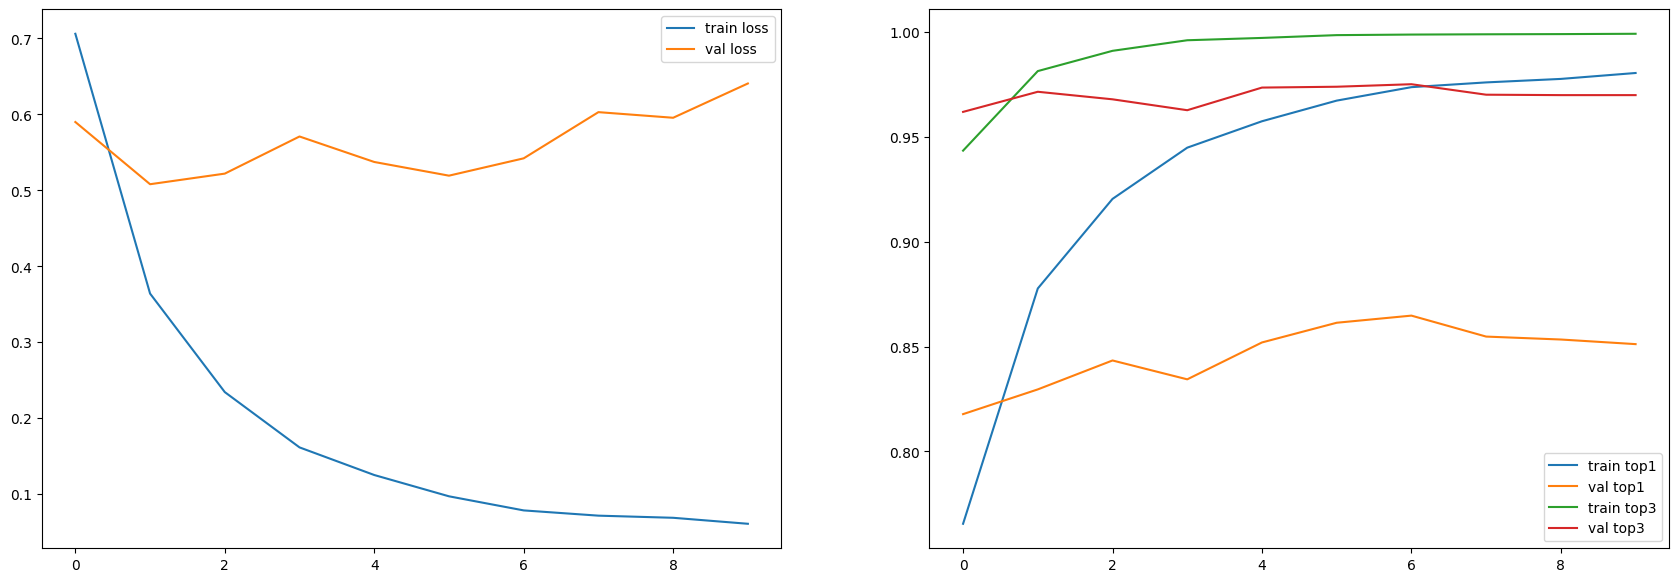

{'loss': 0.5571392667293549, 'top1': 0.8565000000000002, 'top3': 0.9757999999999999}


In [21]:
run_id="4b-1"
config = ConfigParser.wo_args(config='cfgs/exercise-3/vgg_cifar10.json', root_dir=PROJECT_ROOT, run_id=run_id)
config["arch"]["args"]["fine_tune"] = True

trainer_vgg = VGGTrainer(config=config, train_loader=train_data_loader, eval_loader=valid_data_loader)
logs = trainer_vgg.train()
path = ospj(PROJECT_ROOT, f'saved/models/CIFAR10_VGG/{run_id}/best_val_model.pth')

trainer_vgg.load_model(path=path)

result = trainer_vgg.evaluate(loader=test_loader)

plot_logs(logs)
print(result)

if wandb_enabled:
    for metrics, values in result.items():
        wandb.run.summary[f"test_{metrics}"] = values

    # Change the title and message as you wish. Would only work if you have enabled push notifications for your email/slack in wandb account settings.
    wandb.alert(title="Training Finished", text=f'VGG Training has finished. Test results: {result}', level=wandb.AlertLevel.INFO)

    run.finish()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


==> Start Training Epoch 1/10, lr=0.001000 


Train Epoch: 1 Loss: 0.992938: : 100% 45000/45000 [00:33<00:00, 1356.25it/s]

==> Finished Epoch 1/10.
++> Evaluate at epoch 1 ...



Eval Loss: 1.175337: : 100% 5000/5000 [00:02<00:00, 1963.44it/s]

++> Evaluate epoch 1 Finished.
eval_top1 Metric improved: -inf -> 0.6233999999999998. Saving the best model


Saving checkpoint: ../../saved/models/CIFAR10_VGG/4b-2/best_val_model.pth ...
Checkpoint saved.
    epoch          : 1
    loss           : 1.3219463608000013
    top1           : 0.5255555555555554
    top3           : 0.8281333333333335
    eval_loss      : 1.0906454300880433
    eval_top1      : 0.6233999999999998
    eval_top3      : 0.9028
==> Start Training Epoch 2/10, lr=0.000990 


Train Epoch: 2 Loss: 0.705626: : 100% 45000/45000 [00:31<00:00, 1416.54it/s]

==> Finished Epoch 2/10.
++> Evaluate at epoch 2 ...



Eval Loss: 0.863097: : 100% 5000/5000 [00:02<00:00, 2373.55it/s]

++> Evaluate epoch 2 Finished.


eval_top1 Metric improved: 0.6233999999999998 -> 0.714. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_VGG/4b-2/best_val_model.pth ...
Checkpoint saved.
    epoch          : 2
    loss           : 0.8126846403545803
    top1           : 0.7135111111111109
    top3           : 0.9293777777777776
    eval_loss      : 0.8389547276496887
    eval_top1      : 0.714
    eval_top3      : 0.9356
==> Start Training Epoch 3/10, lr=0.000980 


Train Epoch: 3 Loss: 0.459037: : 100% 45000/45000 [00:31<00:00, 1443.25it/s]

==> Finished Epoch 3/10.
++> Evaluate at epoch 3 ...



Eval Loss: 0.643572: : 100% 5000/5000 [00:02<00:00, 1912.31it/s]

++> Evaluate epoch 3 Finished.
eval_top1 Metric improved: 0.714 -> 0.7626000000000002. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_VGG/4b-2/best_val_model.pth ...


Checkpoint saved.
    epoch          : 3
    loss           : 0.6252967552344004
    top1           : 0.7854666666666666
    top3           : 0.9543999999999996
    eval_loss      : 0.682545793056488
    eval_top1      : 0.7626000000000002
    eval_top3      : 0.9499999999999998
==> Start Training Epoch 4/10, lr=0.000970 


Train Epoch: 4 Loss: 0.550476: : 100% 45000/45000 [00:31<00:00, 1429.69it/s]

==> Finished Epoch 4/10.
++> Evaluate at epoch 4 ...



Eval Loss: 0.906659: : 100% 5000/5000 [00:02<00:00, 2336.36it/s]

++> Evaluate epoch 4 Finished.
    epoch          : 4
    loss           : 0.4947599824269613


    top1           : 0.8274666666666667
    top3           : 0.9695555555555552
    eval_loss      : 0.827407157421112
    eval_top1      : 0.7460000000000001
    eval_top3      : 0.9281999999999998
==> Start Training Epoch 5/10, lr=0.000961 


Train Epoch: 5 Loss: 0.420398: : 100% 45000/45000 [00:30<00:00, 1462.20it/s]

==> Finished Epoch 5/10.
++> Evaluate at epoch 5 ...



Eval Loss: 0.861190: : 100% 5000/5000 [00:02<00:00, 2410.97it/s]

++> Evaluate epoch 5 Finished.
    epoch          : 5
    loss           : 0.3914273078574075
    top1           : 0.8632444444444447
    top3           : 0.9793111111111108


    eval_loss      : 0.8058855557441711
    eval_top1      : 0.754
    eval_top3      : 0.9440000000000001
==> Start Training Epoch 6/10, lr=0.000951 


Train Epoch: 6 Loss: 0.298982: : 100% 45000/45000 [00:30<00:00, 1455.83it/s]

==> Finished Epoch 6/10.
++> Evaluate at epoch 6 ...



Eval Loss: 0.976775: : 100% 5000/5000 [00:02<00:00, 2224.31it/s]

++> Evaluate epoch 6 Finished.
    epoch          : 6
    loss           : 0.2919907908969455
    top1           : 0.8991333333333328
    top3           : 0.9874666666666684
    eval_loss      : 0.8548025441169739
    eval_top1      : 0.7572
    eval_top3      : 0.9292


==> Start Training Epoch 7/10, lr=0.000941 


Train Epoch: 7 Loss: 0.190360: : 100% 45000/45000 [00:30<00:00, 1461.16it/s]

==> Finished Epoch 7/10.
++> Evaluate at epoch 7 ...



Eval Loss: 0.635912: : 100% 5000/5000 [00:02<00:00, 2128.85it/s]

++> Evaluate epoch 7 Finished.
eval_top1 Metric improved: 0.7626000000000002 -> 0.7916000000000001. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_VGG/4b-2/best_val_model.pth ...


Checkpoint saved.
    epoch          : 7
    loss           : 0.2405973557300038
    top1           : 0.9177333333333326
    top3           : 0.9909333333333354
    eval_loss      : 0.726514630317688
    eval_top1      : 0.7916000000000001
    eval_top3      : 0.95
==> Start Training Epoch 8/10, lr=0.000932 


Train Epoch: 8 Loss: 0.292447: : 100% 45000/45000 [00:31<00:00, 1415.14it/s]

==> Finished Epoch 8/10.
++> Evaluate at epoch 8 ...



Eval Loss: 0.844868: : 100% 5000/5000 [00:02<00:00, 2373.04it/s]

++> Evaluate epoch 8 Finished.
eval_top1 Metric improved: 0.7916000000000001 -> 0.7966000000000001. Saving the best model
Saving checkpoint: ../../saved/models/CIFAR10_VGG/4b-2/best_val_model.pth ...


Checkpoint saved.
    epoch          : 8
    loss           : 0.17883398776253065
    top1           : 0.9381333333333327
    top3           : 0.9954222222222238
    eval_loss      : 0.7409784245491028
    eval_top1      : 0.7966000000000001
    eval_top3      : 0.9475999999999999
==> Start Training Epoch 9/10, lr=0.000923 


Train Epoch: 9 Loss: 0.212829: : 100% 45000/45000 [00:31<00:00, 1434.60it/s]

==> Finished Epoch 9/10.
++> Evaluate at epoch 9 ...



Eval Loss: 0.854559: : 100% 5000/5000 [00:02<00:00, 2346.06it/s]

++> Evaluate epoch 9 Finished.


    epoch          : 9
    loss           : 0.14034080056680573
    top1           : 0.951133333333333
    top3           : 0.9968000000000011
    eval_loss      : 0.9428408169746398
    eval_top1      : 0.7714000000000002
    eval_top3      : 0.9503999999999999
==> Start Training Epoch 10/10, lr=0.000914 


Train Epoch: 10 Loss: 0.223728: : 100% 45000/45000 [00:31<00:00, 1441.16it/s]

==> Finished Epoch 10/10.
++> Evaluate at epoch 10 ...



Eval Loss: 0.938857: : 100% 5000/5000 [00:03<00:00, 1559.60it/s]

++> Evaluate epoch 10 Finished.


    epoch          : 10
    loss           : 0.12178739925225576
    top1           : 0.9578444444444449
    top3           : 0.9976888888888902
    eval_loss      : 1.0488286709785462
    eval_top1      : 0.775
    eval_top3      : 0.9555999999999999
Saving checkpoint: ../../saved/models/CIFAR10_VGG/4b-2/E10_model.pth ...
Checkpoint saved.
Saving checkpoint: ../../saved/models/CIFAR10_VGG/4b-2/last_model.pth ...
Checkpoint saved.
Loading checkpoint: ../../saved/models/CIFAR10_VGG/4b-2/best_val_model.pth ...
Checkpoint loaded.
++> Evaluate at epoch 10 ...


Eval Loss: 0.811301: : 100% 10000/10000 [00:03<00:00, 2686.82it/s]

++> Evaluate epoch 10 Finished.


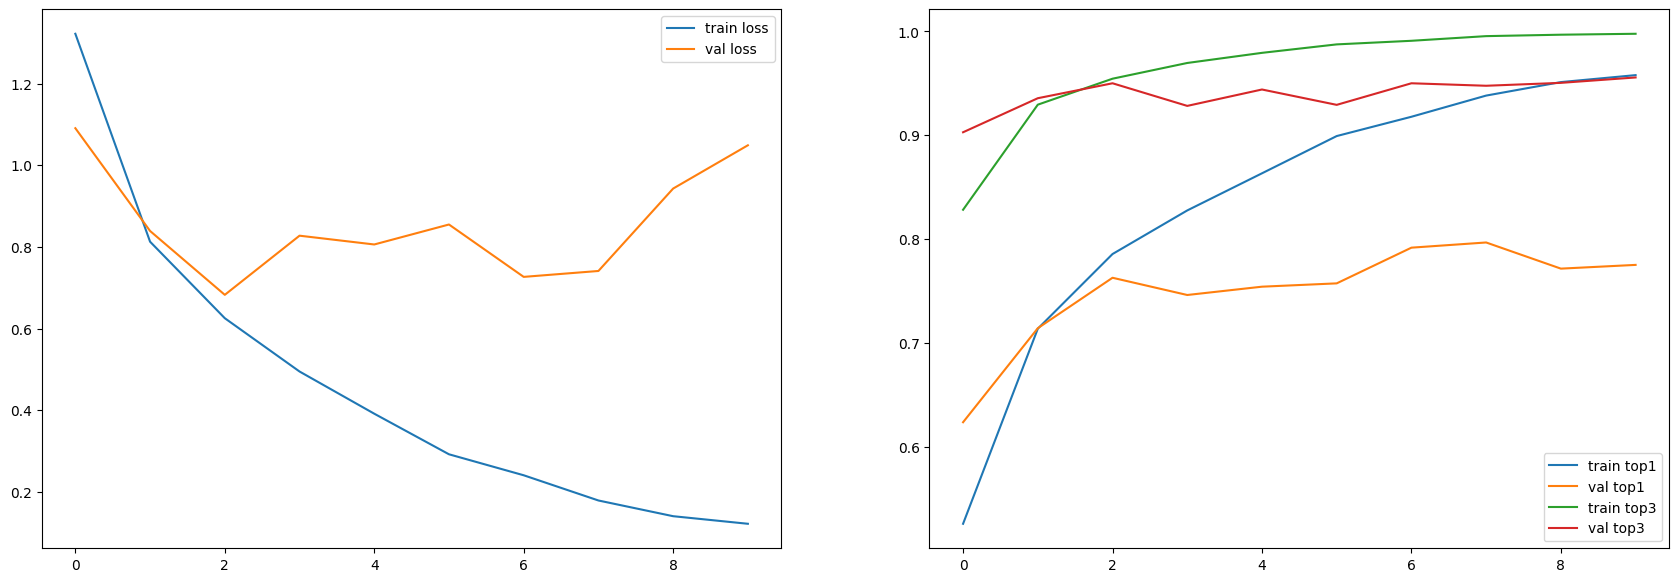

{'loss': 0.7702254903316498, 'top1': 0.7821000000000001, 'top3': 0.9481999999999999}


In [22]:
run_id="4b-2"
config = ConfigParser.wo_args(config='cfgs/exercise-3/vgg_cifar10.json', root_dir=PROJECT_ROOT, run_id=run_id)
config["arch"]["args"]["fine_tune"] = True
config["arch"]["args"]["pretrained"] = False

trainer_vgg = VGGTrainer(config=config, train_loader=train_data_loader, eval_loader=valid_data_loader)
logs = trainer_vgg.train()
path = ospj(PROJECT_ROOT, f'saved/models/CIFAR10_VGG/{run_id}/best_val_model.pth')

trainer_vgg.load_model(path=path)

result = trainer_vgg.evaluate(loader=test_loader)

plot_logs(logs)
print(result)

if wandb_enabled:
    for metrics, values in result.items():
        wandb.run.summary[f"test_{metrics}"] = values

    # Change the title and message as you wish. Would only work if you have enabled push notifications for your email/slack in wandb account settings.
    wandb.alert(title="Training Finished", text=f'VGG Training has finished. Test results: {result}', level=wandb.AlertLevel.INFO)

    run.finish()

#### Write your report for Q4 in this cell.

**4a. No Finetuning**<br>
Just training the classifier layer and finetuning the base feature extractor caused model to severly overfit the training data. The training loss dropped to 0.5 while eval loss was 1.3!

The performance is worse than the 5-layer CNN trained in pervious question. THe Top-1 accuracy dropped form 0.83 to 0.62.

**4b. Finetuning the base model**<br>
Finetuning the base model along with the classifier reduced overfitting and improved the overall performance on both the validation and test set.

Its interesting to note that even though the model overfits the training data, the performance on the test set is still better as compared the 5-layer CNN used in the previous question. (top1_accracy 0.83 -> 0.86)

**4b. Trainig the model from scratch**<br>
Training the model from scratch is worse as compared to finetuning the model (classifier + feature extractor) but better as compared to just training the classifier. 

The test performance is worse as compared to the 5 layer CNN. It achieves top1 accuracy of 0.78 as compared 0.83 by 5 layer CNN.
<br>
<br>

**All the models overfit the training data**